In [27]:
import pickle

def data_load():
        with open('./Data/pclus1.pkl', 'rb') as f:
            pclus = pkl.load(f)
        with open('./Data/dclus1.pkl', 'rb') as f:
            dclus = pkl.load(f)
        with open('./Data/pp.pkl', 'rb') as f:
            pp = pkl.load(f)
        with open('./Data/dd.pkl', 'rb') as f:
            dd = pkl.load(f)
        return pclus, dclus, pp, dd
    
# 완전 랜덤 샘플링
def randomSampling(dc, num):
    # lon 최대 최소값, lat 최대 최소값
    max_lon, min_lon = max(dc['dropoff_longitude']), min(dc['dropoff_longitude'])
    max_lat, min_lat = max(dc['dropoff_latitude']), min(dc['dropoff_latitude'])
    
    # lon, lat값 랜덤 생성 후 매칭 반환
    sample_lon = np.random.uniform(low=min_lon, high=max_lon, size=(num,1))
    sample_lat = np.random.uniform(low=min_lat, high=max_lat, size=(num,1))
    return np.concatenate([sample_lon, sample_lat], axis=1)

def calculate_matrix(idx, pclus, dclus, pp, dd):
        """ d2 """
        d2 = pp[idx][:, 4].reshape(-1, 1)

        """공차 샘플링"""
        # 85% 하차데이터 + 15% 랜덤테이터
        x1 = int(dd[idx].shape[0] * 0.85)
        x2 = dd[idx].shape[0] - x1
        # 15% 랜덤데이터 생성
        rS = randomSampling(dclus[idx], x2)
        
        # 랜덤데이터에 date, time 컬럼 생성
        rSS = np.concatenate([rS, dclus[idx]['date'][0:rS.shape[0]].to_numpy().reshape(-1, 1), \
                        dclus[idx]['time'][0:rS.shape[0]].to_numpy().reshape(-1, 1)], axis= 1)

        # 하차데이터 85% 랜덤 선택
        x3 = np.random.choice(dd[idx].shape[0], x1, replace=False)
        
        # x3 : lat, lon, date, time
        x3 = np.concatenate([dd[idx][x3], rSS], axis = 0)
        
        # x4 : lat, lon
        return d2, x4 = x3[:, 0:2]

In [ ]:
# Q-learning table사용
import scipy
import scipy.stats
import numpy as np
import random
import pylab
from collections import defaultdict
import pickle as pkl
from tqdm import tqdm_notebook

MINPRICE = 2800
MAXPRICE = 4800
INITIALPRICE = 3800

def data_load():
#     with open('./Data/pclus1.pkl', 'rb') as f:
#         pclus = pkl.load(f)
    with open('./Data/dclus1.pkl', 'rb') as f:
        dclus = pkl.load(f)
    with open('./Data/pp.pkl', 'rb') as f:
        pp = pkl.load(f)
    with open('./Data/dd.pkl', 'rb') as f:
        dd = pkl.load(f)
    return dclus, pp, dd
    
# 완전 랜덤 샘플링
def randomSampling(dc, num):
    # lon 최대 최소값, lat 최대 최소값
    max_lon, min_lon = max(dc['dropoff_longitude']), min(dc['dropoff_longitude'])
    max_lat, min_lat = max(dc['dropoff_latitude']), min(dc['dropoff_latitude'])
    
    # lon, lat값 랜덤 생성 후 매칭 반환
    sample_lon = np.random.uniform(low=min_lon, high=max_lon, size=(num,1))
    sample_lat = np.random.uniform(low=min_lat, high=max_lat, size=(num,1))
    return np.concatenate([sample_lon, sample_lat], axis=1)

def trip_Distance(idx, pp):
    """ d2 """
    return pp[idx][:, 4].reshape(-1, 1)

def Calculate_distance(X1, X2):
    """ euclidean 거리계산 -> harvasion으로 변경 고려 """
    return ((X1 - X2)**2).sum(1)**0.5

def Calculate_Matrix(idx, dclus, pp, dd):
    """공차 샘플링"""
    # 85% 하차데이터 + 15% 랜덤테이터
    x1 = int(dd[idx].shape[0] * 0.85)
    x2 = dd[idx].shape[0] - x1
    
    # 15% 랜덤데이터 생성
    rS = randomSampling(dclus[idx], x2)

    # 랜덤데이터에 date, time 컬럼 생성
    rSS = np.concatenate([rS, dclus[idx]['date'][0:rS.shape[0]].to_numpy().reshape(-1, 1), \
                    dclus[idx]['time'][0:rS.shape[0]].to_numpy().reshape(-1, 1)], axis= 1)

    # 하차데이터 85% 랜덤 선택, x3 : lat, lon, date, time
    x3 = np.random.choice(dd[idx].shape[0], x1, replace=False)
    x3 = np.concatenate([dd[idx][x3], rSS], axis = 0)

    """ d1 """
    x = pp[idx][:, 0:2]     # 승객 위치
    y = x3[:, 0:2]          # 공차 위치
    matrix = np.zeros([x.shape[0],y.shape[0]]) # 매트릭스 초기화

    # d1 계산
    for idx, i in enumerate(x):
        matrix[idx] = Calculate_distance(i, y)

    # emin = 0이 아닌 최솟값
    emin = np.min(np.where(matrix == 0.0, 1, matrix))
    return 1 / (matrix + emin) * emin
    
def myHdbscan(train_data_robustScaled, cluster_size = 7):
    """auto HBSCAN"""
    import hdbscan
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, np.unique(clusterer.labels_).shape[0] # label갯수 리턴

def ScaledHdbscan(idx, pp, cluster_size = 7):
    from sklearn.preprocessing import RobustScaler
    
    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
    train_data = pp[idx][:, :2]
    print(robustScaler.fit(train_data))
    train_data_robustScaled = robustScaler.transform(train_data)

    # Hdbscan 적용
    return myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8

def dbcluster(idx, pp, clusterer, k=3):
    """ y2 """
    from knn import KNN

    X_train = pp[idx][:, 0:2]
    # 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
    t_train = clusterer.labels_ + 1
    X_test = pp[idx][:, 2:4]
    print("label : ", np.unique(t_train))
    K=3 # K = 3

    knn_train = KNN(K, X_train, t_train, np.unique(t_train))
    knn_train.show_dim()

    y2 = np.zeros(X_test.shape[0], dtype = int)

    for i in range(X_test.shape[0]):
        knn_train.get_nearest_k(X_test[i])
        y2[i] = knn_train.weighted_majority_vote()
        knn_train.reset()

    bincount = np.bincount(y2)
    maxLabel = np.argmax(bincount)
    maxLabelcount = np.max(bincount)
    print("y2 : ", y2, "\ny2.bincount : ", bincount)
    print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
    # 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
    y2 = np.where(y2 == maxLabel, 1.2, (np.where(y2 == 0, 0.8, 1)))

    # 수 확인
    values, counts = np.unique(y2, return_counts=True)
    print("values: ",values,"counts: ", counts)

    y2 = y2.reshape(-1, 1)
    return y2

# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE          # marketPrice 
        self.initPrice = INITIALPRICE            # InitialPrice
        self.p_array = None    #Passenger의 선호 가격 리스트
        self.passengers = None #승객의 수 초기 500명
        self.d_array = None    #Driver의 선호 가격 리스트
        self.drivers = None    #운전자 수 초기 500명
        self.matrix = None # matching matrix
        
    #승객이 가격승낙할 확률
    def acceptP(self, offer, preferred):
        x = (preferred - offer) / 1600
        # 누적분포 확률이용
        return np.sum(np.random.rand(len(x)) <= scipy.stats.norm(0, 1).cdf(x))
        
    #운전자가 가격승낙할 확률
    def acceptD(self, offer, preferred):
        x = (offer - preferred) / 1600
        # 누적분포 확률이용
        return np.sum(np.random.rand(len(x)) <= scipy.stats.norm(0, 1).cdf(x))
    
    def step(self, action):
        if   action == 0:   # up : price-=80
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            pass
        
        elif action == 3:   # right : price+=20
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0

        #보상 = next_state가격에서의 (match성사수) * (match 성사가격)
        p_ok = self.acceptP(next_state, self.p_array)
        d_ok = self.acceptD(next_state, self.d_array)
        match = min([p_ok, d_ok])
        reward = match * (next_state/1000)
        
        #보상 가격허용치를 넘으면 -100
        if next_state < (self.initPrice / 2) or next_state > (self.initPrice * 2):
            reward = -100
        
        return next_state, reward
        
    def reset(self, matrix):
        self.passengers = matrix.shape[0]
        self.drivers = matrix.shape[1]
        self.p_array = np.random.normal(self.marketPrice, 190, self.passengers) #Passenger의 선호 가격 리스트
        self.d_array = np.random.normal(self.marketPrice, 190, self.drivers) #Driver의 선호 가격 리스트
        # 매칭 매트릭스 초기화
        self.matrix = matrix
        if self.initPrice is None:
            self.initPrice = INITIALPRICE
        else:
            self.initPrice = self.marketPrice
            
        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.load_model = False
        self.actions = actions
        self.learning_rate = None
        self.discount_factor = None
        self.epsilon = None  # exploration
        self.epsilon_decay = None
        self.epsilon_min = None
        self.q_table = None # 5열
        
    # <s, a, r, s'> 샘플로부터 큐함수 업데이트
    def learn(self, state, action, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        q_1 = self.q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_2 - q_1)
    
    # 큐함수에 의거하여 입실론 탐욕 정책에 따라서 행동을 반환
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # 10% 확률로 무작위 행동 반환
            action = np.random.choice(self.actions)
        else:
            # 큐함수에 따른 행동 반환
            print(state, self.q_table[state])
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action
        
    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)
    
    def reset():
        self.load_model = False
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0]) # 5열
        
if __name__ == "__main__":
    # Data_load
    dclus, pp, dd = data_load()
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    for episode in tqdm_notebook(range(24)):
        # 매칭 매트릭스 계산
        d1Matrix = Calculate_Matrix(episode, dclus, pp, dd)
        d2 = trip_Distance(episode, pp)
        clusterer, labelNum = ScaledHdbscan(episode, pp, cluster_size = 7)
        y2 = dbcluster(episode, pp, clusterer, k = 3)
        matrix = d1Matrix * d2 * y2
        
        state = env.reset(matrix)
        
        for i in range(50000):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward = env.step(action)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
            #env.print_value_all(agent.q_table)
            
            scores.append(state)
            episodes.append(episode*50000 + i)
            if((i % 100) == 0):
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./DP_graph.png")
                print("episode:", episode, "  score:", state, " global_step:",
                      global_step, "  epsilon:", agent.epsilon)
            

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
label :  [0 1 2 3 4 5]
Input Dimension:  (1520, 2)
Output Dimension:  (1520,)
y2 :  [5 5 5 ... 5 5 5] 
y2.bincount :  [ 178    5   16   25   27 1269]
maxLabel:  5 maxLabelcount :  1269
values:  [0.8 1.  1.2] counts:  [ 178   73 1269]
episode: 0   score: 3780  global_step: 1   epsilon: 0.9999
4040 [24.258640622399998, 0.0, 0.0, 0.0, 27.0684]
episode: 0   score: 4500  global_step: 101   epsilon: 0.989950333757503
episode: 0   score: 4680  global_step: 201   epsilon: 0.9800996732739187
4420 [0.0, 0.0, 0.0, 0.0, 0.0]
4580 [89.62112588902764, 0.0, 44.4957534, 43.4276452697654, 20.1062553560254]
4340 [0.0, 0.0, 0.0, 24.463306000000003, 0.0]
episode: 0   score: 4120  global_step: 301   epsilon: 0.9703470333764725
4740 [61.564754338490545, 0.0, 61.15076293336199, 60.67429971390368, -1.4623831877680002]
episode: 0   score: 4600  global_step: 401   epsilon: 0.9606914386955115
4720 [42.606884

episode: 0   score: 8140  global_step: 2501   epsilon: 0.7787131683686925
8580 [-1.99, -1.999, -1.99, -1.99, -3.940399]
8500 [-1.0, -1.999, -1.0, -1.0, -1.99]
8360 [-1.999, -1.0, 0.0, -1.0, 0.0]
8340 [-1.999, -1.99, -1.0, -2.9701, 0.0]
8420 [-1.99, -1.99, -2.9701, -1.0, -1.99]
8380 [-1.999, 0.0, -1.0, -1.0, -1.99]
8360 [-1.999, -2.9701, -1.0, -1.0, 0.0]
8400 [-1.0, -1.0, -3.940399, -2.9701, -1.999]
8460 [-1.99, -1.0, -1.0, -1.0, -2.9791]
8460 [-1.99, -1.0, -1.999, -1.0, -2.9791]
8440 [-1.0, -2.98801, 0.0, -1.0090000000000001, -1.0090000000000001]
8440 [-1.0, -2.98801, -1.0, -1.0090000000000001, -1.0090000000000001]
8220 [-1.99, 0.0, 0.0, -2.9791, -1.999]
8220 [-1.99, 0.0, -1.0, -2.9791, -1.999]
8200 [-1.0, -1.0, -1.0, -1.0, -1.999]
8020 [-3.940399, -1.99, -2.98801, -1.99, -2.9701]
7740 [-1.0, -1.0, 0.0, 0.0, -1.99]
7600 [0.0, 0.0, 0.0, 0.0, -1.0]
7620 [0.0, 0.0, 0.0, 0.0, -2.9791]
7560 [0.0, 0.0, 0.0, -1.0, 0.0]
7740 [-1.0, -1.0, 0.0, -1.0, -1.99]
7740 [-1.0, -1.0, -1.0, -1.0, -1.99]
7

7360 [-4.98960149329, -4.9722962588119, -6.8461330748401, -5.922968113990001, -5.03354254040191]
7340 [-5.9493241693089995, -6.864118755391, -6.969205498551481, -5.9054216599, -5.9051795509]
7440 [-5.958200402004781, -6.924801121823809, -7.901253994724833, -5.94964611489555, -5.949710854237]
7460 [-6.890711441850101, -7.884444498441843, -5.9053407409, -4.98095685091, -3.994162622839]
7540 [-4.989999812329, -4.037966812018, -4.954189501, -5.931283970080001, -4.963639114738]
7520 [-5.932178504839, -5.9575575732391, -8.883854458154614, -5.9408317283509, -4.962922192000001]
7600 [-6.899526673219, -3.958309, -2.98801, -2.979181, -4.9634097633189995]
7640 [-3.993593491, -3.9760399, -3.97620109, -6.855710251054771, -3.9671299]
7720 [-4.9277259099999995, -7.813304544091699, -3.9673, -1.999, -1.999]
7900 [-1.0, -2.98801, -1.999, -2.9791, -3.9671298999999998]
7840 [-1.999, -1.99, -1.999, -2.0079100000000003, -3.9760399]
7660 [-4.90999501, -3.940399, -3.967380919, -5.016013151874661, -3.958309]
7

9760 [-3.958309, -1.99, -2.9791, -1.0, -1.99]
9760 [-3.958309, -1.99, -2.9791, -1.999, -1.99]
9740 [0.0, -1.999, -1.99, -2.9791, -1.0]
9660 [-1.99, -2.9791, -1.0, -1.99, -1.99]
9640 [-1.99, -1.99, -1.999, -2.9701, -2.0079100000000003]
9620 [-1.999, -1.0, -1.999, -1.0090810000000001, -2.9791]
9600 [-1.0, -1.99, -1.0, 0.0, -1.0090000000000001]
9440 [-1.99, -1.0, -2.98801, -2.9791, -1.999]
9540 [-1.999, -1.99, -2.9791, -1.0, -2.9701]
9620 [-2.98801, -1.99, -3.96729254071, -1.0090810000000001, -2.9791]
9720 [-2.9791, -1.0, -2.9791, -1.0, -2.98801]
9740 [-1.0090000000000001, -1.999, -1.99, -2.9791, -1.0]
9900 [-1.0, -2.9701, -1.99, -3.9583899999999996, -1.99]
9820 [-1.0, 0.0, -2.9701, -1.0, -3.958309]
9800 [-1.999, -1.999, -1.999, -1.99, -1.0]
9860 [-1.999, -1.0, 0.0, -1.0, -1.0]
9740 [-1.0090000000000001, -1.999, -1.99, -2.9791, -1.99]
9740 [-3.0145618, -1.999, -2.98801, -2.9791, -1.99]
9780 [-1.0, -3.9760399, -1.999, -1.99, -1.0]
9760 [-4.9277259099999995, -3.95839, -2.9791, -2.98801, -1.

12160 [-1.0090000000000001, -1.999, -1.999, -1.0, -1.0]
12180 [-1.999, 0.0, -1.0, -1.99, -1.0]
12200 [-1.0, -1.99, -4.9277259099999995, -1.0, -1.99]
12200 [-1.0, -1.99, -4.9277259099999995, -1.999, -1.99]
12140 [-1.0, -1.99, -2.9791, -3.958309, -1.999]
12240 [-1.0, -2.9791, -1.0, -1.0, -1.0]
12260 [-1.0, -1.99, -1.0, -1.0, 0.0]
12340 [-1.99, -1.0, 0.0, 0.0, 0.0]
12300 [-1.99, 0.0, -1.99, -1.0, -1.0]
12280 [-1.0090000000000001, 0.0, 0.0, -1.0, -1.0]
12300 [-1.99, -1.0, -1.99, -1.0, -1.0]
12360 [0.0, -1.0, -1.99, 0.0, -1.99]
12380 [0.0, -1.99, -1.0, -1.0, 0.0]
12460 [0.0, 0.0, 0.0, -1.0, 0.0]
12440 [-1.0, -1.0, -1.99, -1.0, -1.0]
12420 [-1.0, -1.0, 0.0, -1.99, 0.0]
12420 [-1.99, -1.0, -1.0, -1.99, 0.0]
12500 [-1.0, -1.0, -1.99, 0.0, -1.0]
12520 [0.0, -1.0, -1.0, 0.0, 0.0]
12620 [0.0, 0.0, 0.0, 0.0, 0.0]
12540 [0.0, 0.0, 0.0, 0.0, -1.0]
12500 [-1.0, -1.0, -2.9791, -1.0, -1.0]
12580 [-1.0, 0.0, 0.0, 0.0, 0.0]
12640 [0.0, 0.0, 0.0, 0.0, 0.0]
12560 [0.0, 0.0, 0.0, 0.0, -1.0]
12560 [0.0, 0.0,

12120 [-1.999, -1.999, -1.999, -3.958309, -3.0058219]
12120 [-1.999, -1.999, -2.997001, -3.958309, -3.0058219]
11980 [-2.9701, -2.9791, -2.98801, -3.9938340691, -2.9701]
11900 [-1.99, -1.999, -2.9969200000000003, -2.0079100000000003, -3.0057409]
11800 [-2.9701, -1.0, -1.999, -1.99, -1.0]
11760 [-1.0, -1.0, -1.0, -1.0, -1.0]
11760 [-1.0, -1.0, -2.98801, -1.0, -1.0]
11740 [0.0, -1.0, -1.99, -1.0, -1.0]
11660 [-1.99, -1.0, -1.0, -1.0, 0.0]
11740 [-1.0, -1.0, -2.9791, -1.999, -1.0]
11660 [-1.99, -1.0, -1.0, -1.0, -1.0090000000000001]
11660 [-1.99, -1.0, -1.999, -1.0, -1.0090000000000001]
11680 [-1.0, -1.0, -2.9701, -1.0, -1.0]
11620 [-1.99, -1.0, -1.0, -2.9701, -1.0]
11600 [-2.00791, -1.0, -3.9671299, -1.999, -1.0]
11660 [-1.99, -1.0, -1.999, -1.999, -1.0090000000000001]
11560 [-1.0, -1.0, -1.0, -1.0, -2.9791]
11540 [-1.0, -3.949399, -1.0, -1.0, -1.99]
11560 [-1.0, -1.999, -1.0, -1.0, -2.9791]
11580 [-1.99, -1.0, -1.99, -1.0090000000000001, -1.99]
11560 [-1.0, -1.999, -1.999, -1.999, -2.97

10800 [-3.985102909, -4.011388462, -4.9811156344, -3.940399, -3.967461109]
10800 [-3.985102909, -4.011388462, -4.9811156344, -4.92780691, -3.967461109]
10880 [-4.95451909, -4.0025667601, -6.9002369223488, -3.9671299, -4.028853580895801]
10980 [-3.9758625910000003, -5.93170552081, -3.99384289, -3.967219, -3.9937546810000004]
11000 [-4.002575581, -4.9634914762, -3.9761208999999997, -3.0149619562000005, -5.91398683399]
11020 [-3.949399, -4.963331971, -3.99376189, -3.967219, -3.0145618]
11040 [-4.9720620886219, -3.9673, -3.9760399, -4.002655771000001, -5.9229745219]
11020 [-3.949399, -4.963331971, -3.99376189, -4.96325251, -4.02036148972]
10940 [-2.98801, -3.97620109, -3.99392308, -3.9852638431129, -4.9456180000000005]
10840 [-3.949399, -2.9969200000000003, -3.99384289, -4.9633311691, -4.011546444318999]
10820 [-3.9760399, -3.985016149981, -2.9969200000000003, -3.98510218, -2.9791]
10900 [-3.0146428, -3.00622269691, -1.0, -4.945618, -4.963251781]
10820 [-3.9760399, -3.985016149981, -2.9969

13160 [-1.99, -1.0090000000000001, -1.99, 0.0, -1.0]
13180 [-1.999, -1.0, -1.0, -1.99, -1.0]
13260 [-1.0, -1.99, -1.99, -1.99, -1.0]
13180 [-1.999, -1.0, -1.0, -1.99, -1.999]
13180 [-1.999, -1.0, -1.999, -1.99, -1.999]
episode: 0   score: 13220  global_step: 7201   epsilon: 0.4866860585527523
13220 [-1.0, -1.0090000000000001, -1.0, -1.99, -1.0]
13280 [-1.0, -1.99, -3.940399, -1.0, -1.0]
13220 [-1.0, -1.0090000000000001, -2.98801, -1.99, -1.99]
13140 [-2.0079100000000003, -1.999, -1.0, -1.0, -1.999]
13160 [-2.98801, -2.0079100000000003, -1.99, -1.0090000000000001, -1.0]
13240 [-1.0, -1.999, -1.99, -1.99, -1.0]
13320 [-1.0, 0.0, 0.0, 0.0, 0.0]
13300 [-1.999, -1.999, 0.0, 0.0, 0.0]
13320 [-1.0, -1.0, 0.0, 0.0, 0.0]
13320 [-1.0, -1.0, -1.0, 0.0, 0.0]
13340 [-1.0090000000000001, 0.0, 0.0, 0.0, 0.0]
13240 [-1.999081, -1.999, -1.99, -1.99, -1.99]
13220 [-1.999, -1.0090000000000001, -2.98801, -1.99, -1.99]
13180 [-1.999, -1.999, -1.999, -1.99, -1.999]
13200 [-1.99, -2.98801, -2.98801, -1.0, -1

15440 [0.0, 0.0, 0.0, 0.0, 0.0]
15420 [0.0, 0.0, 0.0, 0.0, 0.0]
15500 [0.0, 0.0, 0.0, 0.0, 0.0]
15480 [0.0, 0.0, 0.0, 0.0, 0.0]
15560 [0.0, 0.0, 0.0, 0.0, 0.0]
15480 [0.0, 0.0, -1.0, 0.0, -1.0]
15440 [0.0, -1.0, -1.0, 0.0, 0.0]
15460 [0.0, 0.0, -1.0, 0.0, 0.0]
15380 [0.0, -1.0, -1.0, -1.0, 0.0]
15300 [0.0, 0.0, 0.0, 0.0, -1.0]
15320 [0.0, -1.0, 0.0, 0.0, 0.0]
15400 [0.0, -1.0, 0.0, -1.0, 0.0]
15320 [0.0, -1.0, -1.0, 0.0, -1.0]
15240 [-1.99, 0.0, -1.0, 0.0, -1.0]
15260 [0.0, -1.0, 0.0, 0.0, 0.0]
15260 [0.0, -1.0, 0.0, -1.0, 0.0]
15420 [0.0, 0.0, 0.0, -1.0, -1.0]
15400 [-1.0, -1.0, 0.0, -1.0, 0.0]
15480 [-1.0, 0.0, -1.0, 0.0, -1.0]
15460 [-1.0, 0.0, -1.99, 0.0, 0.0]
15500 [0.0, -1.0, 0.0, 0.0, 0.0]
episode: 0   score: 15540  global_step: 7601   epsilon: 0.46760188997308916
15500 [0.0, -1.0, 0.0, -1.0, 0.0]
15520 [-1.0, -1.0, 0.0, -1.0, 0.0]
15620 [0.0, 0.0, 0.0, 0.0, 0.0]
15540 [0.0, -1.0, 0.0, 0.0, 0.0]
15620 [-1.0, 0.0, 0.0, 0.0, 0.0]
15640 [0.0, 0.0, 0.0, 0.0, 0.0]
15660 [0.0, 0.0, 0.

12940 [-1.999, -1.99, -2.9791, -1.999, -1.0]
13020 [-1.999, -1.999, -1.999, -1.99, -1.99]
13200 [-1.99, -2.98801, -2.98801, -3.0057409, -2.00791]
13120 [-2.0079100000000003, -1.999, -2.9969200000000003, -1.99, -2.98801]
13140 [-3.0057409, -2.9880910000000003, -1.999, -1.999, -2.9969200000000003]
13160 [-2.98801, -2.9968309000000004, -2.979181, -1.0090000000000001, -2.9969200000000003]
13160 [-2.98801, -2.9968309000000004, -2.979181, -2.016901, -2.9969200000000003]
13180 [-2.98801, -2.997162109, -1.999, -2.9791, -3.0057409]
13260 [-2.997001, -2.988091729, -3.9849418, -3.9761208999999997, -4.9367971]
13220 [-2.997001, -2.0079100000000003, -2.98801, -3.9760399, -2.9791]
13120 [-2.0079100000000003, -1.999, -2.9969200000000003, -2.988091, -2.98801]
13100 [-1.0090000000000001, -3.958309, -1.99, -2.00791, -3.9673]
13020 [-1.999, -1.999, -1.999, -1.99, -2.9791]
13040 [-1.99, -1.999, -1.999, -1.99, -1.999]
12920 [-2.9701, -1.0090000000000001, -1.99, -1.999, -1.99]
12900 [-1.999, -1.999, -1.999,

10540 [-2.98801, -5.931457100209, -3.9761208999999997, -3.01472299, -3.9762820089999997]
10380 [-2.988091, -2.9969200000000003, -4.94553781, -3.9584701900000003, -3.958309]
10300 [-3.0058219, -3.97620109, -2.997001, -3.0057409, -3.0058219000000004]
10300 [-3.0058219, -3.97620109, -3.9940039990000002, -3.0057409, -3.0058219000000004]
10320 [-2.9884108852, -2.9880910000000003, -3.9760399, -4.94545681, -2.9701]
10400 [-3.9848608000000003, -3.967219, -4.91007601, -3.01472299, -3.0057409]
10480 [-2.99716138, -2.9791, -4.90999501, -3.0058219, -2.997001]
10460 [-4.971985201, -3.00590209, -2.997001, -2.988091, -4.963171591]
10480 [-2.99716138, -3.976201819, -4.90999501, -3.0058219, -2.997001]
10560 [-2.98801, -3.97620109, -3.9849418, -3.0145618, -4.92796729]
10480 [-2.99716138, -3.976201819, -4.90999501, -3.0058219, -3.99392308]
10400 [-3.9848608000000003, -3.967219, -4.91007601, -3.01472299, -4.002495391]
10420 [-3.00590209, -3.95847019, -4.9633327, -3.98502199, -3.97620109]
10400 [-3.9848608

9600 [-1.999, -1.99, -1.999, -1.009081729, -2.0079100000000003]
9640 [-2.9701, -3.967219, -2.9969200000000003, -2.9701, -3.0058226290000003]
9660 [-1.99, -3.967219, -2.9969200000000003, -2.9791, -3.9760399]
9680 [-1.999081735561, -3.967219, -2.9791, -1.999, -2.9969200000000003]
9780 [-1.999081, -4.954189501, -3.9671299, -3.98502199, -3.00590209]
9780 [-2.98817119, -4.954189501, -3.9671299, -3.98502199, -3.00590209]
9700 [-2.98801, -1.0090000000000001, -3.940399, -3.9673, -4.96325395342]
9680 [-1.999081735561, -3.967219, -2.9791, -2.9880910000000003, -2.9969200000000003]
9580 [-3.967219, -1.0, -1.0, -1.0, -3.9761208999999997]
9560 [-1.0090000000000001, -2.01682, -1.999, -1.99, -2.98817119]
9400 [-1.0, -1.99, -2.9791, -1.99, -3.958309]
9300 [-1.99, -1.0, -1.999, -1.0, -1.0]
9380 [0.0, -1.0, -1.0, -2.9701, -1.99]
9380 [-1.0090000000000001, -1.0, -1.0, -2.9701, -1.99]
9200 [-1.0, -1.999, -1.999, -1.99, -1.99]
9120 [0.0, -1.0, -1.0, -1.0, -1.99]
9020 [-1.0, -1.0, 0.0, 0.0, -2.9791]
9020 [-1

8460 [-3.958309, -3.97628128, -2.997001, -1.999, -2.9791]
8500 [-3.99375541, -2.98801, -2.98801, -1.999, -3.98502199]
8440 [-3.9940031898100004, -3.9760399, -3.98502199, -3.0058219000000004, -3.00590209]
8460 [-3.958309, -3.97628128, -4.9807163611, -2.997001, -2.9791]
8560 [-3.98502199, -3.98502199, -3.98502199, -5.9139932419, -3.949399]
8720 [-2.01682, -3.9673, -1.999, -2.0079100000000003, -1.99]
8800 [-1.99, -1.999, -1.999, -2.9701, -1.99]
8720 [-2.01682, -3.9673, -2.997001, -2.0079100000000003, -2.98801]
8740 [-2.9969200000000003, -2.98817119, -2.98801, -1.99, -1.999]
8780 [-3.0058219000000004, -2.0079100000000003, -2.997001, -2.98801, -3.9673]
8740 [-2.9969200000000003, -2.98817119, -2.98801, -2.9791, -1.999]
8820 [-3.967219, -1.999, -1.999, -1.999, -1.999]
8920 [-1.0090000000000001, -1.999, -1.999, -2.9791, -3.958309]
8840 [-1.999, -2.98801, -1.0, -1.999, -1.999]
8840 [-1.999, -2.98801, -1.999, -1.999, -1.999]
8860 [-3.993754681, -2.9791, -2.997001, -1.999, -2.007991]
8880 [-1.999

8060 [-3.984942529, -6.8558028993010005, -2.997001, -2.0257218999999997, -2.01682]
8140 [-2.9701, -2.997162109, -4.91898601, -3.9849418, -3.949399]
8060 [-3.984942529, -6.8558028993010005, -2.997001, -2.0257218999999997, -3.0233827]
8140 [-3.9586304970999997, -2.997162109, -4.91898601, -3.9849418, -3.949399]
8160 [-3.9673816407099998, -4.945780558981, -2.997001, -2.9791, -3.9671299]
8260 [-3.940399, -4.0117075453, -3.9671299, -7.83110307783709, -4.0028160781]
episode: 0   score: 8180  global_step: 9801   epsilon: 0.3752551785613178
8180 [-3.9848535910000003, -3.9760399, -3.9940039990000002, -4.9367169099999995, -5.9404301936119]
8160 [-3.9673816407099998, -4.945780558981, -2.997001, -3.9850933590999995, -3.9671299]
8160 [-3.9673816407099998, -4.945780558981, -3.9940039990000002, -3.9850933590999995, -3.9671299]
8220 [-3.95839, -4.9629960550900005, -2.997001, -5.9141616409, -3.0058219]
8220 [-3.95839, -4.9629960550900005, -3.9940039990000002, -6.890725724490999, -3.0058219]
8360 [-4.998

8460 [-4.9546697743, -5.9678076404697045, -4.9807163611, -4.9811979093400005, -4.971904282]
8320 [-5.007297028609, -4.9721447791, -4.98103696801, -4.981197915901, -4.954350691]
8400 [-4.971984472, -3.99392308, -7.79642227561699, -4.95443161, -4.972305726990999]
8380 [-6.9684963568345015, -6.970157683387758, -3.99392308, -4.0113876601000005, -4.945698919]
8380 [-6.9684963568345015, -6.970157683387758, -4.98992915692, -4.0113876601000005, -4.945698919]
8400 [-4.971984472, -4.98992915692, -7.79642227561699, -4.95443161, -4.972305726990999]
8400 [-4.971984472, -4.98992915692, -7.79642227561699, -5.9494794084739, -4.972305726990999]
8320 [-5.007297028609, -4.9721447791, -4.98103696801, -4.981197915901, -5.9407524918100005]
8320 [-5.007297028609, -5.9668530544989995, -4.98103696801, -4.981197915901, -5.9407524918100005]
8320 [-5.007297028609, -5.9668530544989995, -5.97605593104199, -4.981197915901, -5.9407524918100005]
8400 [-5.9670139302919, -4.98992915692, -7.79642227561699, -5.94947940847

9740 [-4.011228082000001, -4.9724636233609, -7.866619256911609, -5.9228141419, -4.945779757081]
9660 [-4.95460073071, -5.940440565766391, -5.9754976319979995, -4.963331971, -4.972064595661]
9580 [-4.9544389, -3.9940039188100003, -4.98976893001, -4.002896813349572, -5.95805043709]
9540 [-3.99392308, -5.975966554410636, -4.9721447791, -4.981510842796, -5.932102085840436]
9380 [-4.011308272, -3.985420389229, -3.9940039990000002, -3.958309, -5.9320270106929]
9320 [-2.997001, -4.93663591, -2.98801, -4.00265569081, -4.01987344609]
9320 [-2.997001, -4.93663591, -3.98502199, -4.00265569081, -4.01987344609]
9300 [-3.9761208999999997, -3.9940024681, -4.9721440501, -3.958309, -4.954350691]
9320 [-3.99392308, -5.922894331899999, -3.98502199, -4.00265569081, -4.01987344609]
9320 [-3.99392308, -5.922894331899999, -4.98103696801, -4.00265569081, -4.01987344609]
9160 [-4.93663591, -2.997001729, -3.985102909, -3.023464429, -3.9937627000000004]
9140 [-3.0057409, -3.99392308, -2.997001, -2.98817119, -2.9

8200 [-4.98095757991, -5.958688057174009, -4.990009995001, -5.9407532200810005, -5.01562636318]
8120 [-4.9634120881, -4.998574467604117, -6.85546304671, -5.966374400389, -4.020521796091]
8120 [-4.9634120881, -4.998574467604117, -6.85546304671, -5.966374400389, -5.025226668085098]
8040 [-4.012261464286, -9.77943273712633, -3.9940039990000002, -4.945929070861, -4.97222561062]
8040 [-4.012261464286, -9.77943273712633, -5.9762202482295645, -4.945929070861, -4.97222561062]
7960 [-4.972464357405579, -5.03323536547, -4.9811170778200005, -4.945779109, -5.9578766565391]
7980 [-5.905561359628001, -4.9457775781, -4.92772591, -4.981194950329, -4.91898601]
8060 [-4.98095830162, -6.8558028993010005, -4.990009995001, -5.042587382669268, -5.032998556679161]
7900 [-5.0160208931678705, -4.972145507371, -5.9760552092014265, -5.958446511538, -5.949158167989999]
7880 [-4.96333189081, -4.9984944112, -5.97613307527999, -5.0076958369024265, -4.963808234719]
7720 [-4.9277259099999995, -7.813304544091699, -5.94

6020 [-1.99, -1.0, -2.9701, -1.0, -1.99]
6000 [-1.0, -1.999, -1.999, -1.0, -1.0]
5740 [-1.99, -3.958309, -2.9701, -1.0090000000000001, -1.999]
5680 [0.0, -3.940399, -1.99, -1.0090000000000001, -2.9791]
5600 [-4.92781501, -3.949399, -4.9189050100000005, -4.93663591, -2.9701]
episode: 0   score: 5680  global_step: 11101   epsilon: 0.32950771577406535
5680 [-1.0267309, -3.940399, -1.99, -1.0090000000000001, -2.9791]
5700 [-3.0236152591, -1.99, -3.9760399, -1.999, -2.988091]
5660 [-3.958309, -3.958309, -1.99, -1.99, 0.0]
5740 [-1.99, -3.958309, -2.9701, -2.0079100000000003, -1.999]
5660 [-3.958309, -3.958309, -1.99, -1.99, -1.01791]
5900 [-1.999, -1.99, -1.0, -1.0, -1.99]
5920 [-2.9791, -1.0, -1.0, -1.999, -1.0]
5920 [-2.9791, -1.0, -1.999, -1.999, -1.0]
6000 [-1.999, -1.999, -2.98801, -1.0, -1.0]
6020 [-1.99, -1.999, -2.9701, -1.0, -1.99]
6020 [-1.99, -1.999, -2.9701, -1.999, -1.99]
5940 [-1.999, -1.99, -1.999, -1.999, -2.9701]
5920 [-2.9791, -1.0, -1.999, -1.999, -1.999]
5900 [-1.999, -1

6740 [-1.99, -1.999, -1.0, -2.00791, -3.0233827]
6740 [-1.99, -1.999, -1.999, -2.00791, -3.0233827]
6660 [-2.997001, -1.0, -1.999, -2.9791, -1.999]
6640 [-1.0, -2.98801, -1.999, -1.999, -2.9969200000000003]
6560 [-2.00791, -1.999, -1.999, -1.999081, -2.9791]
6540 [-2.98801, -1.999, -1.0, -2.00791, -2.98801]
6540 [-2.98801, -1.999, -1.999, -2.00791, -2.98801]
6520 [-2.98801, -1.999, -2.98801, -1.99, -2.00791]
6540 [-2.98801, -2.9969200000000003, -1.999, -2.00791, -2.98801]
6540 [-2.98801, -2.9969200000000003, -2.997001, -2.00791, -3.9761208999999997]
6560 [-2.00791, -2.98801, -1.999, -1.999081, -2.9791]
6560 [-2.00791, -2.98801, -2.997001, -1.999081, -2.9791]
6560 [-2.00791, -2.98801, -2.997001, -2.9970811900000003, -2.9791]
6480 [-2.00791, -2.9791, -1.999, -2.979181, -2.9791]
6480 [-2.00791, -2.9791, -3.98510218, -2.979181, -2.9791]
6400 [-3.0058219, -2.988091, -3.9937627000000004, -2.9969200000000003, -2.9791]
6480 [-3.0146428, -2.9791, -3.98510218, -2.979181, -2.9791]
6560 [-3.005821

4680 [22.178758497266394, 65.7258089755755, 168.91582926127828, 340.3697956570389, 79.38597828169655]
4700 [203.56749550417922, 299.29335017833813, 471.4861807230014, 125.3875682636088, 96.88981931355565]
4700 [203.56749550417922, 299.29335017833813, 491.22469454227837, 125.3875682636088, 96.88981931355565]
4700 [203.56749550417922, 299.29335017833813, 512.1654698477361, 125.3875682636088, 96.88981931355565]
4680 [22.178758497266394, 65.7258089755755, 168.91582926127828, 363.0174733269755, 79.38597828169655]
4860 [125.79288954088874, -0.9626296284682643, -2.8526327379589556, -3.800809901479597, -4.90999501]
4760 [105.26949516928349, 118.60349059773942, 121.24761113622745, 159.12082405156173, -4.706877353319712]
4760 [105.26949516928349, 118.60349059773942, 121.24761113622745, 180.59980690134813, -4.706877353319712]
4780 [151.09790553846221, 163.55075298827825, 240.9138110235235, 98.49867785171877, -3.681705673376052]
4860 [145.97995173578187, -0.9626296284682643, -2.8526327379589556, -

4740 [143.23919679663786, 66.43422881750257, 165.86702236238145, 411.80816688089277, -0.7378038990762111]
4760 [128.97875109558862, 139.77840760729862, 121.24761113622745, 389.10705398304583, -4.193960597175493]
4800 [306.48428788566633, 120.1604141616893, 61.592200276435214, 1.4046074250377822, -1.3448259810890824]
4800 [328.1291246387269, 120.1604141616893, 61.592200276435214, 1.4046074250377822, -1.3448259810890824]
4720 [89.04399387455508, 64.64506191472087, 124.56646133190384, 369.7866257685864, 124.25777815473299]
4920 [-2.8935246384682647, -6.832497666139946, -1.0, -2.00356842571861, -4.963010401]
4920 [-2.8935246384682647, -6.832497666139946, -1.999, -2.00356842571861, -4.963010401]
4920 [-2.8935246384682647, -6.832497666139946, -2.997001, -2.00356842571861, -4.963010401]
4940 [-0.636961727920375, -5.8519850599, -4.9277259099999995, -1.999, -2.98801]
4900 [-1.8392400009949124, -1.2542890956914947, -5.896466655385364, -4.9277259099999995, -7.839581069286189]
4880 [139.0337445120

4780 [295.39905185024264, 206.42300125371472, 1564.3219970441003, 259.73140260079754, 6.8329070882694065]
4780 [295.39905185024264, 206.42300125371472, 1583.5028750470562, 259.73140260079754, 6.8329070882694065]
4780 [295.39905185024264, 206.42300125371472, 1601.5173721720091, 259.73140260079754, 6.8329070882694065]
4760 [128.97875109558862, 139.77840760729862, 144.25405962023615, 501.93892048452545, -4.193960597175493]
4780 [295.39905185024264, 229.5822215255383, 1618.605654799837, 259.73140260079754, 6.8329070882694065]
4780 [295.39905185024264, 229.5822215255383, 1636.3460491450373, 259.73140260079754, 6.8329070882694065]
4780 [295.39905185024264, 229.5822215255383, 1653.5429030958924, 259.73140260079754, 6.8329070882694065]
4780 [295.39905185024264, 229.5822215255383, 1672.0609601927965, 259.73140260079754, 6.8329070882694065]
4780 [295.39905185024264, 229.5822215255383, 1691.0384992326037, 259.73140260079754, 6.8329070882694065]
4780 [295.39905185024264, 229.5822215255383, 1709.71

4700 [290.553113935247, 362.7614275614535, 2025.1208055251518, 214.23475105956697, 222.04459409513495]
4700 [290.553113935247, 362.7614275614535, 2043.9636847196266, 214.23475105956697, 222.04459409513495]
4700 [290.553113935247, 362.7614275614535, 2063.116721034907, 214.23475105956697, 222.04459409513495]
4700 [290.553113935247, 362.7614275614535, 2082.3446043138724, 214.23475105956697, 222.04459409513495]
episode: 0   score: 4700  global_step: 12501   epsilon: 0.28645824098724004
4680 [45.63768865946972, 65.7258089755755, 191.42231910248069, 444.6925949209629, 102.7523967384355]
4700 [290.553113935247, 383.91524664012763, 2102.3522597095584, 214.23475105956697, 222.04459409513495]
4700 [290.553113935247, 383.91524664012763, 2121.399907449849, 214.23475105956697, 222.04459409513495]
4700 [290.553113935247, 383.91524664012763, 2140.287507542399, 214.23475105956697, 222.04459409513495]
4700 [290.553113935247, 383.91524664012763, 2158.6392200348564, 214.23475105956697, 222.04459409513495

4600 [68.85832675045017, 89.19298041924196, 66.23702673419447, 398.5944823643265, 82.29096369861054]
4620 [323.5026990747106, 196.1910251436524, 217.44198559113886, 758.9770463413447, 276.0948852897955]
4640 [112.49108742215168, 723.8686618897399, 20.605135679108276, 153.29500611282202, 89.00290938064802]
4620 [323.5026990747106, 196.1910251436524, 243.49242697974194, 779.8956938349389, 276.0948852897955]
4640 [112.49108742215168, 745.686436515357, 20.605135679108276, 153.29500611282202, 89.00290938064802]
4620 [323.5026990747106, 196.1910251436524, 243.49242697974194, 798.9919148252277, 276.0948852897955]
4640 [112.49108742215168, 766.3490993836305, 48.12982621676987, 153.29500611282202, 89.00290938064802]
4620 [323.5026990747106, 196.1910251436524, 243.49242697974194, 820.0319375714281, 276.0948852897955]
4640 [112.49108742215168, 787.641295827937, 48.12982621676987, 153.29500611282202, 89.00290938064802]
4620 [323.5026990747106, 196.1910251436524, 243.49242697974194, 840.35718985816

4640 [184.17011319139047, 1120.462615481813, 105.84645091620442, 153.29500611282202, 114.44797271086696]
4700 [364.4918289240345, 404.3107887275086, 2579.8952246951453, 261.52985459557334, 311.2810196865114]
4700 [364.4918289240345, 404.3107887275086, 2597.94832947045, 261.52985459557334, 311.2810196865114]
4700 [364.4918289240345, 404.3107887275086, 2615.7483811409797, 261.52985459557334, 311.2810196865114]
4700 [364.4918289240345, 404.3107887275086, 2633.765632759839, 261.52985459557334, 311.2810196865114]
4700 [364.4918289240345, 404.3107887275086, 2650.918867127079, 261.52985459557334, 311.2810196865114]
4700 [364.4918289240345, 404.3107887275086, 2668.9009482599517, 261.52985459557334, 311.2810196865114]
4780 [554.6675164874339, 349.4484323559254, 3121.3718798852974, 427.9018656176145, 21.644243448662266]
4860 [576.3538589069402, -0.9626296284682643, 1.7436917824703717, -3.5114981018565, -7.701867276940588]
4780 [554.6675164874339, 349.4484323559254, 3137.944108005412, 427.9018656

4760 [153.2965079650097, 139.77840760729862, 170.9224248521346, 1532.4944253638023, -3.686173008592716]
4780 [633.8161048466864, 514.1806391000362, 4339.274456648604, 508.79703139281355, 50.15879770940511]
4780 [633.8161048466864, 514.1806391000362, 4354.437582191956, 508.79703139281355, 50.15879770940511]
4780 [633.8161048466864, 514.1806391000362, 4370.111344609763, 508.79703139281355, 50.15879770940511]
4780 [633.8161048466864, 514.1806391000362, 4385.626033265154, 508.79703139281355, 50.15879770940511]
4780 [633.8161048466864, 514.1806391000362, 4401.173007231889, 508.79703139281355, 50.15879770940511]
4800 [678.801139283427, 120.1604141616893, 128.38832808323872, 1.4046074250377822, -1.0800740206698907]
4720 [169.92902449459697, 320.6156476375787, 172.9602868054161, 735.0088896589916, 124.25777815473299]
4740 [209.55631000205548, 66.43422881750257, 192.25499007915496, 902.80718880024, 0.579957531027277]
4840 [193.27523681335242, -1.104735509722996, -1.378950208744468, -4.594832421

4780 [803.5876919575494, 733.8593368681034, 5712.393133162466, 609.5290742681693, 83.45951147176609]
4780 [803.5876919575494, 733.8593368681034, 5726.852340029303, 609.5290742681693, 83.45951147176609]
4780 [803.5876919575494, 733.8593368681034, 5742.205287689274, 609.5290742681693, 83.45951147176609]
4780 [803.5876919575494, 733.8593368681034, 5756.204482401585, 609.5290742681693, 83.45951147176609]
4780 [803.5876919575494, 733.8593368681034, 5769.807277919183, 609.5290742681693, 83.45951147176609]
4840 [260.1227994122329, -1.104735509722996, -1.378950208744468, -4.594832421798634, -2.9791]
4760 [177.84643051553695, 167.4092882304278, 203.62386836459328, 2284.778110519916, -1.8356770358589602]
4780 [803.5876919575494, 733.8593368681034, 5785.069470641264, 609.5290742681693, 91.4281786154419]
4780 [803.5876919575494, 733.8593368681034, 5798.452201170623, 609.5290742681693, 91.4281786154419]
4780 [803.5876919575494, 733.8593368681034, 5813.112148969452, 609.5290742681693, 91.42817861544

4780 [1066.5966054734597, 806.3770837494526, 6500.266923813703, 672.7608588201002, 116.54339635578368]
4780 [1066.5966054734597, 806.3770837494526, 6515.037656889889, 672.7608588201002, 116.54339635578368]
4680 [72.72064310670089, 65.7258089755755, 191.42231910248069, 874.1066223486148, 102.7523967384355]
4700 [543.3577279966962, 541.1859458759178, 4066.5358600568147, 431.9087619858596, 822.8234199245178]
4700 [543.3577279966962, 541.1859458759178, 4082.679324196758, 431.9087619858596, 822.8234199245178]
4700 [543.3577279966962, 541.1859458759178, 4098.759644872561, 431.9087619858596, 822.8234199245178]
4700 [543.3577279966962, 541.1859458759178, 4115.716885227688, 431.9087619858596, 822.8234199245178]
4700 [543.3577279966962, 541.1859458759178, 4131.71716834246, 431.9087619858596, 822.8234199245178]
4700 [543.3577279966962, 541.1859458759178, 4148.970451174118, 431.9087619858596, 822.8234199245178]
4700 [543.3577279966962, 541.1859458759178, 4165.924480722944, 431.9087619858596, 822.8

4860 [1624.0966270488568, 2.0617692136163575, 1.7436917824703717, -1.8873462571645565, -8.565654448836634]
4780 [1298.9490663017739, 997.2771165181065, 7360.239345724907, 754.7988594793637, 200.26265003535875]
4860 [1693.2656148898925, 2.0617692136163575, 1.7436917824703717, -1.8873462571645565, -8.565654448836634]
4780 [1298.9490663017739, 997.2771165181065, 7371.616706379183, 754.7988594793637, 212.4994140690142]
4780 [1298.9490663017739, 997.2771165181065, 7382.791489672803, 754.7988594793637, 212.4994140690142]
4780 [1298.9490663017739, 997.2771165181065, 7395.0066981831305, 754.7988594793637, 212.4994140690142]
4680 [72.72064310670089, 65.7258089755755, 191.42231910248069, 923.16137886564, 102.7523967384355]
4720 [239.19475480937186, 320.6156476375787, 172.9602868054161, 1146.661287192582, 174.60991439806807]
episode: 0   score: 4740  global_step: 13801   epsilon: 0.2515360374618739
4740 [277.06631387240736, 66.43422881750257, 252.02223415926701, 1610.1078831078325, 2.057382964273

4640 [206.53271809332009, 1899.220568656132, 179.05036417473002, 264.9338979775348, 223.0066641108738]
4620 [409.22579766362475, 219.24592297541605, 271.53550911507443, 2016.840627853365, 478.55959898176167]
4640 [206.53271809332009, 1920.5559286202508, 179.05036417473002, 264.9338979775348, 223.0066641108738]
4620 [409.22579766362475, 219.24592297541605, 271.53550911507443, 2036.3220249324136, 478.55959898176167]
4640 [206.53271809332009, 1941.06786755844, 179.05036417473002, 264.9338979775348, 223.0066641108738]
4620 [409.22579766362475, 219.24592297541605, 271.53550911507443, 2054.0764154911153, 478.55959898176167]
4640 [206.53271809332009, 1961.9502766222756, 179.05036417473002, 264.9338979775348, 223.0066641108738]
4620 [409.22579766362475, 219.24592297541605, 271.53550911507443, 2073.3724038258047, 478.55959898176167]
4640 [206.53271809332009, 1981.734925490485, 179.05036417473002, 264.9338979775348, 223.0066641108738]
4620 [409.22579766362475, 219.24592297541605, 271.53550911507

4780 [1498.148871869924, 1373.8762018476352, 8602.306748350844, 879.3322416768043, 312.5195012253406]
4780 [1498.148871869924, 1373.8762018476352, 8613.445841602494, 879.3322416768043, 312.5195012253406]
4780 [1498.148871869924, 1373.8762018476352, 8625.912195760891, 879.3322416768043, 312.5195012253406]
4940 [42.52601440192372, -5.8519850599, -4.9277259099999995, -1.999, -2.98801]
4860 [2276.3978600566516, 2.0617692136163575, 20.552879584002273, -1.8873462571645565, -10.549989408838753]
4780 [1498.148871869924, 1373.8762018476352, 8636.35848356513, 879.3322416768043, 328.8818869535971]
4780 [1498.148871869924, 1373.8762018476352, 8647.081125081566, 879.3322416768043, 328.8818869535971]
4780 [1498.148871869924, 1373.8762018476352, 8658.940243956484, 879.3322416768043, 328.8818869535971]
4780 [1498.148871869924, 1373.8762018476352, 8670.070503712528, 879.3322416768043, 328.8818869535971]
4780 [1498.148871869924, 1373.8762018476352, 8681.237433208815, 879.3322416768043, 328.8818869535971

4680 [98.64559255386627, 90.89715982011413, 191.42231910248069, 1499.1597667622802, 102.7523967384355]
4700 [678.8702883162521, 768.0906243789075, 5728.894844962977, 538.0791866484834, 1368.921605132503]
4700 [678.8702883162521, 768.0906243789075, 5744.456950118014, 538.0791866484834, 1368.921605132503]
4700 [678.8702883162521, 768.0906243789075, 5760.755493167896, 538.0791866484834, 1368.921605132503]
4700 [678.8702883162521, 768.0906243789075, 5775.345737674728, 538.0791866484834, 1368.921605132503]
4700 [678.8702883162521, 768.0906243789075, 5790.814391937053, 538.0791866484834, 1368.921605132503]
4720 [274.17259237918336, 320.6156476375787, 231.79707375210197, 1382.208690844924, 203.19150910574334]
4740 [300.63685966797766, 97.07858395636548, 252.02223415926701, 1981.078768164819, 2.057382964273568]
4760 [262.19184805892024, 256.5401549427653, 203.62386836459328, 4549.912292423916, 2.331666188658004]
4780 [1665.3409089070783, 1594.5701864976395, 9277.349972513774, 920.9111961272015

4780 [2054.8995860146015, 1832.160993864073, 10130.291631941502, 1024.9720302376109, 478.24325883882943]
4780 [2054.8995860146015, 1832.160993864073, 10139.52034030956, 1024.9720302376109, 478.24325883882943]
4780 [2054.8995860146015, 1832.160993864073, 10149.743619969251, 1024.9720302376109, 478.24325883882943]
4780 [2054.8995860146015, 1832.160993864073, 10159.335276349282, 1024.9720302376109, 478.24325883882943]
4720 [274.17259237918336, 320.6156476375787, 231.79707375210197, 1631.2124518477199, 233.02221690164265]
4760 [262.19184805892024, 333.0617019693496, 265.70233568810806, 5419.1248436626465, 12.913437915228755]
4780 [2108.60631681911, 1832.160993864073, 10170.303541072934, 1024.9720302376109, 478.24325883882943]
4780 [2108.60631681911, 1832.160993864073, 10180.78283753186, 1024.9720302376109, 478.24325883882943]
4780 [2108.60631681911, 1832.160993864073, 10190.486854694329, 1024.9720302376109, 478.24325883882943]
4780 [2108.60631681911, 1832.160993864073, 10198.986167839634, 

4480 [124.65064209237273, 117.12112133315621, 75.22517525405792, 660.7395586144378, 89.08644926527467]
4520 [96.94317269230754, 70.93941079421198, 117.04153945168342, 112.44209203645633, 318.12944203736856]
4600 [68.85832675045017, 89.19298041924196, 66.23702673419447, 824.288245684803, 112.92799599840853]
4620 [506.0397477291927, 268.8037684875335, 352.0857960674757, 2758.438189690899, 478.55959898176167]
4720 [274.17259237918336, 392.7117639693733, 267.98632888232584, 1931.1247265207508, 233.02221690164265]
4740 [324.622505458734, 97.07858395636548, 288.2447115795136, 3007.633050104973, 2.057382964273568]
4760 [262.19184805892024, 333.0617019693496, 340.953406339799, 6413.966000952447, 17.429712721302792]
4780 [2218.4590933205877, 2199.196288207559, 10898.48466327684, 1194.1982276796034, 588.2554955975545]
4780 [2218.4590933205877, 2199.196288207559, 10908.713778613563, 1194.1982276796034, 588.2554955975545]
4780 [2218.4590933205877, 2199.196288207559, 10918.50246483495, 1194.1982276

4760 [262.19184805892024, 378.8276055121956, 340.953406339799, 6798.143839860792, 22.48590926393141]
4760 [262.19184805892024, 378.8276055121956, 340.953406339799, 6853.0416908185825, 22.48590926393141]
4780 [2437.293489303166, 2373.1807996354737, 11454.454372933187, 1236.7124141491638, 588.2554955975545]
4780 [2437.293489303166, 2373.1807996354737, 11463.936318560254, 1236.7124141491638, 588.2554955975545]
4780 [2437.293489303166, 2373.1807996354737, 11472.691782241694, 1236.7124141491638, 588.2554955975545]
4780 [2437.293489303166, 2373.1807996354737, 11481.677490459453, 1236.7124141491638, 588.2554955975545]
4780 [2437.293489303166, 2373.1807996354737, 11487.786212968993, 1236.7124141491638, 588.2554955975545]
4780 [2437.293489303166, 2373.1807996354737, 11493.697626756024, 1236.7124141491638, 588.2554955975545]
4700 [833.6727326335435, 939.8447568281352, 6623.756308518789, 771.2099074325984, 1753.753266221172]
4620 [506.0397477291927, 295.6428197650747, 352.0857960674757, 3044.7479

4700 [957.8631940820651, 970.7842807730511, 7240.5780450494985, 898.3260737197894, 1968.6027979358344]
4700 [957.8631940820651, 970.7842807730511, 7253.453467004449, 898.3260737197894, 1968.6027979358344]
4700 [957.8631940820651, 970.7842807730511, 7266.457013537444, 898.3260737197894, 1968.6027979358344]
4700 [957.8631940820651, 970.7842807730511, 7280.105556523907, 898.3260737197894, 1968.6027979358344]
4700 [957.8631940820651, 970.7842807730511, 7293.693450967383, 898.3260737197894, 1968.6027979358344]
4680 [98.64559255386627, 90.89715982011413, 191.42231910248069, 2049.941963311683, 187.27252378738865]
4700 [957.8631940820651, 1000.4923156351258, 7307.220757516416, 898.3260737197894, 1968.6027979358344]
4700 [957.8631940820651, 1000.4923156351258, 7319.512536758899, 898.3260737197894, 1968.6027979358344]
4680 [98.64559255386627, 90.89715982011413, 191.42231910248069, 2115.511530496214, 187.27252378738865]
4700 [957.8631940820651, 1029.6977962532405, 7334.23602422214, 898.3260737197

4780 [2904.4140335308352, 2496.839633156065, 11948.902161201602, 1366.2691558163708, 683.1522258031512]
4860 [3664.789924998514, 4.597618372814113, 20.552879584002273, -0.3011070149083548, -11.04479993382136]
4780 [2904.4140335308352, 2496.839633156065, 11956.4078590404, 1366.2691558163708, 708.3038128701063]
4780 [2904.4140335308352, 2496.839633156065, 11965.14885118136, 1366.2691558163708, 708.3038128701063]
4780 [2904.4140335308352, 2496.839633156065, 11972.20810233018, 1366.2691558163708, 708.3038128701063]
4780 [2904.4140335308352, 2496.839633156065, 11978.20869422785, 1366.2691558163708, 708.3038128701063]
4780 [2904.4140335308352, 2496.839633156065, 11985.732885533622, 1366.2691558163708, 708.3038128701063]
4780 [2904.4140335308352, 2496.839633156065, 11993.727552648088, 1366.2691558163708, 708.3038128701063]
4700 [1129.2045926518674, 1059.9987341453914, 7930.705718067119, 930.2970816660279, 2177.9900819484733]
4700 [1129.2045926518674, 1059.9987341453914, 7942.656012349052, 930

4740 [397.7183641026868, 178.69506460952573, 340.40541972324246, 4125.169389091649, 10.375642836409664]
4760 [370.17657024626294, 378.8276055121956, 666.1981710551586, 7858.443181353405, 34.4024794079533]
4780 [3225.9703986715563, 2623.7031000467155, 12408.241601620744, 1409.531251005934, 760.317750262819]
4780 [3225.9703986715563, 2623.7031000467155, 12415.479160019124, 1409.531251005934, 760.317750262819]
4780 [3225.9703986715563, 2623.7031000467155, 12424.382480859105, 1409.531251005934, 760.317750262819]
4860 [3848.5924112435578, 4.597618372814113, 20.552879584002273, 2.0846234584337706, -10.953541895708891]
4760 [370.17657024626294, 378.8276055121956, 666.1981710551586, 7910.652923954457, 34.4024794079533]
4760 [370.17657024626294, 378.8276055121956, 666.1981710551586, 7965.538009704831, 34.4024794079533]
4780 [3225.9703986715563, 2753.5387359955635, 12439.534998879868, 1409.531251005934, 786.3519044613828]
4780 [3225.9703986715563, 2753.5387359955635, 12444.064463880988, 1409.531

4500 [292.29750523570806, 318.3680931283308, 442.73726003324725, 317.5972668763433, 2682.877780633483]
4580 [2609.2694310076386, 318.7452657794997, 329.6299825379422, 346.6317953452156, 188.3630155227243]
4500 [292.29750523570806, 318.3680931283308, 442.73726003324725, 317.5972668763433, 2702.111827706217]
4580 [2630.400743146918, 318.7452657794997, 329.6299825379422, 346.6317953452156, 188.3630155227243]
4500 [292.29750523570806, 318.3680931283308, 442.73726003324725, 317.5972668763433, 2719.786516117477]
4600 [94.733246338387, 89.19298041924196, 127.51162333272804, 1118.8049017796254, 112.92799599840853]
4620 [506.0397477291927, 349.5023897175381, 451.2325833979633, 3767.0192351805263, 641.3879972250757]
4640 [374.19497876847976, 3557.0397809115984, 386.6098193302864, 408.0904086482738, 471.11926940245644]
4620 [506.0397477291927, 349.5023897175381, 451.2325833979633, 3783.3096008569255, 641.3879972250757]
4640 [374.19497876847976, 3577.1869695101946, 436.6536038625753, 408.090408648

4700 [1261.850714701818, 1385.1739239460376, 9386.867884045423, 1063.1871538000757, 2721.265161253081]
4700 [1261.850714701818, 1385.1739239460376, 9398.208016161378, 1063.1871538000757, 2721.265161253081]
4620 [506.0397477291927, 409.04996781246757, 451.2325833979633, 4216.689300841785, 641.3879972250757]
4640 [396.5514484621886, 4058.8104393856224, 487.65293555506076, 432.1152324425595, 512.1166132500216]
4440 [391.69594302220577, 101.15082491405086, 96.01483174053348, 47.473329258995605, 95.20306677717957]
4360 [300.2176401674525, 384.01375958471203, 1818.4219543210465, 238.816319127243, 213.91788228547574]
4360 [300.2176401674525, 384.01375958471203, 1840.4527323667255, 238.816319127243, 213.91788228547574]
4360 [300.2176401674525, 384.01375958471203, 1908.5462322625697, 238.816319127243, 213.91788228547574]
4340 [178.47018059698524, 148.24034089608773, 1636.7368794097915, 259.10761157783213, 122.21601453131044]
4340 [178.47018059698524, 148.24034089608773, 1661.9647425303817, 259.

4640 [396.5514484621886, 4229.643300800062, 542.0088223878561, 432.1152324425595, 512.1166132500216]
4620 [574.0396719204533, 439.0675278437486, 451.2325833979633, 4361.3247078139775, 641.3879972250757]
4640 [396.5514484621886, 4247.619790162387, 542.0088223878561, 432.1152324425595, 512.1166132500216]
4620 [574.0396719204533, 439.0675278437486, 451.2325833979633, 4377.0520388473, 641.3879972250757]
4640 [396.5514484621886, 4266.1124606103895, 542.0088223878561, 432.1152324425595, 512.1166132500216]
4640 [396.5514484621886, 4284.428661579725, 542.0088223878561, 432.1152324425595, 512.1166132500216]
4620 [574.0396719204533, 439.0675278437486, 451.2325833979633, 4410.614471252495, 641.3879972250757]
4720 [379.2755461727144, 892.0329569892735, 387.98959633153066, 2973.288893883808, 299.0833676298392]
4740 [397.7183641026868, 223.86931400838475, 397.91375801710984, 5054.7129462562025, 13.542221088160996]
4760 [370.17657024626294, 719.2680239420733, 846.2156167274475, 9188.290672416077, 34.

4780 [4101.428019714245, 3619.7295446585595, 14212.2665621339, 1650.776750403648, 1044.0116126276675]
4780 [4101.428019714245, 3619.7295446585595, 14218.034695571767, 1650.776750403648, 1044.0116126276675]
4780 [4101.428019714245, 3619.7295446585595, 14221.885060876195, 1650.776750403648, 1044.0116126276675]
4780 [4101.428019714245, 3619.7295446585595, 14226.496375815319, 1650.776750403648, 1044.0116126276675]
4780 [4101.428019714245, 3619.7295446585595, 14231.724479439503, 1650.776750403648, 1044.0116126276675]
4860 [4707.456053952885, 18.923976152637525, 20.552879584002273, 2.0846234584337706, -10.57780588775042]
4700 [1308.665411262376, 1420.1262227130178, 9811.429387218177, 1205.98560415857, 3070.213959286049]
4700 [1308.665411262376, 1420.1262227130178, 9822.673957830959, 1205.98560415857, 3070.213959286049]
4700 [1308.665411262376, 1420.1262227130178, 9832.920283873127, 1205.98560415857, 3070.213959286049]
4700 [1308.665411262376, 1420.1262227130178, 9844.190363589254, 1205.98560

4780 [4167.986604002066, 3690.59357192062, 14500.650022655642, 1650.776750403648, 1171.245338193748]
4780 [4167.986604002066, 3690.59357192062, 14506.990172632986, 1650.776750403648, 1171.245338193748]
4780 [4167.986604002066, 3690.59357192062, 14512.845982460354, 1650.776750403648, 1171.245338193748]
4780 [4167.986604002066, 3690.59357192062, 14519.078336477894, 1650.776750403648, 1171.245338193748]
4780 [4167.986604002066, 3690.59357192062, 14523.966058141417, 1650.776750403648, 1171.245338193748]
4780 [4167.986604002066, 3690.59357192062, 14530.569692083276, 1650.776750403648, 1171.245338193748]
4780 [4167.986604002066, 3690.59357192062, 14536.258522391192, 1650.776750403648, 1171.245338193748]
4700 [1455.0644461884626, 1420.1262227130178, 10062.485851220026, 1205.98560415857, 3070.213959286049]
4620 [574.0396719204533, 469.47900240075813, 451.2325833979633, 4746.237146829569, 744.9125931157845]
4640 [420.00675345896036, 4631.39707416991, 596.6776767961487, 460.2569153251846, 552.82

4360 [347.06016124740256, 454.90994696460814, 2767.1736604871085, 263.4791168086188, 338.7479840692269]
4360 [347.06016124740256, 454.90994696460814, 2789.389286826621, 263.4791168086188, 338.7479840692269]
4360 [347.06016124740256, 454.90994696460814, 2810.1002975397946, 263.4791168086188, 338.7479840692269]
4360 [347.06016124740256, 454.90994696460814, 2831.706197242255, 263.4791168086188, 338.7479840692269]
4360 [347.06016124740256, 454.90994696460814, 2853.0288910450126, 263.4791168086188, 338.7479840692269]
4360 [347.06016124740256, 454.90994696460814, 2872.9350621539675, 263.4791168086188, 338.7479840692269]
4360 [347.06016124740256, 454.90994696460814, 2895.2629270918137, 263.4791168086188, 338.7479840692269]
4360 [347.06016124740256, 454.90994696460814, 2916.086064164722, 263.4791168086188, 338.7479840692269]
4380 [50.12653330212201, 383.5179879794745, 72.08089534930886, 94.24891909724927, 94.64032959545591]
4340 [178.47018059698524, 199.14128859936397, 1822.0584853829134, 297.

4500 [403.1402495414083, 378.4802367394347, 587.5057163214803, 317.5972668763433, 3724.393661351527]
4580 [3687.4671835302124, 318.7452657794997, 329.6299825379422, 437.8423601434985, 213.596383397942]
4500 [403.1402495414083, 378.4802367394347, 587.5057163214803, 317.5972668763433, 3740.397329389784]
4580 [3707.746087659418, 318.7452657794997, 329.6299825379422, 437.8423601434985, 213.596383397942]
4500 [403.1402495414083, 378.4802367394347, 587.5057163214803, 317.5972668763433, 3759.812670884821]
4580 [3726.3319408207876, 318.7452657794997, 329.6299825379422, 437.8423601434985, 213.596383397942]
4500 [403.1402495414083, 378.4802367394347, 587.5057163214803, 317.5972668763433, 3778.1477316433597]
4580 [3748.63195099737, 318.7452657794997, 329.6299825379422, 437.8423601434985, 213.596383397942]
4420 [88.66960164281154, 72.15164595100624, 197.05805747325837, 146.6599190605874, 879.0233618323978]
4480 [124.65064209237273, 117.12112133315621, 75.22517525405792, 1175.986735703138, 89.08644

4760 [370.17657024626294, 780.7944451008759, 846.2156167274475, 10191.860484868283, 42.145118935724305]
4780 [4376.710073175895, 3907.4471018607446, 15040.695771759154, 1787.6260333909481, 1415.492951318135]
4780 [4376.710073175895, 3907.4471018607446, 15045.300875987396, 1787.6260333909481, 1415.492951318135]
4780 [4376.710073175895, 3907.4471018607446, 15050.857375111409, 1787.6260333909481, 1415.492951318135]
4780 [4376.710073175895, 3907.4471018607446, 15061.188574818561, 1787.6260333909481, 1415.492951318135]
4780 [4376.710073175895, 3907.4471018607446, 15065.629786243742, 1787.6260333909481, 1415.492951318135]
4780 [4376.710073175895, 3907.4471018607446, 15069.4451564575, 1787.6260333909481, 1415.492951318135]
4780 [4376.710073175895, 3907.4471018607446, 15074.069311301042, 1787.6260333909481, 1415.492951318135]
4780 [4376.710073175895, 3907.4471018607446, 15080.31404198974, 1787.6260333909481, 1415.492951318135]
episode: 0   score: 4700  global_step: 17201   epsilon: 0.179032842

4720 [440.33694175187173, 995.2455195084118, 524.1096940945024, 3652.902781793065, 369.0805121681691]
4740 [452.38621201005185, 223.86931400838475, 397.91375801710984, 6175.006708435606, 13.542221088160996]
4760 [370.17657024626294, 780.7944451008759, 846.2156167274475, 10766.922225763406, 42.145118935724305]
4780 [4728.52174785346, 4202.64016734039, 15440.915567485272, 1880.9361816390408, 1528.0421129417607]
4780 [4728.52174785346, 4202.64016734039, 15443.925451917787, 1880.9361816390408, 1528.0421129417607]
4780 [4728.52174785346, 4202.64016734039, 15449.417926465869, 1880.9361816390408, 1528.0421129417607]
4780 [4728.52174785346, 4202.64016734039, 15454.952708539402, 1880.9361816390408, 1528.0421129417607]
4860 [6086.10564439182, 18.923976152637525, 20.552879584002273, 2.0846234584337706, -9.854098646418459]
4780 [4728.52174785346, 4202.64016734039, 15459.430355830862, 1880.9361816390408, 1566.5366426118694]
4780 [4728.52174785346, 4202.64016734039, 15462.134925475031, 1880.93618163

4780 [4867.987172475554, 4432.565065990685, 15871.61507755863, 1947.909548383534, 1807.873467682598]
4780 [4867.987172475554, 4432.565065990685, 15875.43706248107, 1947.909548383534, 1807.873467682598]
4780 [4867.987172475554, 4432.565065990685, 15884.502614193172, 1947.909548383534, 1807.873467682598]
4780 [4867.987172475554, 4432.565065990685, 15887.977111578979, 1947.909548383534, 1807.873467682598]
4780 [4867.987172475554, 4432.565065990685, 15893.5035344674, 1947.909548383534, 1807.873467682598]
4780 [4867.987172475554, 4432.565065990685, 15897.733830932932, 1947.909548383534, 1807.873467682598]
4760 [370.17657024626294, 851.7228494401021, 846.2156167274475, 11173.738496286569, 42.145118935724305]
4780 [4867.987172475554, 4508.271461797357, 15902.198897101998, 1947.909548383534, 1807.873467682598]
4780 [4867.987172475554, 4508.271461797357, 15906.085898204896, 1947.909548383534, 1807.873467682598]
4780 [4867.987172475554, 4508.271461797357, 15910.112412306691, 1947.909548383534, 1

4620 [676.9127542440842, 528.3054456309849, 578.0452173225547, 5337.987921357481, 1163.6482509039752]
4640 [443.96733274832235, 5258.643184697504, 596.6776767961487, 487.7049376931288, 552.8238471624757]
4620 [676.9127542440842, 528.3054456309849, 578.0452173225547, 5352.815830806184, 1163.6482509039752]
4640 [443.96733274832235, 5276.038495327784, 659.7248464861373, 487.7049376931288, 552.8238471624757]
4620 [676.9127542440842, 528.3054456309849, 578.0452173225547, 5367.512818956072, 1163.6482509039752]
4640 [443.96733274832235, 5293.068725745111, 659.7248464861373, 487.7049376931288, 552.8238471624757]
4620 [676.9127542440842, 528.3054456309849, 578.0452173225547, 5383.190509298217, 1163.6482509039752]
4640 [443.96733274832235, 5310.162153071344, 659.7248464861373, 487.7049376931288, 552.8238471624757]
4620 [676.9127542440842, 528.3054456309849, 578.0452173225547, 5398.679663582877, 1163.6482509039752]
4620 [676.9127542440842, 528.3054456309849, 578.0452173225547, 5414.6202567836635,

4500 [459.0516987202804, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4181.779307610367]
4580 [4140.584498793461, 397.48605821586807, 437.7941171675809, 469.80918079631084, 241.87102157730834]
4500 [459.0516987202804, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4198.203175023405]
4580 [4159.012482380736, 397.48605821586807, 437.7941171675809, 469.80918079631084, 241.87102157730834]
4500 [459.0516987202804, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4215.269855614597]
4580 [4178.71478625746, 397.48605821586807, 437.7941171675809, 469.80918079631084, 241.87102157730834]
4500 [459.0516987202804, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4231.610390134768]
4580 [4197.917131906099, 397.48605821586807, 437.7941171675809, 469.80918079631084, 241.87102157730834]
4500 [459.0516987202804, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4248.830540420575]
4560 [867.1485892387094, 238.4554213065753, 67.83454134126345, 180.7168999170699

4420 [88.66960164281154, 72.15164595100624, 197.05805747325837, 146.6599190605874, 979.0933835683093]
4500 [486.5222221851924, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4400.663223598927]
4580 [4366.9298908998735, 423.06673493685776, 437.7941171675809, 469.80918079631084, 273.05178442135286]
4500 [486.5222221851924, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4417.851360381037]
4580 [4384.621254234304, 423.06673493685776, 437.7941171675809, 469.80918079631084, 273.05178442135286]
4500 [486.5222221851924, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4435.576438065335]
4580 [4403.5102296345485, 423.06673493685776, 437.7941171675809, 469.80918079631084, 273.05178442135286]
4500 [486.5222221851924, 438.0553010170479, 692.7000343788679, 386.0803831895404, 4453.202665751393]
4580 [4422.863951329966, 423.06673493685776, 437.7941171675809, 469.80918079631084, 273.05178442135286]
4500 [486.5222221851924, 438.0553010170479, 747.8354753669819, 386.080383189

4360 [501.32733044053316, 531.4381624834115, 4272.303423934647, 339.01701071850334, 468.1207671296014]
4440 [920.7232355855201, 101.15082491405086, 96.01483174053348, 47.473329258995605, 95.20306677717957]
4360 [501.32733044053316, 531.4381624834115, 4291.967520510712, 339.01701071850334, 494.1480685785751]
4440 [974.7341109142614, 101.15082491405086, 96.01483174053348, 47.473329258995605, 95.20306677717957]
4360 [501.32733044053316, 531.4381624834115, 4312.440352990202, 339.01701071850334, 521.8663948910176]
4360 [501.32733044053316, 531.4381624834115, 4331.148712637212, 339.01701071850334, 521.8663948910176]
4360 [501.32733044053316, 531.4381624834115, 4351.059163924575, 339.01701071850334, 521.8663948910176]
4360 [501.32733044053316, 531.4381624834115, 4371.08050476065, 339.01701071850334, 521.8663948910176]
4280 [53.392782712178885, 52.28595557335113, 51.39989289638615, 124.85402032002577, 694.8931493174773]
4360 [526.9212954799851, 531.4381624834115, 4390.645824255889, 339.0170107

4360 [633.0522965207215, 572.4217864882589, 6572.932322646574, 445.3717404843351, 634.042444818894]
4280 [53.392782712178885, 52.28595557335113, 84.17265124786499, 124.85402032002577, 996.4482955753749]
4360 [659.7434082156926, 572.4217864882589, 6590.4265903239275, 445.3717404843351, 634.042444818894]
4360 [659.7434082156926, 572.4217864882589, 6607.946963733603, 445.3717404843351, 634.042444818894]
4360 [659.7434082156926, 572.4217864882589, 6626.06021676987, 445.3717404843351, 634.042444818894]
4360 [659.7434082156926, 572.4217864882589, 6643.1089565531, 445.3717404843351, 634.042444818894]
4360 [659.7434082156926, 572.4217864882589, 6660.707447596547, 445.3717404843351, 634.042444818894]
4340 [229.07765031745112, 199.14128859936397, 2893.8557673676296, 411.7120963967685, 150.34278208680732]
4340 [229.07765031745112, 199.14128859936397, 2915.830111600262, 411.7120963967685, 150.34278208680732]
4340 [229.07765031745112, 199.14128859936397, 2937.9560814886618, 411.7120963967685, 150.3

4780 [5151.3119904321065, 4971.473652399536, 16610.40088186219, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16614.15328098033, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16618.188727699348, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16621.646538971647, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16623.284492432675, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16626.546007940244, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16629.517461932304, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16633.824344470373, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16636.262720125902, 2180.5322606118734, 2021.6024444234474]
4780 [5151.3119904321065, 4971.473652399536, 16638.268457

4780 [5295.262980951196, 5127.894466034894, 16999.7242961255, 2249.005726602468, 2246.3420879247283]
4780 [5295.262980951196, 5127.894466034894, 17002.131371829375, 2249.005726602468, 2246.3420879247283]
4780 [5295.262980951196, 5127.894466034894, 17005.492040457546, 2249.005726602468, 2246.3420879247283]
4780 [5295.262980951196, 5127.894466034894, 17008.897148417087, 2249.005726602468, 2246.3420879247283]
4780 [5295.262980951196, 5127.894466034894, 17011.96425126867, 2249.005726602468, 2246.3420879247283]
4800 [2871.911508936915, 1007.3064110242437, 249.11634015061128, 15.103483227597106, 12.667451547835565]
4720 [506.1775308323571, 995.2455195084118, 524.1096940945024, 4365.762827697534, 409.1772729487392]
4740 [452.38621201005185, 223.86931400838475, 397.91375801710984, 7479.334551839258, 17.58206527749666]
4760 [524.9494855594912, 922.4342710379855, 1082.3555068162816, 12318.240503230094, 50.7046398871672]
4780 [5295.262980951196, 5127.894466034894, 17014.3590870174, 2271.898872916

4780 [5585.483127129112, 5374.369384307397, 17242.382745849212, 2340.5738519710917, 2292.551770040626]
4780 [5585.483127129112, 5374.369384307397, 17244.069163103362, 2340.5738519710917, 2292.551770040626]
4780 [5585.483127129112, 5374.369384307397, 17246.04069394026, 2340.5738519710917, 2292.551770040626]
4700 [1877.960593483445, 1833.1603741389022, 11871.83937279174, 1666.8137058388593, 4089.0628382635873]
episode: 0   score: 4700  global_step: 19101   epsilon: 0.1480514380265917
4700 [1877.960593483445, 1833.1603741389022, 11879.237533418947, 1666.8137058388593, 4089.0628382635873]
4780 [5657.389850212947, 5374.369384307397, 17249.30085324632, 2340.5738519710917, 2292.551770040626]
4780 [5657.389850212947, 5374.369384307397, 17251.601752393075, 2340.5738519710917, 2292.551770040626]
4780 [5657.389850212947, 5374.369384307397, 17253.470150640682, 2340.5738519710917, 2292.551770040626]
4780 [5657.389850212947, 5374.369384307397, 17255.48008049004, 2340.5738519710917, 2292.551770040626

4860 [8031.950006783027, 18.923976152637525, 20.552879584002273, 2.0846234584337706, -8.693302203494161]
4780 [5803.361058028374, 5374.369384307397, 17419.491740720863, 2364.0683140306464, 2480.562124620928]
4780 [5803.361058028374, 5374.369384307397, 17422.53064898014, 2364.0683140306464, 2480.562124620928]
4780 [5803.361058028374, 5374.369384307397, 17422.41171833116, 2364.0683140306464, 2480.562124620928]
4780 [5803.361058028374, 5374.369384307397, 17425.35210661283, 2364.0683140306464, 2480.562124620928]
4780 [5803.361058028374, 5374.369384307397, 17427.859354506218, 2364.0683140306464, 2480.562124620928]
4860 [8126.9045323816845, 18.923976152637525, 20.552879584002273, 2.0846234584337706, -8.693302203494161]
4800 [3035.1301851523717, 1007.3064110242437, 249.11634015061128, 19.12771479553841, 12.667451547835565]
4720 [506.1775308323571, 995.2455195084118, 524.1096940945024, 4760.5440126002695, 409.1772729487392]
4740 [452.38621201005185, 223.86931400838475, 484.4687830622713, 8032.

4780 [5803.361058028374, 5459.527379986944, 17583.386688711977, 2530.098343133788, 2575.6212307741202]
4760 [578.3971381739248, 922.4342710379855, 1202.9970177558882, 13312.132512169559, 70.61955701322425]
4780 [5803.361058028374, 5544.542898796601, 17586.405102023265, 2530.098343133788, 2575.6212307741202]
4780 [5803.361058028374, 5544.542898796601, 17589.659496921242, 2530.098343133788, 2575.6212307741202]
4780 [5803.361058028374, 5544.542898796601, 17590.66403742432, 2530.098343133788, 2575.6212307741202]
4780 [5803.361058028374, 5544.542898796601, 17592.193373386897, 2530.098343133788, 2575.6212307741202]
4780 [5803.361058028374, 5544.542898796601, 17593.721180013512, 2530.098343133788, 2575.6212307741202]
4780 [5803.361058028374, 5544.542898796601, 17596.107858833497, 2530.098343133788, 2575.6212307741202]
4780 [5803.361058028374, 5544.542898796601, 17598.014150974665, 2530.098343133788, 2575.6212307741202]
4780 [5803.361058028374, 5544.542898796601, 17599.44053682369, 2530.098343

4780 [6184.318595375918, 5630.960438845171, 17748.085040503745, 2601.99521086465, 2623.713333410728]
4760 [578.3971381739248, 922.4342710379855, 1202.9970177558882, 13709.456361643915, 70.61955701322425]
4780 [6184.318595375918, 5717.409141711514, 17750.12615546324, 2601.99521086465, 2623.713333410728]
4780 [6184.318595375918, 5717.409141711514, 17753.838229307778, 2601.99521086465, 2623.713333410728]
4780 [6184.318595375918, 5717.409141711514, 17754.24839107847, 2601.99521086465, 2623.713333410728]
4780 [6184.318595375918, 5717.409141711514, 17755.85314268739, 2601.99521086465, 2623.713333410728]
4780 [6184.318595375918, 5717.409141711514, 17757.7430895447, 2601.99521086465, 2623.713333410728]
4780 [6184.318595375918, 5717.409141711514, 17759.583346455154, 2601.99521086465, 2623.713333410728]
4780 [6184.318595375918, 5717.409141711514, 17761.1827631087, 2601.99521086465, 2623.713333410728]
4780 [6184.318595375918, 5717.409141711514, 17762.39818034559, 2601.99521086465, 2623.7133334107

4700 [1998.5391816752726, 2039.2202169609245, 13003.804792092049, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2039.2202169609245, 13010.681987299957, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 13019.197305312657, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 13036.624839899336, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 13043.657215059437, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 13050.353557844377, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 13057.560204286532, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 13064.148644082246, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 13069.978495438165, 1863.9575339101525, 4626.1804305242285]
4700 [1998.5391816752726, 2082.2739536971385, 

4580 [5500.299250428737, 530.6993147719423, 732.7542608036041, 504.2957437860189, 336.92667754154485]
4500 [515.8258957320456, 505.8416724061998, 990.6283678534942, 457.9292971398616, 5577.5107726773385]
4580 [5518.758854878545, 530.6993147719423, 796.713147889475, 504.2957437860189, 336.92667754154485]
4480 [124.65064209237273, 117.12112133315621, 113.46473524093324, 2039.0772927654075, 89.08644926527467]
4500 [515.8258957320456, 541.7141513170264, 990.6283678534942, 457.9292971398616, 5593.800694644472]
4580 [5537.09047258156, 530.6993147719423, 796.713147889475, 504.2957437860189, 336.92667754154485]
4500 [515.8258957320456, 541.7141513170264, 990.6283678534942, 457.9292971398616, 5609.543101951262]
4580 [5554.795455773306, 530.6993147719423, 796.713147889475, 504.2957437860189, 336.92667754154485]
4500 [515.8258957320456, 541.7141513170264, 990.6283678534942, 457.9292971398616, 5625.653830033709]
4580 [5571.523385685876, 530.6993147719423, 796.713147889475, 504.2957437860189, 336.9

4780 [6411.620267252457, 6147.679601833294, 18042.465987699386, 2626.357932593947, 2770.284952800985]
4700 [2058.4440844926767, 2213.0574741159962, 13596.529948317086, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13604.27141836877, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13610.9711469504, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13619.26217580345, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13627.497913627645, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13633.469415714018, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13640.327946298305, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13646.568618352007, 1863.9575339101525, 4761.613161626486]
4700 [2058.4440844926767, 2213.0574741159962, 13653.5550497336

4780 [6651.285417875507, 6232.5697136576955, 18172.330864912386, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18173.565334047475, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18175.372168713428, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18176.699196544712, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18179.124297348168, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18181.02117305082, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18182.34255187777, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18184.188409325892, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18188.066075295646, 2650.167540093944, 2869.8108407544933]
4780 [6651.285417875507, 6232.5697136576955, 18190.76660922035, 26

4780 [6731.798277464704, 6490.014775885713, 18375.190188381086, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18377.560198192707, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18378.254837994515, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18379.61798315652, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18381.362165173363, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18382.913403008188, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18384.41528960518, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18385.72447431557, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18387.988349841256, 2673.7703222155183, 3021.7775748091103]
4780 [6731.798277464704, 6490.014775885713, 18389.102761491416, 267

4740 [484.96883962017955, 294.70770439317033, 484.4687830622713, 9325.432273346882, 21.95033772753984]
4760 [578.3971381739248, 1011.7188261280604, 1202.9970177558882, 14703.226415034163, 83.14305786836645]
4780 [6809.638519433233, 6992.784420488529, 18539.68332659764, 2722.8085820271176, 3281.8353738752244]
4780 [6809.638519433233, 6992.784420488529, 18539.92904327104, 2722.8085820271176, 3281.8353738752244]
4780 [6809.638519433233, 6992.784420488529, 18541.03491422777, 2722.8085820271176, 3281.8353738752244]
4780 [6809.638519433233, 6992.784420488529, 18542.283079313544, 2722.8085820271176, 3281.8353738752244]
4780 [6809.638519433233, 6992.784420488529, 18544.62939623423, 2722.8085820271176, 3281.8353738752244]
4780 [6809.638519433233, 6992.784420488529, 18546.065166837998, 2722.8085820271176, 3281.8353738752244]
4780 [6809.638519433233, 6992.784420488529, 18548.83790167116, 2722.8085820271176, 3281.8353738752244]
4700 [2182.83156928855, 2302.984206761131, 14168.598092930479, 1914.69

4720 [660.0606044642258, 995.2455195084118, 581.7135249648553, 6080.405350459878, 457.59954214551004]
4740 [484.96883962017955, 294.70770439317033, 484.4687830622713, 9673.842602345358, 21.95033772753984]
4760 [643.527397460246, 1011.7188261280604, 1345.443223614338, 14900.37511511206, 83.14305786836645]
4800 [3778.278970614073, 1185.5033244245938, 297.9898149582666, 19.12771479553841, 12.667451547835565]
episode: 0   score: 4720  global_step: 20901   epsilon: 0.12366184290441894
4720 [660.0606044642258, 995.2455195084118, 581.7135249648553, 6125.9576803763875, 457.59954214551004]
4660 [221.3055190175025, 145.33768301640507, 83.68965350720362, 184.88986145286992, 1806.7611495639508]
4740 [517.1170015700533, 294.70770439317033, 484.4687830622713, 9730.580752357913, 21.95033772753984]
4760 [643.527397460246, 1011.7188261280604, 1345.443223614338, 14938.460678953883, 83.14305786836645]
4780 [6970.089929526607, 6992.784420488529, 18594.21277699381, 2870.545376158486, 3281.8353738752244]
47

4700 [2310.9057672640697, 2393.9881941650247, 14889.56032803694, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14895.115767708903, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14900.054651941195, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14905.458597289253, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14911.139138691964, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14917.894999553271, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14924.879104553718, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14929.835225449164, 2025.0888421962766, 5304.826114681946]
4700 [2310.9057672640697, 2393.9881941650247, 14935.209390223714, 2025.0888421962766, 5304.826114681946]
4780 [7215.315678549778, 7246.183182918752, 18692.838178

4740 [517.1170015700533, 294.70770439317033, 484.4687830622713, 10076.002073277097, 21.95033772753984]
4760 [643.527397460246, 1011.7188261280604, 1345.443223614338, 15377.95508031264, 83.14305786836645]
4780 [7462.550096092805, 7414.038703186562, 18765.899227194583, 2919.425008297448, 3707.5855512569424]
4780 [7462.550096092805, 7414.038703186562, 18766.30112796739, 2919.425008297448, 3707.5855512569424]
4780 [7462.550096092805, 7414.038703186562, 18766.60702683942, 2919.425008297448, 3707.5855512569424]
4780 [7462.550096092805, 7414.038703186562, 18770.244191659174, 2919.425008297448, 3707.5855512569424]
4780 [7462.550096092805, 7414.038703186562, 18770.020347467515, 2919.425008297448, 3707.5855512569424]
4780 [7462.550096092805, 7414.038703186562, 18770.991727120047, 2919.425008297448, 3707.5855512569424]
4780 [7462.550096092805, 7414.038703186562, 18771.675335392927, 2919.425008297448, 3707.5855512569424]
4780 [7462.550096092805, 7414.038703186562, 18772.788460057534, 2919.42500829

4620 [828.1403171798934, 727.3986804257996, 740.660555274163, 7622.609754049671, 1288.196967777142]
4640 [520.3437413238111, 7584.704892806421, 1177.7499908257507, 586.324852144771, 906.9318688269848]
4620 [828.1403171798934, 727.3986804257996, 740.660555274163, 7637.892400544432, 1288.196967777142]
4640 [520.3437413238111, 7599.682475483257, 1177.7499908257507, 586.324852144771, 906.9318688269848]
4600 [149.13888892789709, 205.17571679173915, 127.51162333272804, 2157.457637452678, 231.22879680071145]
4620 [828.1403171798934, 760.3338123586158, 740.660555274163, 7651.393818818337, 1288.196967777142]
4640 [520.3437413238111, 7615.09379509779, 1177.7499908257507, 586.324852144771, 906.9318688269848]
4620 [828.1403171798934, 760.3338123586158, 740.660555274163, 7663.878124786034, 1288.196967777142]
4640 [520.3437413238111, 7628.846360269886, 1177.7499908257507, 586.324852144771, 906.9318688269848]
4620 [828.1403171798934, 760.3338123586158, 740.660555274163, 7676.407760780603, 1288.196967

4780 [7707.189567506375, 7669.633683130852, 18931.888944573286, 2996.038366549852, 4092.0850496804983]
4780 [7707.189567506375, 7669.633683130852, 18931.455655628713, 2996.038366549852, 4092.0850496804983]
4780 [7707.189567506375, 7669.633683130852, 18931.261799973086, 2996.038366549852, 4092.0850496804983]
4780 [7707.189567506375, 7669.633683130852, 18932.406538173112, 2996.038366549852, 4092.0850496804983]
4780 [7707.189567506375, 7669.633683130852, 18932.83313163494, 2996.038366549852, 4092.0850496804983]
4860 [10850.29325219428, 33.16074229830376, 20.552879584002273, 2.0846234584337706, -7.544113724999107]
4780 [7707.189567506375, 7669.633683130852, 18932.924698503306, 2996.038366549852, 4147.816838453442]
4780 [7707.189567506375, 7669.633683130852, 18934.545773804803, 2996.038366549852, 4147.816838453442]
4780 [7707.189567506375, 7669.633683130852, 18935.878428031, 2996.038366549852, 4147.816838453442]
4780 [7707.189567506375, 7669.633683130852, 18935.966949602967, 2996.0383665498

4780 [7788.766523949807, 8172.6291437580085, 19025.942193805644, 3073.207012764122, 4316.077678651857]
4860 [11175.394484331302, 33.16074229830376, 20.552879584002273, 2.0846234584337706, -7.544113724999107]
4780 [7788.766523949807, 8172.6291437580085, 19025.94065161184, 3073.207012764122, 4372.495452224321]
4780 [7788.766523949807, 8172.6291437580085, 19026.273710960228, 3073.207012764122, 4372.495452224321]
4780 [7788.766523949807, 8172.6291437580085, 19027.08443724927, 3073.207012764122, 4372.495452224321]
4780 [7788.766523949807, 8172.6291437580085, 19027.60755281202, 3073.207012764122, 4372.495452224321]
4780 [7788.766523949807, 8172.6291437580085, 19029.22667551395, 3073.207012764122, 4372.495452224321]
4780 [7788.766523949807, 8172.6291437580085, 19029.604248838437, 3073.207012764122, 4372.495452224321]
4780 [7788.766523949807, 8172.6291437580085, 19030.9374445896, 3073.207012764122, 4372.495452224321]
4780 [7788.766523949807, 8172.6291437580085, 19031.31330714501, 3073.20701276

4700 [2578.022825878648, 2490.638173047202, 15445.48869966213, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15451.475210962468, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15456.327735751505, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15461.363408015754, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15466.206044607738, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15469.77483856313, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15475.878063724565, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15481.599185660842, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15487.45558647518, 2313.3262309193155, 5577.1925836195605]
4700 [2578.022825878648, 2490.638173047202, 15492.601130888705, 231

4780 [8110.991739143243, 8584.761886681305, 19152.7356722703, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19153.99353659803, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19154.294143061434, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19154.259848918373, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19154.321189069455, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19154.956067880386, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19155.924911812504, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19156.27138690069, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19157.14331551379, 3201.861453982503, 4655.939123767515]
4780 [8110.991739143243, 8584.761886681305, 19158.301172198277, 3201.861453982503, 4655

4500 [515.8258957320456, 614.3781439100816, 1057.2722157827327, 457.9292971398616, 6187.866809608771]
4580 [6153.222043149777, 557.5814065836108, 994.4230650736846, 504.2957437860189, 404.8520730051098]
4500 [515.8258957320456, 614.3781439100816, 1057.2722157827327, 457.9292971398616, 6205.503739901032]
4580 [6170.174356377389, 557.5814065836108, 994.4230650736846, 504.2957437860189, 404.8520730051098]
4500 [515.8258957320456, 614.3781439100816, 1057.2722157827327, 457.9292971398616, 6219.361271709417]
4580 [6187.486864259, 557.5814065836108, 994.4230650736846, 504.2957437860189, 404.8520730051098]
4500 [515.8258957320456, 614.3781439100816, 1057.2722157827327, 457.9292971398616, 6235.342840770654]
4580 [6204.950081183346, 557.5814065836108, 994.4230650736846, 504.2957437860189, 404.8520730051098]
4500 [515.8258957320456, 614.3781439100816, 1057.2722157827327, 457.9292971398616, 6250.1309630935975]
4660 [221.3055190175025, 145.33768301640507, 83.68965350720362, 184.88986145286992, 2167

4760 [781.1177391592191, 1113.2040947605597, 1646.931735271753, 16647.426628953566, 97.97339109316322]
4780 [8353.504657184334, 8991.33167774073, 19293.475104376746, 3308.421735680899, 4882.833571175801]
4780 [8353.504657184334, 8991.33167774073, 19294.11422927237, 3308.421735680899, 4882.833571175801]
4780 [8353.504657184334, 8991.33167774073, 19294.657115043097, 3308.421735680899, 4882.833571175801]
episode: 0   score: 4780  global_step: 22501   epsilon: 0.1053768282889138
4700 [2644.4086560532196, 2639.2771979285603, 15880.124293085191, 2431.4370472625415, 5983.36966846381]
4700 [2644.4086560532196, 2639.2771979285603, 15885.018168792107, 2431.4370472625415, 5983.36966846381]
4700 [2644.4086560532196, 2639.2771979285603, 15888.732150623315, 2431.4370472625415, 5983.36966846381]
4700 [2644.4086560532196, 2639.2771979285603, 15893.00641847269, 2431.4370472625415, 5983.36966846381]
4720 [660.0606044642258, 1147.078402423388, 581.7135249648553, 7384.54033206857, 457.59954214551004]
4740

4700 [2644.4086560532196, 2689.8761615241, 16046.832640534773, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16051.136807894238, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16056.564671086344, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16061.705106415258, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16067.122401308843, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16071.547278907534, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16076.390731628626, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16080.618340896997, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16085.9697225561, 2494.1155397785333, 6116.654959137239]
4700 [2644.4086560532196, 2689.8761615241, 16089.999752833543, 2494.1155397785333, 6

4360 [773.4575407503389, 803.9289586543061, 8647.770275395038, 586.9994380180792, 724.8864076845599]
4440 [1680.4623397044043, 101.15082491405086, 96.01483174053348, 47.473329258995605, 95.20306677717957]
4360 [773.4575407503389, 803.9289586543061, 8664.628505119643, 586.9994380180792, 756.160504665054]
4380 [50.12653330212201, 1324.8734280502617, 102.5920640923022, 119.91309732621323, 118.1364042857887]
4360 [773.4575407503389, 803.9289586543061, 8680.249076614524, 617.4499044903508, 756.160504665054]
4380 [50.12653330212201, 1414.5553354592898, 102.5920640923022, 119.91309732621323, 118.1364042857887]
4360 [773.4575407503389, 803.9289586543061, 8696.42082753791, 647.1766034645809, 756.160504665054]
4360 [773.4575407503389, 803.9289586543061, 8712.314806710372, 647.1766034645809, 756.160504665054]
4360 [773.4575407503389, 803.9289586543061, 8727.102891903662, 647.1766034645809, 756.160504665054]
4380 [50.12653330212201, 1502.1779695525381, 140.62114517735202, 119.91309732621323, 118.1

4700 [2711.0342403024547, 2689.8761615241, 16403.45630894001, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16409.14285263107, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16414.024709778438, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16418.995685068658, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16424.66668938359, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16430.567022694206, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16435.42745567151, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16438.826028215837, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16445.32320218762, 2618.4030053116717, 6116.654959137239]
4700 [2711.0342403024547, 2689.8761615241, 16450.826878985434, 2618.4030053116717, 6116

4800 [4641.878052471624, 1364.8402475129217, 405.6378076754976, 19.12771479553841, 12.667451547835565]
4800 [4685.773832460432, 1364.8402475129217, 405.6378076754976, 19.12771479553841, 12.667451547835565]
4720 [660.0606044642258, 1147.078402423388, 581.7135249648553, 7785.084501502607, 514.2995112161989]
4740 [517.1170015700533, 377.1385327835258, 601.5252957991776, 12082.731264483195, 26.667535943288765]
4760 [781.1177391592191, 1229.59463799693, 1646.931735271753, 17109.75009746233, 97.97339109316322]
4780 [8995.657709492014, 9550.811839298172, 19406.970638194234, 3415.4050429121853, 4996.971998449382]
4780 [8995.657709492014, 9550.811839298172, 19406.44466755604, 3415.4050429121853, 4996.971998449382]
4780 [8995.657709492014, 9550.811839298172, 19408.022422888484, 3415.4050429121853, 4996.971998449382]
4780 [8995.657709492014, 9550.811839298172, 19408.116800465596, 3415.4050429121853, 4996.971998449382]
4780 [8995.657709492014, 9550.811839298172, 19408.21108366513, 3415.40504291218

4780 [9075.02333601733, 9786.290030918155, 19455.003821029037, 3415.4050429121853, 5168.882975834211]
4780 [9153.857677955515, 9786.290030918155, 19456.34181720801, 3415.4050429121853, 5168.882975834211]
4780 [9153.857677955515, 9786.290030918155, 19457.1048753908, 3415.4050429121853, 5168.882975834211]
4780 [9153.857677955515, 9786.290030918155, 19456.24197051541, 3415.4050429121853, 5168.882975834211]
4780 [9153.857677955515, 9786.290030918155, 19458.917128544894, 3415.4050429121853, 5168.882975834211]
4780 [9153.857677955515, 9786.290030918155, 19457.90901141635, 3415.4050429121853, 5168.882975834211]
4760 [781.1177391592191, 1229.59463799693, 1646.931735271753, 17202.774289534835, 97.97339109316322]
4800 [4728.3338546493505, 1364.8402475129217, 405.6378076754976, 19.12771479553841, 12.667451547835565]
4720 [660.0606044642258, 1147.078402423388, 581.7135249648553, 7834.89083786793, 514.2995112161989]
4740 [517.1170015700533, 377.1385327835258, 601.5252957991776, 12137.740102715523, 

4620 [906.7185255557317, 865.2918280575332, 740.660555274163, 8582.784544547696, 1288.196967777142]
4640 [548.9560660627918, 8530.428510121985, 1177.7499908257507, 698.7292908802389, 1049.6702035268765]
4620 [906.7185255557317, 865.2918280575332, 740.660555274163, 8596.234555693316, 1288.196967777142]
4640 [548.9560660627918, 8543.280336022004, 1177.7499908257507, 698.7292908802389, 1049.6702035268765]
4620 [906.7185255557317, 865.2918280575332, 740.660555274163, 8608.18093316058, 1288.196967777142]
4640 [548.9560660627918, 8556.48076106023, 1177.7499908257507, 698.7292908802389, 1049.6702035268765]
4620 [906.7185255557317, 865.2918280575332, 740.660555274163, 8620.590650678516, 1288.196967777142]
4640 [548.9560660627918, 8570.492469305733, 1264.1725231412447, 698.7292908802389, 1049.6702035268765]
4620 [906.7185255557317, 865.2918280575332, 740.660555274163, 8632.677576395483, 1288.196967777142]
4640 [548.9560660627918, 8582.855842800234, 1264.1725231412447, 698.7292908802389, 1049.67

4700 [2850.8383969334423, 2793.539618167695, 16933.349832948625, 2746.24663524851, 6382.641686335429]
4700 [2850.8383969334423, 2793.539618167695, 16936.438483115675, 2746.24663524851, 6382.641686335429]
4700 [2850.8383969334423, 2793.539618167695, 16939.85304463256, 2746.24663524851, 6382.641686335429]
4700 [2850.8383969334423, 2793.539618167695, 16945.05019158793, 2746.24663524851, 6382.641686335429]
4700 [2850.8383969334423, 2793.539618167695, 16947.70414139634, 2746.24663524851, 6382.641686335429]
4700 [2850.8383969334423, 2793.539618167695, 16951.201437254946, 2746.24663524851, 6382.641686335429]
4700 [2850.8383969334423, 2793.539618167695, 16955.16523581769, 2746.24663524851, 6382.641686335429]
4700 [2850.8383969334423, 2793.539618167695, 16957.480070581874, 2746.24663524851, 6382.641686335429]
4720 [660.0606044642258, 1147.078402423388, 581.7135249648553, 8089.51013976844, 514.2995112161989]
4740 [517.1170015700533, 465.5870689875249, 601.5252957991776, 12348.149766016297, 26.66

4640 [548.9560660627918, 9063.60648759935, 1264.1725231412447, 698.7292908802389, 1132.355634567992]
4620 [945.8075420055708, 902.442359527522, 740.660555274163, 9089.095207295013, 1447.749017102342]
4640 [548.9560660627918, 9076.717279589013, 1264.1725231412447, 698.7292908802389, 1132.355634567992]
4620 [945.8075420055708, 902.442359527522, 740.660555274163, 9101.099510738364, 1447.749017102342]
4640 [548.9560660627918, 9090.174602389769, 1264.1725231412447, 698.7292908802389, 1132.355634567992]
4620 [945.8075420055708, 902.442359527522, 740.660555274163, 9113.38328705249, 1447.749017102342]
episode: 0   score: 4620  global_step: 23901   epsilon: 0.09160957218117023
4700 [2922.89731539843, 2793.539618167695, 17057.129055822403, 2880.432737420214, 6514.882383499493]
4700 [2922.89731539843, 2793.539618167695, 17064.370469839814, 2880.432737420214, 6514.882383499493]
4700 [2922.89731539843, 2793.539618167695, 17068.409099369976, 2880.432737420214, 6514.882383499493]
4700 [2922.897315398

4620 [945.8075420055708, 902.442359527522, 837.2851985616682, 9503.53214131139, 1606.8076884337202]
4640 [548.9560660627918, 9507.542614751677, 1445.9896758496973, 698.7292908802389, 1132.355634567992]
4620 [945.8075420055708, 902.442359527522, 837.2851985616682, 9516.104703431041, 1606.8076884337202]
4640 [548.9560660627918, 9521.21213093504, 1445.9896758496973, 698.7292908802389, 1132.355634567992]
4620 [945.8075420055708, 902.442359527522, 837.2851985616682, 9528.674565575146, 1606.8076884337202]
4640 [548.9560660627918, 9533.241080715867, 1445.9896758496973, 698.7292908802389, 1132.355634567992]
4620 [945.8075420055708, 902.442359527522, 837.2851985616682, 9539.231789645837, 1606.8076884337202]
4640 [548.9560660627918, 9545.24475601552, 1445.9896758496973, 698.7292908802389, 1132.355634567992]
4620 [945.8075420055708, 902.442359527522, 837.2851985616682, 9549.095474553518, 1606.8076884337202]
4560 [1194.074188059062, 238.4554213065753, 99.77610723743348, 180.71689991706992, 222.371

4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 9909.508289643607, 1606.8076884337202]
4640 [632.5846598411503, 9885.322888063301, 1539.3303121636395, 737.2517388306081, 1132.355634567992]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 9919.05471273974, 1606.8076884337202]
4640 [632.5846598411503, 9897.963351597326, 1539.3303121636395, 737.2517388306081, 1132.355634567992]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 9929.593835776719, 1606.8076884337202]
4640 [632.5846598411503, 9909.232462603342, 1539.3303121636395, 737.2517388306081, 1132.355634567992]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 9940.639389582382, 1606.8076884337202]
4640 [632.5846598411503, 9922.336292483551, 1539.3303121636395, 737.2517388306081, 1132.355634567992]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 9952.017222318911, 1606.8076884337202]
4640 [632.5846598411503, 9935.226684559586, 1539.3303121636395, 737.2517388306081, 

4700 [3078.5406112496416, 2846.1025554420344, 17181.9613979031, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17185.412436505194, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17189.14202406869, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17192.867882044622, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17196.637014162578, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17200.167377148417, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17202.09620977127, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17205.903113561497, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17207.497210447935, 2880.432737420214, 6775.622415780455]
4700 [3078.5406112496416, 2846.1025554420344, 17210.87571323749, 288

4780 [9868.072396787495, 10620.793383013948, 19557.592125270116, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10620.793383013948, 19556.198533144845, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10620.793383013948, 19556.1925346117, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10620.793383013948, 19556.90354207709, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10620.793383013948, 19557.85283853501, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10693.74697928302, 19558.657785696476, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10693.74697928302, 19557.88452791078, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10693.74697928302, 19558.92844338287, 3697.864664612703, 5456.927866600876]
4780 [9868.072396787495, 10693.74697928302, 19559.206514939488, 3697.864664612703, 5456.927866600876]
episode: 0   score: 4780  global_step: 24601   epsilon: 0.08541589996984655
4780 [9

4440 [1865.2630710382882, 101.15082491405086, 96.01483174053348, 47.473329258995605, 123.33399447039547]
4360 [832.5762621140108, 803.9289586543061, 10608.498703542002, 743.5928073670901, 850.2759586407087]
4360 [832.5762621140108, 803.9289586543061, 10622.87300483846, 743.5928073670901, 850.2759586407087]
4360 [832.5762621140108, 803.9289586543061, 10635.968531833621, 743.5928073670901, 850.2759586407087]
4360 [832.5762621140108, 803.9289586543061, 10650.097363301787, 743.5928073670901, 850.2759586407087]
4360 [832.5762621140108, 803.9289586543061, 10662.860465938486, 743.5928073670901, 850.2759586407087]
4360 [832.5762621140108, 803.9289586543061, 10676.352005472547, 743.5928073670901, 850.2759586407087]
4360 [832.5762621140108, 803.9289586543061, 10691.574053467075, 743.5928073670901, 850.2759586407087]
4340 [229.07765031745112, 223.86712810758866, 3404.9771152695203, 572.8888687291566, 214.56118719341873]
4340 [229.07765031745112, 223.86712810758866, 3424.747738154251, 572.88886872

4500 [547.4848541906358, 737.8899820785634, 1439.6897116307096, 507.901726828641, 8050.6624350227885]
4580 [8056.486108010631, 701.6943459134939, 994.4230650736846, 544.6601202332268, 484.33091424153906]
4500 [547.4848541906358, 737.8899820785634, 1439.6897116307096, 507.901726828641, 8064.968785644656]
4580 [8070.510966001327, 701.6943459134939, 994.4230650736846, 544.6601202332268, 484.33091424153906]
4500 [547.4848541906358, 737.8899820785634, 1439.6897116307096, 507.901726828641, 8080.8154964822215]
4580 [8084.673195809653, 701.6943459134939, 1078.9958931852345, 544.6601202332268, 484.33091424153906]
4500 [547.4848541906358, 737.8899820785634, 1439.6897116307096, 507.901726828641, 8095.257200279686]
4580 [8099.318778654074, 701.6943459134939, 1078.9958931852345, 544.6601202332268, 484.33091424153906]
4540 [330.8673774876472, 240.2853884778982, 3137.9547307299904, 444.02795486435497, 113.67398012848682]
4540 [330.8673774876472, 240.2853884778982, 3157.9253759992603, 444.027954864354

4640 [689.6654261806992, 10372.838956611027, 1539.3303121636395, 737.2517388306081, 1217.9852031135972]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 10403.740027379788, 1606.8076884337202]
episode: 0   score: 4640  global_step: 25101   epsilon: 0.08124991423294586
4640 [689.6654261806992, 10382.656427291335, 1539.3303121636395, 737.2517388306081, 1217.9852031135972]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 10414.583334951612, 1606.8076884337202]
4640 [689.6654261806992, 10394.136513032985, 1539.3303121636395, 737.2517388306081, 1217.9852031135972]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 10424.168730219393, 1606.8076884337202]
4640 [689.6654261806992, 10404.94126647463, 1539.3303121636395, 737.2517388306081, 1217.9852031135972]
4620 [945.8075420055708, 942.4677069544457, 837.2851985616682, 10433.755514315471, 1606.8076884337202]
4640 [689.6654261806992, 10416.740653438723, 1539.3303121636395, 737.2517388306081, 1217.98520311

4780 [10101.420805591886, 10838.667360398564, 19582.910597449187, 3697.864664612703, 5514.73703065074]
4780 [10101.420805591886, 10838.667360398564, 19584.708835364883, 3697.864664612703, 5514.73703065074]
4780 [10101.420805591886, 10838.667360398564, 19584.53092652952, 3697.864664612703, 5514.73703065074]
4780 [10101.420805591886, 10838.667360398564, 19583.58839560299, 3697.864664612703, 5514.73703065074]
4780 [10101.420805591886, 10838.667360398564, 19583.45940720739, 3697.864664612703, 5514.73703065074]
4780 [10101.420805591886, 10838.667360398564, 19584.86014780018, 3697.864664612703, 5514.73703065074]
4780 [10101.420805591886, 10838.667360398564, 19585.49468765238, 3697.864664612703, 5514.73703065074]
4780 [10101.420805591886, 10838.667360398564, 19584.694592964726, 3697.864664612703, 5514.73703065074]
4760 [781.1177391592191, 1478.9824557902548, 1646.931735271753, 17843.92179710845, 97.97339109316322]
4780 [10101.420805591886, 10909.487582968553, 19583.71820307339, 3697.864664612

4700 [3241.383864004859, 3003.8981949465865, 17649.991564931657, 3015.7249836630594, 7155.385301271094]
4700 [3241.383864004859, 3003.8981949465865, 17653.679573366724, 3015.7249836630594, 7155.385301271094]
4700 [3241.383864004859, 3003.8981949465865, 17657.17589379336, 3015.7249836630594, 7155.385301271094]
4700 [3241.383864004859, 3003.8981949465865, 17660.621717899565, 3015.7249836630594, 7155.385301271094]
4700 [3241.383864004859, 3003.8981949465865, 17667.50213908548, 3015.7249836630594, 7155.385301271094]
4780 [10331.96980196379, 10981.137588270272, 19607.487743020236, 3697.864664612703, 5514.73703065074]
4780 [10331.96980196379, 10981.137588270272, 19606.952455277216, 3697.864664612703, 5514.73703065074]
4780 [10331.96980196379, 10981.137588270272, 19605.79630282194, 3697.864664612703, 5514.73703065074]
4780 [10331.96980196379, 10981.137588270272, 19607.748306519115, 3697.864664612703, 5514.73703065074]
4780 [10331.96980196379, 10981.137588270272, 19607.786358212597, 3697.86466

4780 [10331.96980196379, 11193.567644353612, 19627.948746884093, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19627.775398137208, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19628.65382273907, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19628.623168916332, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19629.787545747415, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19629.660158201666, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19630.919098043465, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19630.26477894542, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19629.897914166475, 3758.155051604313, 5630.529129326589]
4780 [10331.96980196379, 11193.567644353612, 19630.72641625231, 3758.155051

4740 [517.1170015700533, 465.5870689875249, 734.8033497079047, 13364.716357234287, 26.667535943288765]
4760 [781.1177391592191, 1478.9824557902548, 1646.931735271753, 17996.685650338753, 97.97339109316322]
4780 [10408.08400467667, 11193.567644353612, 19643.304203198615, 3849.191744253214, 5630.529129326589]
4700 [3241.383864004859, 3003.8981949465865, 17677.235363328145, 3015.7249836630594, 7402.997073974634]
4700 [3241.383864004859, 3003.8981949465865, 17680.47312796482, 3015.7249836630594, 7402.997073974634]
4700 [3241.383864004859, 3003.8981949465865, 17684.365654836853, 3015.7249836630594, 7402.997073974634]
4700 [3241.383864004859, 3003.8981949465865, 17685.340289182015, 3015.7249836630594, 7402.997073974634]
4700 [3241.383864004859, 3003.8981949465865, 17688.428948892833, 3015.7249836630594, 7402.997073974634]
4700 [3241.383864004859, 3003.8981949465865, 17690.95051994394, 3015.7249836630594, 7402.997073974634]
4700 [3241.383864004859, 3003.8981949465865, 17694.409569424, 3015.72

4700 [3241.383864004859, 3056.5158968052997, 17789.67719366116, 3086.57284239311, 7526.120954125847]
4700 [3241.383864004859, 3056.5158968052997, 17793.0375164675, 3086.57284239311, 7526.120954125847]
4780 [10634.906636236256, 11193.567644353612, 19666.46422489805, 3907.697463579462, 5804.500250197732]
4780 [10634.906636236256, 11193.567644353612, 19665.48756067315, 3907.697463579462, 5804.500250197732]
4780 [10634.906636236256, 11193.567644353612, 19664.350526039365, 3907.697463579462, 5804.500250197732]
4780 [10634.906636236256, 11193.567644353612, 19665.335775513326, 3907.697463579462, 5804.500250197732]
4780 [10634.906636236256, 11193.567644353612, 19665.746439737813, 3907.697463579462, 5804.500250197732]
4780 [10634.906636236256, 11193.567644353612, 19665.200693298077, 3907.697463579462, 5804.500250197732]
4800 [5453.520861335662, 1546.4158381205389, 405.6378076754976, 19.12771479553841, 12.667451547835565]
4720 [754.3610556556432, 1310.577787851528, 581.7135249648553, 9008.806201

4720 [754.3610556556432, 1310.577787851528, 581.7135249648553, 9161.020226366722, 514.2995112161989]
4740 [517.1170015700533, 465.5870689875249, 869.212375179519, 13694.244785721085, 26.667535943288765]
4780 [10710.101237184452, 11335.03706648901, 19691.611676307835, 4000.5335796165673, 5920.605909388155]
4780 [10710.101237184452, 11335.03706648901, 19692.187264631528, 4000.5335796165673, 5920.605909388155]
4780 [10710.101237184452, 11335.03706648901, 19690.993677366896, 4000.5335796165673, 5920.605909388155]
4780 [10710.101237184452, 11335.03706648901, 19690.51828368953, 4000.5335796165673, 5920.605909388155]
4780 [10710.101237184452, 11335.03706648901, 19691.19056540584, 4000.5335796165673, 5920.605909388155]
4780 [10710.101237184452, 11335.03706648901, 19691.479774840434, 4000.5335796165673, 5920.605909388155]
4780 [10710.101237184452, 11335.03706648901, 19691.481895065594, 4000.5335796165673, 5920.605909388155]
4780 [10710.101237184452, 11335.03706648901, 19692.679013170527, 4000.5

4620 [1052.379476743982, 982.5912537577868, 1063.0870935763178, 11434.4683593609, 1606.8076884337202]
4640 [716.7453195925692, 11434.591289785832, 1750.5544165717456, 776.5836713128273, 1217.9852031135972]
4620 [1052.379476743982, 982.5912537577868, 1063.0870935763178, 11443.914997375365, 1606.8076884337202]
4640 [716.7453195925692, 11444.723611864352, 1750.5544165717456, 776.5836713128273, 1217.9852031135972]
4620 [1052.379476743982, 982.5912537577868, 1063.0870935763178, 11453.72955990839, 1606.8076884337202]
4640 [716.7453195925692, 11453.826541784883, 1750.5544165717456, 776.5836713128273, 1217.9852031135972]
4620 [1052.379476743982, 982.5912537577868, 1063.0870935763178, 11462.73910318537, 1606.8076884337202]
4640 [716.7453195925692, 11463.242928295704, 1750.5544165717456, 776.5836713128273, 1217.9852031135972]
4620 [1052.379476743982, 982.5912537577868, 1063.0870935763178, 11472.810498508177, 1606.8076884337202]
4640 [716.7453195925692, 11473.34879349932, 1750.5544165717456, 776.

4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 11935.469805256696, 1772.777573933887]
4640 [716.7453195925692, 11943.412076565266, 1750.5544165717456, 776.5836713128273, 1309.478341727032]
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 11944.671415893217, 1772.777573933887]
4640 [716.7453195925692, 11951.669398542652, 1750.5544165717456, 776.5836713128273, 1309.478341727032]
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 11953.994526321168, 1772.777573933887]
4640 [716.7453195925692, 11962.700055294115, 1750.5544165717456, 776.5836713128273, 1309.478341727032]
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 11963.602081555604, 1772.777573933887]
4640 [716.7453195925692, 11972.136073475174, 1750.5544165717456, 776.5836713128273, 1309.478341727032]
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 11971.667285401325, 1772.777573933887]
4640 [716.7453195925692, 11980.626318309034, 1750.5544165717456

4780 [10930.536588360885, 11477.131087885238, 19683.425218659824, 4000.5335796165673, 5978.672707391457]
4780 [10930.536588360885, 11477.131087885238, 19684.056793441163, 4000.5335796165673, 5978.672707391457]
4780 [10930.536588360885, 11477.131087885238, 19683.205936647722, 4000.5335796165673, 5978.672707391457]
4780 [10930.536588360885, 11477.131087885238, 19684.267930711074, 4000.5335796165673, 5978.672707391457]
4780 [10930.536588360885, 11477.131087885238, 19686.28486278036, 4000.5335796165673, 5978.672707391457]
4780 [10930.536588360885, 11477.131087885238, 19685.09717791758, 4000.5335796165673, 5978.672707391457]
4800 [5596.239865826628, 1546.4158381205389, 405.6378076754976, 19.12771479553841, 12.667451547835565]
4720 [754.3610556556432, 1310.577787851528, 581.7135249648553, 9315.48529012556, 514.2995112161989]
4740 [517.1170015700533, 465.5870689875249, 869.212375179519, 13877.291323923164, 26.667535943288765]
4760 [781.1177391592191, 1605.783024826757, 1646.931735271753, 1822

4780 [11003.985914154513, 11477.131087885238, 19695.128901331518, 4059.9029264475885, 6381.822697279027]
4780 [11003.985914154513, 11477.131087885238, 19694.027972430187, 4059.9029264475885, 6381.822697279027]
4780 [11003.985914154513, 11477.131087885238, 19695.174744457756, 4059.9029264475885, 6381.822697279027]
4780 [11003.985914154513, 11477.131087885238, 19694.9341697133, 4059.9029264475885, 6381.822697279027]
4780 [11003.985914154513, 11477.131087885238, 19694.550435543584, 4059.9029264475885, 6381.822697279027]
4760 [781.1177391592191, 1605.783024826757, 1646.931735271753, 18265.300061537822, 97.97339109316322]
4780 [11003.985914154513, 11546.311077560225, 19695.21868510804, 4059.9029264475885, 6381.822697279027]
4780 [11003.985914154513, 11546.311077560225, 19694.356666422933, 4059.9029264475885, 6381.822697279027]
4780 [11003.985914154513, 11546.311077560225, 19694.16470975651, 4059.9029264475885, 6381.822697279027]
4780 [11003.985914154513, 11546.311077560225, 19695.1201450467

4780 [11075.649230975312, 11614.124768246418, 19703.755162222184, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19703.88840705996, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19703.2567186529, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19702.243261934247, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19700.848418672314, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19701.024842283387, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19702.164617441103, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19702.49065282366, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19701.573562170837, 4059.9029264475885, 6381.822697279027]
4780 [11075.649230975312, 11614.124768246418, 19702.9039886

4700 [3611.907461724239, 3218.050340681891, 18235.4184195704, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18237.48700115083, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18239.36551414968, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18241.75914863553, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18244.150389486895, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18247.29123909741, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18250.71094785831, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18253.798236910454, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18256.412438673542, 3231.8611103046674, 7769.174415559997]
4700 [3611.907461724239, 3218.050340681891, 18257.755026234867, 3231.86111030466

4700 [3611.907461724239, 3273.371442877323, 18409.04263765179, 3306.882212062697, 7769.174415559997]
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 12336.308826525916, 1772.777573933887]
4640 [716.7453195925692, 12324.75405259425, 1864.623273638275, 816.9579913533299, 1399.4837611342202]
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 12344.562924734004, 1772.777573933887]
4640 [716.7453195925692, 12333.258978390913, 1864.623273638275, 816.9579913533299, 1399.4837611342202]
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 12352.300626292183, 1772.777573933887]
4640 [716.7453195925692, 12341.933294243634, 1864.623273638275, 816.9579913533299, 1399.4837611342202]
episode: 0   score: 4620  global_step: 27301   epsilon: 0.06520386621048607
4620 [1107.9559849775417, 1024.9706170576483, 1063.0870935763178, 12360.874219677453, 1772.777573933887]
4640 [716.7453195925692, 12349.581629278295, 1864.623273638275, 816.9579913533299, 1399.4837611

4700 [3805.70277593426, 3273.371442877323, 18548.980053487627, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18552.09807343414, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18555.494975360703, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18557.619480385343, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18560.493860904957, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18561.626367044053, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18565.71874067701, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18568.397021936333, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18573.36992828948, 3306.882212062697, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18574.58355836119, 3306.882212062697, 7769.17441555

4780 [11299.702420812997, 11751.634174150653, 19744.592381357736, 4249.523871446687, 6496.795229419101]
4780 [11299.702420812997, 11751.634174150653, 19744.25458897638, 4249.523871446687, 6496.795229419101]
4780 [11299.702420812997, 11751.634174150653, 19743.773734387403, 4249.523871446687, 6496.795229419101]
4700 [3805.70277593426, 3273.371442877323, 18592.594525253724, 3382.4166280454942, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18594.63493072847, 3382.4166280454942, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18595.21629579774, 3382.4166280454942, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18597.677079501944, 3382.4166280454942, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18598.53740242244, 3382.4166280454942, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18600.14886502002, 3382.4166280454942, 7769.174415559997]
4700 [3805.70277593426, 3273.371442877323, 18601.993716155, 3382.4166280454942, 7

4780 [11451.648601273537, 11751.634174150653, 19750.228447506906, 4281.523059293555, 6611.660898041989]
4780 [11451.648601273537, 11751.634174150653, 19750.2674190594, 4281.523059293555, 6611.660898041989]
4780 [11451.648601273537, 11751.634174150653, 19750.83215164034, 4281.523059293555, 6611.660898041989]
4780 [11451.648601273537, 11751.634174150653, 19750.1535194887, 4281.523059293555, 6611.660898041989]
4780 [11451.648601273537, 11751.634174150653, 19749.61896596921, 4281.523059293555, 6611.660898041989]
4700 [3805.70277593426, 3330.3637727316614, 18793.882838925267, 3382.4166280454942, 8122.304363421022]
4700 [3805.70277593426, 3330.3637727316614, 18795.298956086343, 3382.4166280454942, 8122.304363421022]
4700 [3805.70277593426, 3330.3637727316614, 18796.666657130256, 3382.4166280454942, 8122.304363421022]
4700 [3805.70277593426, 3330.3637727316614, 18797.186990473125, 3382.4166280454942, 8122.304363421022]
episode: 0   score: 4700  global_step: 27801   epsilon: 0.0620236810608880

4780 [11527.004060811129, 11751.634174150653, 19757.102398633437, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19756.226296234803, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19756.40266993857, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19757.05686726863, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19758.04501040136, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19758.45856539096, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19758.34590682557, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19758.806960918744, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19758.263753957825, 4281.523059293555, 6669.043628844917]
4780 [11527.004060811129, 11751.634174150653, 19758.868290203867, 428

4700 [4002.6769328376513, 3385.569729664181, 18918.84927032767, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18920.986421057343, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18923.450434636285, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18924.97198420165, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18926.821012217446, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18928.386191205227, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18930.936805014022, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18931.275868209006, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18933.259592340797, 3382.4166280454942, 8122.304363421022]
4700 [4002.6769328376513, 3385.569729664181, 18935.053332748455, 3

4780 [11676.809712339444, 11751.634174150653, 19753.212143507324, 4313.058834346565, 6783.666119012596]
4780 [11676.809712339444, 11751.634174150653, 19754.395331363816, 4313.058834346565, 6783.666119012596]
4780 [11676.809712339444, 11751.634174150653, 19755.86413603245, 4313.058834346565, 6783.666119012596]
4780 [11676.809712339444, 11751.634174150653, 19755.371671896417, 4313.058834346565, 6783.666119012596]
4780 [11676.809712339444, 11751.634174150653, 19755.83570022452, 4313.058834346565, 6783.666119012596]
4780 [11676.809712339444, 11751.634174150653, 19754.70801685977, 4313.058834346565, 6783.666119012596]
4780 [11676.809712339444, 11751.634174150653, 19754.981508842913, 4313.058834346565, 6783.666119012596]
episode: 0   score: 4780  global_step: 28301   epsilon: 0.05899860293443916
4780 [11676.809712339444, 11751.634174150653, 19755.06352733407, 4313.058834346565, 6783.666119012596]
4780 [11676.809712339444, 11751.634174150653, 19755.862463806738, 4313.058834346565, 6783.666119

4780 [11751.337199639049, 11822.346452563925, 19786.331065348546, 4346.58332814281, 6898.067896603173]
4780 [11751.337199639049, 11822.346452563925, 19786.764134283196, 4346.58332814281, 6898.067896603173]
4780 [11751.337199639049, 11822.346452563925, 19787.05337014891, 4346.58332814281, 6898.067896603173]
4780 [11751.337199639049, 11822.346452563925, 19786.912116778763, 4346.58332814281, 6898.067896603173]
4780 [11751.337199639049, 11822.346452563925, 19786.197404661983, 4346.58332814281, 6898.067896603173]
4780 [11751.337199639049, 11822.346452563925, 19786.77400725732, 4346.58332814281, 6898.067896603173]
4760 [781.1177391592191, 1605.783024826757, 1646.931735271753, 18546.048930088986, 97.97339109316322]
4780 [11751.337199639049, 11891.172228409087, 19786.680833250066, 4346.58332814281, 6898.067896603173]
4780 [11751.337199639049, 11891.172228409087, 19787.591552416816, 4346.58332814281, 6898.067896603173]
4780 [11751.337199639049, 11891.172228409087, 19787.1151608644, 4346.5833281

4700 [4201.111442465152, 3439.907723376045, 19119.287846969906, 3536.9090274729083, 8122.304363421022]
4700 [4201.111442465152, 3439.907723376045, 19120.378559122935, 3536.9090274729083, 8122.304363421022]
4800 [6280.12350587951, 1546.4158381205389, 405.6378076754976, 19.12771479553841, 12.667451547835565]
4720 [754.3610556556432, 1485.7745404749624, 685.1035175179301, 10284.012660220842, 581.8377324442702]
4740 [517.1170015700533, 570.733570543284, 869.212375179519, 14728.936816082958, 31.829461519226317]
4760 [781.1177391592191, 1605.783024826757, 1646.931735271753, 18570.857812052203, 97.97339109316322]
4780 [11896.29195008355, 11891.172228409087, 19779.09123212107, 4377.3506064142975, 7012.269495176563]
4760 [781.1177391592191, 1605.783024826757, 1646.931735271753, 18582.04205502077, 97.97339109316322]
4780 [11896.29195008355, 11959.871684620182, 19778.38434088895, 4377.3506064142975, 7012.269495176563]
4780 [11896.29195008355, 11959.871684620182, 19779.016556548064, 4377.350606414

4780 [11896.29195008355, 12094.217105051861, 19787.773123262414, 4409.697696213019, 7126.200375307155]
4780 [11896.29195008355, 12094.217105051861, 19787.20095013915, 4409.697696213019, 7126.200375307155]
4780 [11896.29195008355, 12094.217105051861, 19787.872149189014, 4409.697696213019, 7126.200375307155]
4780 [11896.29195008355, 12094.217105051861, 19788.494877039826, 4409.697696213019, 7126.200375307155]
episode: 0   score: 4780  global_step: 28801   epsilon: 0.05612106680347639
4780 [11896.29195008355, 12094.217105051861, 19789.260382162785, 4409.697696213019, 7126.200375307155]
4780 [11896.29195008355, 12094.217105051861, 19788.63892178062, 4409.697696213019, 7126.200375307155]
4760 [781.1177391592191, 1605.783024826757, 1646.931735271753, 18629.712248775606, 97.97339109316322]
4780 [11896.29195008355, 12160.125144240323, 19789.49988285884, 4409.697696213019, 7126.200375307155]
4780 [11896.29195008355, 12160.125144240323, 19789.49958297598, 4409.697696213019, 7126.200375307155]
47

4780 [11970.89151520779, 12226.06881657111, 19782.56876714004, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19781.4281983729, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19780.288770174528, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19780.823481404354, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19781.45325792295, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19781.986804665026, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19782.61541786036, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19782.622002442502, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19783.44118044006, 4442.933320961087, 7126.200375307155]
4780 [11970.89151520779, 12226.06881657111, 19783.73373925962, 4442.933320961087, 7126.2

4780 [12114.9148349285, 12226.06881657111, 19773.169579866768, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19772.8510102869, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19772.198159276613, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19771.306961117338, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19771.89845415622, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19772.728355702064, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19772.31462734636, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19772.761712719013, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19773.160551006295, 4442.933320961087, 7126.200375307155]
4780 [12114.9148349285, 12226.06881657111, 19772.12499045529, 4442.933320961087, 7126.200375307

4780 [12188.200374588752, 12422.09613774123, 19772.771833883933, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19773.170662050048, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19772.947691388, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19773.05954369661, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19774.987684152915, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19775.33649646876, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19775.350359972294, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19775.89000961232, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19775.32971960271, 4442.933320961087, 7239.837040188112]
4780 [12188.200374588752, 12422.09613774123, 19774.865589883106, 4442.9333209610

4700 [4497.658863087988, 3553.5348233557197, 19349.886554128378, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19351.82766757425, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19353.672839906674, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19356.080167066768, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19357.075086899702, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19359.1970118128, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19360.70581480099, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19360.944108986187, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19361.6051648772, 3772.1657848223285, 8468.170296385942]
4700 [4497.658863087988, 3553.5348233557197, 19362.688559712326, 3772.

4640 [802.2289856642587, 13705.339248291652, 1984.829051761252, 902.0285193676635, 1497.5198082647892]
4620 [1278.3028669271334, 1153.3722886038252, 1315.1849061240353, 13720.7007608651, 2453.323605701282]
4640 [802.2289856642587, 13711.360962656521, 1984.829051761252, 902.0285193676635, 1497.5198082647892]
4620 [1278.3028669271334, 1153.3722886038252, 1315.1849061240353, 13728.054401920357, 2453.323605701282]
4640 [802.2289856642587, 13717.01904264724, 1984.829051761252, 902.0285193676635, 1497.5198082647892]
4620 [1278.3028669271334, 1153.3722886038252, 1315.1849061240353, 13735.107029284978, 2453.323605701282]
4640 [802.2289856642587, 13723.792815484332, 1984.829051761252, 902.0285193676635, 1497.5198082647892]
4620 [1278.3028669271334, 1153.3722886038252, 1315.1849061240353, 13741.686094331488, 2453.323605701282]
4640 [802.2289856642587, 13732.775662178472, 1984.829051761252, 902.0285193676635, 1497.5198082647892]
4620 [1278.3028669271334, 1153.3722886038252, 1315.1849061240353, 13

4780 [12477.418327722426, 12486.385258893153, 19783.03530795742, 4478.29790128292, 7296.536484966617]
episode: 0   score: 4780  global_step: 29801   epsilon: 0.05078018726538244
4780 [12477.418327722426, 12486.385258893153, 19782.802472649462, 4478.29790128292, 7296.536484966617]
4780 [12477.418327722426, 12486.385258893153, 19782.569870176812, 4478.29790128292, 7296.536484966617]
4780 [12477.418327722426, 12486.385258893153, 19781.955100306637, 4478.29790128292, 7296.536484966617]
4780 [12477.418327722426, 12486.385258893153, 19781.77114520633, 4478.29790128292, 7296.536484966617]
4860 [14507.868078730122, 49.75389814346309, 20.552879584002273, 5.368531129512732, -5.75464548953515]
4780 [12477.418327722426, 12486.385258893153, 19781.204974061126, 4478.29790128292, 7353.1419328255215]
4780 [12477.418327722426, 12486.385258893153, 19781.786569087064, 4478.29790128292, 7353.1419328255215]
4780 [12477.418327722426, 12486.385258893153, 19782.224182517977, 4478.29790128292, 7353.14193282552

4540 [330.8673774876472, 298.10671691698207, 5690.266778232707, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5706.504711454474, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5722.18160674302, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5738.160625136277, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5754.532264511141, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5771.47773224663, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5789.450454514383, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5807.087404059868, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5821.619516655808, 476.0958988934152, 601.0886440430525]
4540 [330.8673774876472, 298.10671691698207, 5836.591097139152, 476.0958988934152, 6

4560 [1745.871229858123, 286.115120275579, 99.77610723743348, 180.71689991706992, 222.37197974494566]
4480 [150.39811829626356, 117.12112133315621, 160.1016865183733, 3546.2871799082777, 89.08644926527467]
4500 [579.7702184744975, 782.8873200728908, 1521.5928410866688, 581.6674422616247, 9151.624761492973]
4580 [9161.833925583676, 729.3495138912584, 1078.9958931852345, 592.7839882283696, 627.2929517828239]
4500 [579.7702184744975, 782.8873200728908, 1521.5928410866688, 581.6674422616247, 9165.373419208296]
4580 [9174.888947100715, 729.3495138912584, 1078.9958931852345, 592.7839882283696, 627.2929517828239]
4500 [579.7702184744975, 782.8873200728908, 1521.5928410866688, 581.6674422616247, 9177.682285540119]
4580 [9187.384198199568, 729.3495138912584, 1078.9958931852345, 592.7839882283696, 627.2929517828239]
4500 [579.7702184744975, 782.8873200728908, 1521.5928410866688, 581.6674422616247, 9191.446120468514]
4580 [9200.95837130179, 729.3495138912584, 1078.9958931852345, 592.7839882283696

4700 [4902.343005577276, 3553.5348233557197, 19534.655141354597, 3772.1657848223285, 8579.909242919563]
4700 [4902.343005577276, 3553.5348233557197, 19535.095486213242, 3772.1657848223285, 8579.909242919563]
4700 [4902.343005577276, 3553.5348233557197, 19536.475390727028, 3772.1657848223285, 8579.909242919563]
4700 [4902.343005577276, 3553.5348233557197, 19536.9139153363, 3772.1657848223285, 8579.909242919563]
4700 [4902.343005577276, 3553.5348233557197, 19539.185001420963, 3772.1657848223285, 8579.909242919563]
4700 [4902.343005577276, 3553.5348233557197, 19541.970816419544, 3772.1657848223285, 8579.909242919563]
4700 [4902.343005577276, 3553.5348233557197, 19543.249845603124, 3772.1657848223285, 8579.909242919563]
episode: 0   score: 4700  global_step: 30301   epsilon: 0.04830348754156751
4700 [4902.343005577276, 3553.5348233557197, 19543.68159575752, 3772.1657848223285, 8579.909242919563]
4700 [4902.343005577276, 3553.5348233557197, 19543.595914161764, 3772.1657848223285, 8579.90924

4700 [4902.343005577276, 3553.5348233557197, 19625.23723241227, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19626.62099517986, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19628.05037418468, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19628.491323810496, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19629.918832486685, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19629.417913654197, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19631.267495740543, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19632.269228244804, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19632.56495901656, 3851.527588753576, 8691.796202157624]
4700 [4902.343005577276, 3553.5348233557197, 19632.907394057544, 3851.5275887

4620 [1336.7500698474291, 1201.3777425438923, 1315.1849061240353, 14726.131959873808, 2623.794809008996]
4640 [834.0419368763393, 14747.978272088858, 2112.790451482334, 946.5135725817843, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1315.1849061240353, 14733.13204472387, 2623.794809008996]
4640 [834.0419368763393, 14754.625877770484, 2112.790451482334, 946.5135725817843, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1315.1849061240353, 14739.565157176567, 2623.794809008996]
4640 [834.0419368763393, 14761.726905407368, 2112.790451482334, 946.5135725817843, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1315.1849061240353, 14747.993047753467, 2623.794809008996]
4640 [834.0419368763393, 14767.631573783076, 2112.790451482334, 946.5135725817843, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1315.1849061240353, 14755.60100143998, 2623.794809008996]
4640 [834.0419368763393, 14775.024067058204, 2112.790451482334, 9

4700 [5004.724544691066, 3669.4736345715937, 19681.02884736481, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19682.920818517447, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19683.024897698928, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19682.940872801228, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19683.514931928425, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19685.169416996498, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19687.1042475795, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19687.674143331922, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19689.88846918859, 4008.534739498435, 8691.796202157624]
4700 [5004.724544691066, 3669.4736345715937, 19690.502580719403, 4008.5347394

4780 [13034.97109439748, 12865.10898241631, 19772.273229076436, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19772.09895584736, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19772.21165689151, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19772.99344523462, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19773.200851789385, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19772.691050937596, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19773.52015988666, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19772.53203972677, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19771.783907687044, 4544.405191267818, 7578.661519969713]
4780 [13034.97109439748, 12865.10898241631, 19770.367323779356, 4544.405191267818, 7578

4780 [13103.022217514903, 12865.10898241631, 19773.054233555937, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19771.97097932238, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19771.08000834306, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19771.767328334714, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19771.06776100638, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19770.464493245374, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19769.57502875213, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19768.686453723378, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19768.754767269653, 4544.405191267818, 7634.769396683331]
4780 [13103.022217514903, 12865.10898241631, 19769.540012502384, 4544.4051912

4640 [834.0419368763393, 15229.180399525727, 2382.4402740208716, 1043.3619682946166, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1599.4161700246814, 15222.45986983764, 2623.794809008996]
4640 [834.0419368763393, 15236.343934359009, 2382.4402740208716, 1043.3619682946166, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1599.4161700246814, 15228.010366548495, 2623.794809008996]
4640 [834.0419368763393, 15242.792788314355, 2382.4402740208716, 1043.3619682946166, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1599.4161700246814, 15235.094597977839, 2623.794809008996]
4640 [834.0419368763393, 15248.455511813012, 2382.4402740208716, 1043.3619682946166, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1599.4161700246814, 15242.112551604378, 2623.794809008996]
4640 [834.0419368763393, 15255.233569659322, 2382.4402740208716, 1043.3619682946166, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1599.41617

4620 [1336.7500698474291, 1201.3777425438923, 1599.4161700246814, 15322.99637770985, 2623.794809008996]
4660 [221.3055190175025, 145.33768301640507, 83.68965350720362, 184.88986145286992, 4287.662205960647]
4740 [565.1815813446726, 570.733570543284, 1016.5632843261601, 15422.023147242478, 31.829461519226317]
4760 [781.1177391592191, 1605.783024826757, 1821.0659909514388, 18930.098569397836, 97.97339109316322]
4780 [13169.482620377988, 12986.55928149696, 19767.472798146242, 4544.405191267818, 7634.769396683331]
4780 [13169.482620377988, 12986.55928149696, 19768.307125348096, 4544.405191267818, 7634.769396683331]
4780 [13169.482620377988, 12986.55928149696, 19768.13681822275, 4544.405191267818, 7634.769396683331]
4780 [13169.482620377988, 12986.55928149696, 19768.014481404527, 4544.405191267818, 7634.769396683331]
4780 [13169.482620377988, 12986.55928149696, 19767.366466923122, 4544.405191267818, 7634.769396683331]
4780 [13169.482620377988, 12986.55928149696, 19766.766900456198, 4544.405

4780 [13236.70608430416, 13047.759539031975, 19768.134535023324, 4576.5731032804715, 7690.762029502448]
episode: 0   score: 4780  global_step: 31601   epsilon: 0.042414795992328086
4860 [14865.265916848659, 49.75389814346309, 20.552879584002273, 5.368531129512732, -5.75464548953515]
4780 [13236.70608430416, 13047.759539031975, 19768.2512004883, 4576.5731032804715, 7746.641802459061]
4780 [13236.70608430416, 13047.759539031975, 19768.51114928781, 4576.5731032804715, 7746.641802459061]
4780 [13236.70608430416, 13047.759539031975, 19769.153238138522, 4576.5731032804715, 7746.641802459061]
4780 [13236.70608430416, 13047.759539031975, 19767.978284900382, 4576.5731032804715, 7746.641802459061]
4780 [13236.70608430416, 13047.759539031975, 19768.429706615483, 4576.5731032804715, 7746.641802459061]
4780 [13236.70608430416, 13047.759539031975, 19769.788876908868, 4576.5731032804715, 7746.641802459061]
4780 [13236.70608430416, 13047.759539031975, 19770.85988803196, 4576.5731032804715, 7746.641802

4620 [1336.7500698474291, 1201.3777425438923, 1746.385276875301, 15611.334777303822, 2623.794809008996]
4640 [863.2277114271843, 15618.003702069062, 2518.6587364704656, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1746.385276875301, 15616.756262849405, 2623.794809008996]
4640 [863.2277114271843, 15623.811271414015, 2518.6587364704656, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1746.385276875301, 15623.985401663636, 2623.794809008996]
4640 [863.2277114271843, 15629.117627314849, 2518.6587364704656, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 15631.050806292833, 2623.794809008996]
4640 [863.2277114271843, 15635.173708298336, 2518.6587364704656, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 15635.96566160459, 2623.794809008996]
4640 [863.2277114271843, 15640.197062169795, 2518.658736470

4640 [863.2277114271843, 16044.128071003019, 2656.431988225935, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16043.49934563981, 2623.794809008996]
4640 [863.2277114271843, 16048.591084403746, 2656.431988225935, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16049.588071943046, 2623.794809008996]
4640 [863.2277114271843, 16053.110466207196, 2656.431988225935, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16055.70298541948, 2623.794809008996]
4640 [863.2277114271843, 16059.164288413898, 2656.431988225935, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16061.718434161012, 2623.794809008996]
4640 [863.2277114271843, 16064.749711437209, 2656.431988225935, 1092.4873084653163, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.94528136318

4780 [13302.906867587666, 13047.759539031975, 19774.856359006382, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19773.914702647377, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19774.12118794473, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19776.000466756785, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19775.96586629003, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19775.54890042374, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19775.371351523314, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19776.14998017179, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19776.83223019162, 4576.5731032804715, 7858.067010325973]
4780 [13302.906867587666, 13047.759539031975, 19775.88859796

4700 [5322.713735904525, 3787.6440771413295, 19924.379322867415, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19924.194943544546, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19925.044748601, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19925.235703852402, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19926.74246814855, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19928.6707256804, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19929.37505495472, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19930.407679899763, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19930.26427221986, 4087.7789871191167, 8802.657639864508]
4700 [5322.713735904525, 3787.6440771413295, 19932.095007947642, 4087.77

4780 [13437.67724209568, 13047.759539031975, 19769.67678743066, 4642.897301587424, 7913.5957436197095]
4780 [13437.67724209568, 13047.759539031975, 19769.74411064323, 4642.897301587424, 7913.5957436197095]
4780 [13437.67724209568, 13047.759539031975, 19770.193766532586, 4642.897301587424, 7913.5957436197095]
episode: 0   score: 4780  global_step: 32401   epsilon: 0.0391536348838782
4780 [13437.67724209568, 13047.759539031975, 19768.826572766055, 4642.897301587424, 7913.5957436197095]
4780 [13437.67724209568, 13047.759539031975, 19767.747546193288, 4642.897301587424, 7913.5957436197095]
4780 [13437.67724209568, 13047.759539031975, 19766.478398647094, 4642.897301587424, 7913.5957436197095]
4780 [13437.67724209568, 13047.759539031975, 19765.927520248446, 4642.897301587424, 7913.5957436197095]
4780 [13437.67724209568, 13047.759539031975, 19765.8551927282, 4642.897301587424, 7913.5957436197095]
4780 [13437.67724209568, 13047.759539031975, 19765.448337535472, 4642.897301587424, 7913.59574361

4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16295.992499710384, 2623.794809008996]
4640 [863.2277114271843, 16308.553490348531, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16300.503956126417, 2623.794809008996]
4640 [863.2277114271843, 16312.315691050184, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16305.375357784604, 2623.794809008996]
4640 [863.2277114271843, 16317.516312359743, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 1890.9452813631835, 16310.105651017995, 2623.794809008996]
4640 [863.2277114271843, 16321.552500095308, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1336.7500698474291, 1201.3777425438923, 2039.5373572526298, 16316.680967008673, 2623.794809008996]
4640 [863.2277114271843, 16326.439103797433, 2933.347406762

4620 [1397.2683852009084, 1248.9097864297753, 2188.8701832526363, 16467.96023210996, 2623.794809008996]
4640 [863.2277114271843, 16483.80540056645, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1397.2683852009084, 1248.9097864297753, 2188.8701832526363, 16473.16447839396, 2623.794809008996]
4640 [863.2277114271843, 16489.03222686633, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1397.2683852009084, 1248.9097864297753, 2188.8701832526363, 16479.430923651817, 2623.794809008996]
4640 [863.2277114271843, 16494.54038291053, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1397.2683852009084, 1248.9097864297753, 2188.8701832526363, 16484.570677861495, 2623.794809008996]
4640 [863.2277114271843, 16498.33031518218, 2933.347406762212, 1142.8671275106992, 1497.5198082647892]
4620 [1397.2683852009084, 1248.9097864297753, 2188.8701832526363, 16490.94594391952, 2623.794809008996]
4640 [863.2277114271843, 16504.542125525633, 2933.347406762212, 11

4620 [1468.8633563251365, 1248.9097864297753, 2338.7646133693916, 16765.0300322934, 2799.1396770011984]
4640 [863.2277114271843, 16776.26679200068, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4620 [1468.8633563251365, 1248.9097864297753, 2338.7646133693916, 16769.756533098473, 2799.1396770011984]
4640 [863.2277114271843, 16779.898532878557, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4620 [1468.8633563251365, 1248.9097864297753, 2338.7646133693916, 16775.071654563395, 2799.1396770011984]
4640 [863.2277114271843, 16784.003792440843, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4620 [1468.8633563251365, 1248.9097864297753, 2338.7646133693916, 16778.93217214973, 2799.1396770011984]
4640 [863.2277114271843, 16788.79574406578, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4540 [330.8673774876472, 298.10671691698207, 7235.5890842599565, 508.0429019959654, 925.6414880716223]
4540 [330.8673774876472, 298.10671691698207, 7252.279295175696

4360 [832.5762621140108, 1008.8883005190772, 12794.554104048651, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12805.913949944603, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12817.000835994659, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12829.733435158663, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12840.665701723505, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12853.63623602178, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12865.11139978576, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12877.752288385973, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12888.898136097587, 776.1330484709704, 882.0634774122396]
4360 [832.5762621140108, 1008.8883005190772, 12901.166437961489, 776.133048

4500 [579.7702184744975, 831.2053907991691, 1615.762257746445, 581.6674422616247, 10320.549547300676]
4580 [10347.534724871653, 760.4303040261661, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [579.7702184744975, 831.2053907991691, 1615.762257746445, 581.6674422616247, 10334.333664351514]
4580 [10360.1983806021, 760.4303040261661, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [579.7702184744975, 831.2053907991691, 1615.762257746445, 581.6674422616247, 10346.536713133417]
4580 [10372.44022721428, 760.4303040261661, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [579.7702184744975, 831.2053907991691, 1615.762257746445, 581.6674422616247, 10358.08670804701]
4580 [10383.67360531456, 760.4303040261661, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [579.7702184744975, 831.2053907991691, 1615.762257746445, 581.6674422616247, 10369.622303414371]
4580 [10395.798469992144, 760.4303040261661, 1078.9958931852345, 645.0617208761137,

4620 [1540.4514245202247, 1248.9097864297753, 2338.7646133693916, 16859.809894342012, 2799.1396770011984]
4640 [863.2277114271843, 16866.12633439157, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4620 [1540.4514245202247, 1248.9097864297753, 2338.7646133693916, 16864.629332408116, 2799.1396770011984]
4640 [863.2277114271843, 16870.683535039327, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4620 [1540.4514245202247, 1248.9097864297753, 2338.7646133693916, 16869.11679089939, 2799.1396770011984]
4640 [863.2277114271843, 16874.54255080703, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4620 [1540.4514245202247, 1248.9097864297753, 2338.7646133693916, 16873.594105947657, 2799.1396770011984]
4640 [863.2277114271843, 16877.433072252486, 3073.584944072726, 1142.8671275106992, 1497.5198082647892]
4620 [1540.4514245202247, 1248.9097864297753, 2489.0442347985436, 16878.563062538455, 2799.1396770011984]
4640 [863.2277114271843, 16882.510809092808, 3073.5849440

4780 [13568.759480819625, 13108.34343237343, 19757.82737612606, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19758.766948749933, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19758.22378180118, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19758.54155801938, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19757.425016461362, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19757.5523914449, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19758.253239053454, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19759.001185814403, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19758.075384628588, 4642.897301587424, 8024.2712490050235]
4780 [13568.759480819625, 13108.34343237343, 19758.919109243958, 4642

4540 [354.90750688409184, 298.10671691698207, 8127.165415940471, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8142.37385052453, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8158.429676674005, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8172.2448469973315, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8185.592202150334, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8199.925009948183, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8214.061884938235, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8228.230023053296, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8241.294393030243, 508.0429019959654, 925.6414880716223]
4540 [354.90750688409184, 298.10671691698207, 8256.661098637212, 508.0429

4700 [5672.365641430505, 3846.1834132629074, 20073.003029226318, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20074.268026197093, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20074.027758170894, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20074.398730412722, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20075.474331682308, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20076.736857350625, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20078.327120493275, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20078.50579337278, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20077.509287579407, 4087.7789871191167, 9130.346621837572]
4700 [5672.365641430505, 3846.1834132629074, 20078.440778291828, 

4780 [13697.85901745951, 13108.34343237343, 19754.707405879486, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19754.216098473607, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19753.677482375133, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19754.04760489276, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19754.178357287867, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19754.882578930577, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19752.957096351645, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19753.662539255292, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19753.74587671604, 4676.37599300396, 8079.411190998441]
4780 [13697.85901745951, 13108.34343237343, 19753.829130839324, 4676.37599300396, 8079.411190

4780 [13697.85901745951, 13169.612211402839, 19750.193961458728, 4711.0078902722535, 8079.411190998441]
4780 [13697.85901745951, 13169.612211402839, 19750.51976749727, 4711.0078902722535, 8079.411190998441]
4780 [13697.85901745951, 13169.612211402839, 19749.31564772977, 4711.0078902722535, 8079.411190998441]
4780 [13697.85901745951, 13169.612211402839, 19748.877532082042, 4711.0078902722535, 8079.411190998441]
4780 [13697.85901745951, 13169.612211402839, 19748.39205454996, 4711.0078902722535, 8079.411190998441]
4780 [13697.85901745951, 13169.612211402839, 19749.05426249541, 4711.0078902722535, 8079.411190998441]
4780 [13697.85901745951, 13169.612211402839, 19749.094408232915, 4711.0078902722535, 8079.411190998441]
4780 [13697.85901745951, 13169.612211402839, 19749.37351382468, 4711.0078902722535, 8079.411190998441]
episode: 0   score: 4780  global_step: 34201   epsilon: 0.03270357053389424
4780 [13697.85901745951, 13169.612211402839, 19748.266140310858, 4711.0078902722535, 8079.4111909

4780 [13697.85901745951, 13228.3990541838, 19761.943096203722, 4778.282373096171, 8079.411190998441]
4780 [13697.85901745951, 13228.3990541838, 19762.11375310752, 4778.282373096171, 8079.411190998441]
4780 [13697.85901745951, 13228.3990541838, 19760.85023935441, 4778.282373096171, 8079.411190998441]
4780 [13697.85901745951, 13228.3990541838, 19760.30498911506, 4778.282373096171, 8079.411190998441]
4780 [13697.85901745951, 13228.3990541838, 19760.047084125945, 4778.282373096171, 8079.411190998441]
4700 [5672.365641430505, 3908.604012759635, 20139.163084467655, 4166.905987237183, 9235.123966250785]
4700 [5672.365641430505, 3908.604012759635, 20140.502921383188, 4166.905987237183, 9235.123966250785]
4700 [5672.365641430505, 3908.604012759635, 20142.029418461803, 4166.905987237183, 9235.123966250785]
4700 [5672.365641430505, 3908.604012759635, 20142.191389043342, 4166.905987237183, 9235.123966250785]
4700 [5672.365641430505, 3908.604012759635, 20141.601197654298, 4166.905987237183, 9235.12

4620 [1617.6435375401093, 1248.9097864297753, 2784.323974672025, 17233.879027190873, 2799.1396770011984]
4640 [863.2277114271843, 17232.91279184417, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1617.6435375401093, 1248.9097864297753, 2784.323974672025, 17239.094052045562, 2799.1396770011984]
4640 [863.2277114271843, 17237.40331039414, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1617.6435375401093, 1248.9097864297753, 2784.323974672025, 17244.158141318654, 2799.1396770011984]
4640 [863.2277114271843, 17241.432500562067, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1617.6435375401093, 1248.9097864297753, 2784.323974672025, 17247.119852410528, 2799.1396770011984]
4640 [863.2277114271843, 17246.37205422814, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1617.6435375401093, 1248.9097864297753, 2784.323974672025, 17249.771602374476, 2799.1396770011984]
4640 [863.2277114271843, 17250.870278107228, 3073.584944072726

4580 [11371.587156469468, 792.9154640490165, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [611.5330897301558, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 11335.810995643362]
4580 [11382.078583865563, 792.9154640490165, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [611.5330897301558, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 11346.829792941719]
4580 [11394.184266163382, 792.9154640490165, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [611.5330897301558, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 11357.801553407771]
4580 [11404.377637482417, 792.9154640490165, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [611.5330897301558, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 11368.480536611036]
4580 [11415.690185937092, 792.9154640490165, 1078.9958931852345, 645.0617208761137, 676.2205171344297]
4500 [611.5330897301558, 984.7218405806767, 1718.6395648644889, 607.61684

4580 [12185.59189772954, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 676.2205171344297]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12143.861371863826]
4580 [12195.93573109902, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 676.2205171344297]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12152.65877972508]
4580 [12205.850302805555, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 676.2205171344297]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12162.373444653078]
4580 [12214.808160779377, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 676.2205171344297]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12171.659383653561]
4580 [12223.580013624465, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 676.2205171344297]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.61684406

4780 [13763.987895045124, 13344.952743286525, 19777.610891542463, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19778.578480650922, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19777.29850217027, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19777.3582036681, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19777.465645464432, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19778.672379818967, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19778.63510743915, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19778.78907233171, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19779.27748325938, 4812.270275948157, 8134.407288482787]
4780 [13763.987895045124, 13344.952743286525, 19778.37920577612, 4812.

4640 [863.2277114271843, 17346.649364479865, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1802.259454411505, 1248.9097864297753, 2784.323974672025, 17346.972781102108, 2799.1396770011984]
4640 [863.2277114271843, 17350.650025864987, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1802.259454411505, 1248.9097864297753, 2784.323974672025, 17351.698903523873, 2799.1396770011984]
4640 [863.2277114271843, 17354.74561573805, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1802.259454411505, 1248.9097864297753, 2784.323974672025, 17355.254625030277, 2799.1396770011984]
4640 [863.2277114271843, 17360.726451205945, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1802.259454411505, 1248.9097864297753, 2784.323974672025, 17358.782216840827, 2799.1396770011984]
4640 [863.2277114271843, 17364.646426645453, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1802.259454411505, 1248.9097864297753, 2784.323974672025, 1

4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12516.721582934402]
4580 [12569.955467016896, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 733.1125518777352]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12528.31676630821]
4580 [12580.185763243502, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 733.1125518777352]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12536.77367051432]
4580 [12591.739868645696, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 733.1125518777352]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12546.669792626988]
4580 [12601.332498092883, 825.1721461150339, 1199.0805380174647, 645.0617208761137, 733.1125518777352]
4500 [643.8084838597952, 984.7218405806767, 1718.6395648644889, 607.6168440682775, 12555.866287183555]
4580 [12611.271969696605, 825.1721461150339, 1199.0805380174647, 645.061720

4340 [254.354795429051, 247.73735613617654, 5470.877439999694, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5489.363362559694, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5507.570399197134, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5526.106428797937, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5545.665522369139, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5565.031456846769, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5584.551625389922, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5602.663473764533, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5622.449810290768, 942.9763675645154, 287.2235652342551]
4340 [254.354795429051, 247.73735613617654, 5641.261560480478, 942.9763675645154, 287.22356

4340 [306.9957204092039, 247.73735613617654, 8229.038610884467, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8244.896572273583, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8261.129275701309, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8277.736346425607, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8294.023010079181, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8309.468787069101, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8325.463318282033, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8341.13805496375, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8357.838716908787, 942.9763675645154, 287.2235652342551]
4340 [306.9957204092039, 247.73735613617654, 8374.305678191879, 942.9763675645154, 

4360 [894.5467292380292, 1188.5913475153561, 15128.973188546259, 811.856196956107, 882.0634774122396]
4360 [894.5467292380292, 1188.5913475153561, 15137.955015357713, 811.856196956107, 882.0634774122396]
4360 [894.5467292380292, 1188.5913475153561, 15146.099460342355, 811.856196956107, 882.0634774122396]
4360 [894.5467292380292, 1188.5913475153561, 15154.889760882013, 811.856196956107, 882.0634774122396]
4440 [2186.225961090929, 101.15082491405086, 96.01483174053348, 47.473329258995605, 123.33399447039547]
4360 [894.5467292380292, 1188.5913475153561, 15164.717671121132, 811.856196956107, 918.2712762879356]
4360 [894.5467292380292, 1188.5913475153561, 15172.660953450011, 811.856196956107, 918.2712762879356]
4360 [894.5467292380292, 1188.5913475153561, 15181.86069249656, 811.856196956107, 918.2712762879356]
4360 [894.5467292380292, 1188.5913475153561, 15189.132831804063, 811.856196956107, 918.2712762879356]
4360 [894.5467292380292, 1188.5913475153561, 15197.92369897226, 811.856196956107,

4360 [927.6556955599286, 1188.5913475153561, 16435.69238138, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16442.14668899862, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16449.72814230962, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16457.30201416731, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16464.214312153144, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16472.166097840993, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16480.15353174315, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16487.65337821141, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16495.2329248332, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 16502.848491908364, 811.856196956107, 953.585259

4360 [927.6556955599286, 1188.5913475153561, 17570.273302058584, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17577.075428756525, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17583.042353327768, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17590.61651097444, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17594.433494463465, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17600.949860969, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17607.067311108032, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17613.178643796924, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17619.981465153127, 811.856196956107, 953.5852597697373]
4360 [927.6556955599286, 1188.5913475153561, 17626.254283687973, 811.856196956107, 953

4340 [362.0267645803341, 247.73735613617654, 10876.671394287989, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 247.73735613617654, 10888.5797228937, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 247.73735613617654, 10900.606343170806, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 247.73735613617654, 10914.964536827636, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 247.73735613617654, 10927.876172290808, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 247.73735613617654, 10941.773096118517, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 247.73735613617654, 10955.178723022398, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 247.73735613617654, 10968.570944299376, 1088.2270289284838, 287.2235652342551]
episode: 0   score: 4340  global_step: 36301   epsilon: 0.026508720700163704
4340 [362.0267645803341, 247.73735613617654, 10982.991373355077, 1088.2270289284838, 287.2235

4500 [713.6367860377198, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 13341.20625555125]
4580 [13388.146883872234, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [713.6367860377198, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 13348.851714950588]
4580 [13396.365080468067, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [713.6367860377198, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 13357.456483525295]
4580 [13405.253538015115, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [713.6367860377198, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 13367.429200532179]
4580 [13415.267865439753, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [713.6367860377198, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 13376.430519315814]
4580 [13425.173061459198, 857.8183823391056, 1328.9508375502835, 645.06172

4500 [824.485926283346, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 13998.89418526638]
4580 [14054.382914906631, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [824.485926283346, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 14007.332889647874]
4580 [14062.315081764396, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [824.485926283346, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 14016.033396487275]
4580 [14070.246231515139, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [824.485926283346, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 14023.02367860604]
4580 [14078.340982307442, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [824.485926283346, 984.7218405806767, 1843.2272804787053, 634.1505283867253, 14031.207710660747]
4580 [14087.013441880314, 857.8183823391056, 1328.9508375502835, 645.06172087611

4640 [895.1110798275905, 17751.572296940707, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17744.122699564006, 2799.1396770011984]
4640 [895.1110798275905, 17755.005678267375, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17748.145323672772, 2799.1396770011984]
4640 [895.1110798275905, 17758.163729397755, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17753.084144000622, 2799.1396770011984]
4640 [895.1110798275905, 17761.473249399784, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17757.214561805213, 2799.1396770011984]
4640 [895.1110798275905, 17765.526047962034, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672

4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 14707.000357063533]
4580 [14762.526459829065, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 14713.76949163136]
4580 [14768.835120655456, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 14722.222312800945]
4580 [14775.33677026411, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 14729.870520605313]
4580 [14784.092237246916, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 14737.292045534481]
4580 [14790.666943284257, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.11

4580 [15348.12099752242, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 15309.296631176529]
episode: 0   score: 4580  global_step: 37101   epsilon: 0.024470535511255328
4580 [15355.508457227785, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 15317.257440979813]
4580 [15362.623689624324, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 15324.240879776633]
4580 [15370.76562064607, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1096.30388628976, 1978.049527185754, 660.3021742031294, 15330.586561564682]
4580 [15378.253243493691, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.

4500 [861.958666732939, 1153.2531499908737, 2121.716195784766, 660.3021742031294, 15846.988410408261]
4580 [15898.555176993657, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1153.2531499908737, 2121.716195784766, 660.3021742031294, 15854.368122897122]
4580 [15906.558938329796, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1153.2531499908737, 2121.716195784766, 660.3021742031294, 15860.96747211312]
4580 [15912.652056195515, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1153.2531499908737, 2121.716195784766, 660.3021742031294, 15868.013665897748]
4580 [15918.56765862664, 857.8183823391056, 1328.9508375502835, 645.0617208761137, 733.1125518777352]
4500 [861.958666732939, 1153.2531499908737, 2121.716195784766, 660.3021742031294, 15873.89763816641]
4580 [15924.34206078387, 857.8183823391056, 1328.9508375502835, 645.0617208761137

4780 [13829.435608906906, 13344.952743286525, 19766.721625184426, 4812.270275948157, 8134.407288482787]
4780 [13829.435608906906, 13344.952743286525, 19767.26990355924, 4812.270275948157, 8134.407288482787]
4760 [871.4105420334562, 1605.783024826757, 1821.0659909514388, 19088.614454080103, 97.97339109316322]
4780 [13829.435608906906, 13404.911145940381, 19766.527033655682, 4812.270275948157, 8134.407288482787]
4780 [13829.435608906906, 13404.911145940381, 19766.071706622028, 4812.270275948157, 8134.407288482787]
4780 [13829.435608906906, 13404.911145940381, 19766.047034915406, 4812.270275948157, 8134.407288482787]
4780 [13829.435608906906, 13404.911145940381, 19766.78718788049, 4812.270275948157, 8134.407288482787]
4780 [13829.435608906906, 13404.911145940381, 19767.57440069261, 4812.270275948157, 8134.407288482787]
4780 [13829.435608906906, 13404.911145940381, 19767.83502629192, 4812.270275948157, 8134.407288482787]
4780 [13829.435608906906, 13404.911145940381, 19767.28279126563, 4812

4780 [13829.435608906906, 13520.514415836586, 19759.192870779934, 4882.575833293618, 8189.259028188912]
4780 [13829.435608906906, 13520.514415836586, 19760.178877909155, 4882.575833293618, 8189.259028188912]
4780 [13829.435608906906, 13520.514415836586, 19760.399099031245, 4882.575833293618, 8189.259028188912]
4780 [13829.435608906906, 13520.514415836586, 19759.328499932213, 4882.575833293618, 8189.259028188912]
4780 [13829.435608906906, 13520.514415836586, 19758.64137143228, 4882.575833293618, 8189.259028188912]
4780 [13829.435608906906, 13520.514415836586, 19758.52853006085, 4882.575833293618, 8189.259028188912]
4780 [13829.435608906906, 13520.514415836586, 19759.18060153079, 4882.575833293618, 8189.259028188912]
4780 [13829.435608906906, 13520.514415836586, 19760.262220929257, 4882.575833293618, 8189.259028188912]
4860 [15288.367747439917, 49.75389814346309, 20.552879584002273, 5.368531129512732, -5.75464548953515]
4780 [13829.435608906906, 13520.514415836586, 19761.008158708326, 48

4780 [13829.435608906906, 13576.636325730178, 19756.410252964048, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19757.542442711085, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19756.187900268375, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19757.129112368108, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19757.591383255738, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19756.95379187248, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19756.79483808061, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19758.356843242527, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19757.001486399284, 4882.575833293618, 8243.961747633983]
4780 [13829.435608906906, 13576.636325730178, 19756.651284912885, 

4780 [13829.435608906906, 13633.107727209192, 19761.88705320013, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19760.62376614693, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19760.891342380783, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19761.3498510384, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19761.855701187364, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19762.743445486176, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19762.48310204069, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19762.12741893865, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19762.44129151971, 4951.390594949904, 8243.961747633983]
4780 [13829.435608906906, 13633.107727209192, 19761.46425022819, 4951.3

4780 [13829.435608906906, 13801.346849191224, 19765.767167858103, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19765.981800690246, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19766.817618889556, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19766.170801270666, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19766.624030469397, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19766.073006438928, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19766.57413343249, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19765.497359299057, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19765.186461939757, 4986.253074381873, 8298.506895048187]
4780 [13829.435608906906, 13801.346849191224, 19764.015475477816,

4700 [5909.715343313338, 4031.656395394596, 20181.81416646735, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20183.67535230088, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20185.44067694858, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20185.60623627163, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20186.382630035358, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20189.08524740532, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20189.388162157917, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20189.69077399576, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20191.309083221764, 4166.905987237183, 9235.123966250785]
4700 [5909.715343313338, 4031.656395394596, 20191.37477413854, 4166.905987237183, 9235.1

4780 [13893.533092097763, 13857.110366880848, 19754.51298278147, 5055.505740028853, 8407.155062758993]
4780 [13893.533092097763, 13857.110366880848, 19754.83446979869, 5055.505740028853, 8407.155062758993]
4780 [13893.533092097763, 13857.110366880848, 19754.67763532889, 5055.505740028853, 8407.155062758993]
4780 [13893.533092097763, 13857.110366880848, 19755.190157693563, 5055.505740028853, 8407.155062758993]
4780 [13893.533092097763, 13857.110366880848, 19754.36376753587, 5055.505740028853, 8407.155062758993]
4780 [13893.533092097763, 13857.110366880848, 19756.406203768332, 5055.505740028853, 8407.155062758993]
episode: 0   score: 4780  global_step: 38401   epsilon: 0.021487325747229717
4780 [13893.533092097763, 13857.110366880848, 19755.721997564564, 5055.505740028853, 8407.155062758993]
4780 [13893.533092097763, 13857.110366880848, 19755.468675567, 5055.505740028853, 8407.155062758993]
4780 [13893.533092097763, 13857.110366880848, 19755.454606891435, 5055.505740028853, 8407.15506275

4780 [13956.440576770592, 13857.110366880848, 19755.913739952717, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19754.560826212764, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19753.16146538655, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19752.528303921164, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19753.616575617245, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19754.369159041627, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19756.172589882586, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19756.635817292703, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19755.99918147541, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19755.984582293935, 

4780 [13956.440576770592, 13857.110366880848, 19758.488843216408, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.328354373192, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.598226018818, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.915627792798, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.611312165005, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.40290085284, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.19469795199, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.799303254036, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19758.399503950783, 5092.245343837919, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19757.952304446833, 

4780 [13956.440576770592, 13857.110366880848, 19754.623692382866, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19753.60666869048, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19752.399462021793, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19752.19726255977, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19753.57266529721, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19754.803292631914, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19755.076689339283, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19756.688212649944, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19756.051524437295, 5235.8365106693545, 8407.155062758993]
4780 [13956.440576770592, 13857.110366880848, 19755.702272

4640 [927.1215911454572, 17914.11035944118, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17913.952531101124, 2799.1396770011984]
4640 [927.1215911454572, 17917.077228626677, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17917.967500847753, 2799.1396770011984]
4640 [927.1215911454572, 17921.48276384804, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17921.10037071391, 2799.1396770011984]
4640 [927.1215911454572, 17924.209239545984, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025, 17923.994450162685, 2799.1396770011984]
4640 [927.1215911454572, 17928.736297201987, 3073.584944072726, 1240.7433531424963, 1497.5198082647892]
4620 [1899.5618399062196, 1248.9097864297753, 2784.323974672025

4780 [14020.66830289546, 13857.110366880848, 19758.182885711696, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19757.640302825985, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19755.85546252316, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19757.370607060635, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19757.593636453574, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19756.23904281712, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19755.316003774304, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19756.06688777053, 5235.8365106693545, 8407.155062758993]
4780 [14020.66830289546, 13857.110366880848, 19755.430820882757, 5235.8365106693545, 8407.155062758993]
episode: 0   score: 4780  global_step: 39201   epsilon: 0.019835222

4780 [14020.66830289546, 13912.891486679357, 19776.1671697461, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19775.319802576352, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19774.664482773776, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19774.296618291002, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19774.74172167271, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19773.36997995104, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19774.10280997109, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19774.548107161118, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19775.231959053956, 5235.8365106693545, 8461.253214424012]
4780 [14020.66830289546, 13912.891486679357, 19775.150327094903, 5235

4780 [14020.66830289546, 13966.311041594929, 19781.9847634661, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19780.510178702632, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19779.13266852393, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19778.760335855404, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19777.81477551955, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19777.15696074403, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19777.981603783286, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19778.805422179503, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19779.67621675732, 5272.5047536231, 8461.253214424012]
4780 [14020.66830289546, 13966.311041594929, 19778.777540540563, 5272.5047536231, 8461.2532144240

4780 [14084.085497616994, 14020.526482313599, 19758.121983779536, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19758.057461795757, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19758.710004333963, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19758.59709432963, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19759.1056972353, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19759.279191538066, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19759.50031234653, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19759.625612034182, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19759.98978642215, 5272.5047536231, 8515.192059185923]
4780 [14084.085497616994, 14020.526482313599, 19762.026596635726, 5272.5047536231, 8515

4780 [14084.085497616994, 14020.526482313599, 19760.254961497627, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19759.327906536128, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19760.60057862959, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19759.95997805096, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19761.51881807291, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19761.546499254837, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19762.004352755583, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19761.840348402828, 5308.833665538873, 8568.975576739853]
4780 [14084.085497616994, 14020.526482313599, 19761.963308054426, 5308.833665538873, 8568.975576739853]
4700 [6032.5037223087065, 4031.656395394596, 20274.77679037913, 425

4700 [6032.5037223087065, 4031.656395394596, 20335.075550115285, 4252.312419721846, 9546.326090750226]
4700 [6032.5037223087065, 4031.656395394596, 20335.93747456517, 4252.312419721846, 9546.326090750226]
4700 [6032.5037223087065, 4031.656395394596, 20337.127537090604, 4252.312419721846, 9546.326090750226]
4700 [6032.5037223087065, 4031.656395394596, 20338.316409553514, 4252.312419721846, 9546.326090750226]
4700 [6032.5037223087065, 4031.656395394596, 20339.41009314396, 4252.312419721846, 9546.326090750226]
episode: 0   score: 4700  global_step: 40001   epsilon: 0.01831014468548625
4700 [6032.5037223087065, 4031.656395394596, 20340.173683050816, 4252.312419721846, 9546.326090750226]
4700 [6032.5037223087065, 4031.656395394596, 20340.748509367764, 4252.312419721846, 9546.326090750226]
4700 [6032.5037223087065, 4031.656395394596, 20341.651760858396, 4252.312419721846, 9546.326090750226]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 12159.978742410187, 581.8377324442702]

4780 [14209.430361398572, 14020.526482313599, 19759.888649567187, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19761.44756091762, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19761.5709133567, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19761.168342443343, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19762.2957741009, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19761.7012783268, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19761.489777048475, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19760.370287271428, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19759.443116984155, 5308.833665538873, 8568.975576739853]
4780 [14209.430361398572, 14020.526482313599, 19759.23387386717, 5308.8

4780 [14209.430361398572, 14020.526482313599, 19764.763047941186, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.173684893245, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19767.48731120835, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19768.751823897142, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19768.581072073244, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19769.27089100117, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19768.76502011017, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19768.068455090062, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19767.99398663497, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.246592648335, 53

4780 [14209.430361398572, 14020.526482313599, 19772.830723139257, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19772.79929241612, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19772.337693123704, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19773.64515543058, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19773.85191027515, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19773.150258364873, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19771.636708106507, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19772.5624713984, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19773.009308927, 5346.757430992444, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19774.602899618076, 5346.7

4780 [14209.430361398572, 14020.526482313599, 19759.820514809147, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19759.802094294337, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19758.827692200044, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19758.762464507843, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19758.458302043335, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19759.492843741293, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19759.61815089755, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19759.599932746652, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19759.103732813906, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19758.560229081093,

4780 [14209.430361398572, 14020.526482313599, 19767.83011378924, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.70428367545, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.631179391778, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.175748212387, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.294372464174, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19765.40907809171, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19765.86306901362, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.268805944605, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.62633713866, 5384.963014550343, 8622.592157283561]
4780 [14209.430361398572, 14020.526482313599, 19766.26651080152, 5384

4780 [14209.430361398572, 14020.526482313599, 19771.826452990725, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19772.130626537735, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19772.147695911197, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19772.164748215284, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19773.47238346707, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19774.061711083603, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19773.98124937252, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19774.474468123146, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19774.011193655024, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19773.835182461367, 

4780 [14209.430361398572, 14020.526482313599, 19756.247007431615, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19756.566760424183, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19756.31259366376, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19756.680081070095, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19756.282400989025, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19757.080118588037, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19757.68583846945, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19757.19155263098, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19756.124161078347, 5384.963014550343, 8676.037736235749]
4780 [14209.430361398572, 14020.526482313599, 19756.683036917268, 5

4780 [14270.020298484025, 14020.526482313599, 19751.64240179599, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19750.676159394196, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19751.049283234803, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19750.56163395157, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19752.464472317617, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19752.740207845298, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19753.82826763745, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19752.812039369812, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19751.749027330443, 5384.963014550343, 8676.037736235749]
4780 [14270.020298484025, 14020.526482313599, 19751.451878303113, 5

4780 [14270.020298484025, 14074.139380948609, 19751.095391229297, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19749.508295838066, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19749.547987542228, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19748.679439554686, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19749.29356011513, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19747.421466555013, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19747.558845088457, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19747.50488624337, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19746.447181357125, 5459.77846570166, 8676.037736235749]
4780 [14270.020298484025, 14074.139380948609, 19746.92013417577, 5459.77846

4700 [6032.5037223087065, 4094.24873354284, 20373.39616834803, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20373.138772179682, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20374.667633407502, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20375.301965774095, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20375.183663808322, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20375.488480144515, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20375.65199166437, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20374.264339672707, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20373.583075333034, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20376.051492257702, 4427.845314386448, 9

4700 [6032.5037223087065, 4094.24873354284, 20428.387753893792, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20429.7203661399, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20428.93664577376, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20429.046709127986, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20428.874662418857, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20429.689787756437, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20429.37609796868, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20428.59272187071, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20428.98512914884, 4427.845314386448, 9649.795109172062]
4700 [6032.5037223087065, 4094.24873354284, 20428.907144019693, 4427.845314386448, 9649.

4780 [14330.467661014318, 14127.29844696299, 19757.983022261895, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19756.723639239633, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19756.230315600395, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19757.601685284793, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19759.879883599508, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19761.00860371591, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19761.323595112193, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19761.59047151708, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19761.42688104556, 5459.77846570166, 8729.316850453171]
4780 [14330.467661014318, 14127.29844696299, 19760.976654164515, 5459.77846570166, 87

4780 [14330.467661014318, 14180.643333165654, 19759.77452107747, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19759.947346556393, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19760.215599209838, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19760.53138361063, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19761.42045222702, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19760.97023177479, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19761.237461543016, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19761.313224081474, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19761.484510857394, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19763.376426346535, 5459.778465

4780 [14330.467661014318, 14180.643333165654, 19752.607095794076, 5459.77846570166, 8782.426542212454]
4780 [14330.467661014318, 14180.643333165654, 19751.735488698283, 5459.77846570166, 8782.426542212454]
4860 [15752.227167569328, 49.75389814346309, 20.552879584002273, 5.368531129512732, -5.75464548953515]
4780 [14330.467661014318, 14180.643333165654, 19752.442153209584, 5459.77846570166, 8835.372321298453]
4780 [14330.467661014318, 14180.643333165654, 19753.052511056376, 5459.77846570166, 8835.372321298453]
4780 [14330.467661014318, 14180.643333165654, 19752.897458545318, 5459.77846570166, 8835.372321298453]
4780 [14330.467661014318, 14180.643333165654, 19753.077161086774, 5459.77846570166, 8835.372321298453]
4780 [14330.467661014318, 14180.643333165654, 19752.396283925686, 5459.77846570166, 8835.372321298453]
4780 [14330.467661014318, 14180.643333165654, 19752.19408764176, 5459.77846570166, 8835.372321298453]
4780 [14330.467661014318, 14180.643333165654, 19752.948093554118, 5459.778

4780 [14330.467661014318, 14232.672560756862, 19752.70601378622, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19753.220507772436, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19752.826287264663, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19751.811060977398, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19751.03584991642, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19750.787214066506, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19751.63822685244, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19751.341188625585, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19752.14384743696, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19751.463903589523, 54

4780 [14330.467661014318, 14232.672560756862, 19770.11920059399, 5496.496822616062, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19770.520681393395, 5496.496822616062, 8835.372321298453]
4800 [8059.4993519969785, 1546.4158381205389, 405.6378076754976, 24.965339312821627, 12.667451547835565]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 12480.085559648616, 581.8377324442702]
4740 [565.1815813446726, 570.733570543284, 1016.5632843261601, 16650.135010790873, 38.157888915386046]
4760 [871.4105420334562, 1605.783024826757, 2166.436276143047, 19303.338457015536, 97.97339109316322]
4780 [14330.467661014318, 14232.672560756862, 19769.870160712002, 5533.315348557874, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19770.55869055129, 5533.315348557874, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19770.19493186074, 5533.315348557874, 8835.372321298453]
4780 [14330.467661014318, 14232.672560756862, 19768.87553692888, 5533.

4780 [14330.467661014318, 14232.672560756862, 19774.000819047065, 5570.48195642892, 8940.740227180208]
4780 [14330.467661014318, 14232.672560756862, 19774.01601822802, 5570.48195642892, 8940.740227180208]
4780 [14330.467661014318, 14232.672560756862, 19774.70040220979, 5570.48195642892, 8940.740227180208]
4700 [6155.326066406399, 4094.24873354284, 20443.513717397473, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4094.24873354284, 20444.079203680074, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4094.24873354284, 20443.939124476394, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4094.24873354284, 20443.47018535192, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4094.24873354284, 20444.035715166567, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4094.24873354284, 20443.8956794514, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4094.24873354284, 20444.83678377195, 4427.845314386448, 9649.7951

4700 [6155.326066406399, 4219.432257194939, 20490.759096174013, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4219.432257194939, 20490.243337077838, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4219.432257194939, 20490.62109374076, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4219.432257194939, 20490.95147264702, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4219.432257194939, 20490.20052117437, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4219.432257194939, 20490.061320653196, 4427.845314386448, 9649.795109172062]
4700 [6155.326066406399, 4219.432257194939, 20488.888259332543, 4427.845314386448, 9649.795109172062]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 12571.54180091892, 581.8377324442702]
4740 [565.1815813446726, 570.733570543284, 1016.5632843261601, 16703.87235326317, 38.157888915386046]
4760 [871.4105420334562, 1605.783024826757, 2166.436276143047, 19312.832652038152, 97

4780 [14453.382201121804, 14232.672560756862, 19773.694925772623, 5570.48195642892, 8940.740227180208]
4780 [14453.382201121804, 14232.672560756862, 19772.61103084685, 5570.48195642892, 8940.740227180208]
4780 [14453.382201121804, 14232.672560756862, 19773.583619816003, 5570.48195642892, 8940.740227180208]
4780 [14453.382201121804, 14232.672560756862, 19772.738836196186, 5570.48195642892, 8940.740227180208]
4760 [871.4105420334562, 1605.783024826757, 2166.436276143047, 19318.994699234037, 97.97339109316322]
4780 [14453.382201121804, 14283.7327874424, 19773.04209735999, 5570.48195642892, 8940.740227180208]
4780 [14453.382201121804, 14283.7327874424, 19772.914855262632, 5570.48195642892, 8940.740227180208]
4780 [14453.382201121804, 14283.7327874424, 19772.73994040737, 5570.48195642892, 8940.740227180208]
4780 [14453.382201121804, 14283.7327874424, 19774.33380046696, 5570.48195642892, 8940.740227180208]
4780 [14453.382201121804, 14283.7327874424, 19774.826666666493, 5570.48195642892, 8940

4780 [14515.535052267778, 14283.7327874424, 19784.330407840127, 5570.48195642892, 8993.175114451771]
4780 [14515.535052267778, 14283.7327874424, 19784.000677432286, 5570.48195642892, 8993.175114451771]
4780 [14515.535052267778, 14283.7327874424, 19784.197076754856, 5570.48195642892, 8993.175114451771]
4780 [14515.535052267778, 14283.7327874424, 19784.7756796781, 5570.48195642892, 8993.175114451771]
4780 [14515.535052267778, 14283.7327874424, 19785.497103998423, 5570.48195642892, 8993.175114451771]
episode: 0   score: 4780  global_step: 43201   epsilon: 0.013295681185262037
4780 [14515.535052267778, 14283.7327874424, 19787.508406894423, 5570.48195642892, 8993.175114451771]
4780 [14515.535052267778, 14283.7327874424, 19788.56169848753, 5570.48195642892, 8993.175114451771]
4780 [14515.535052267778, 14283.7327874424, 19789.613936789043, 5570.48195642892, 8993.175114451771]
4780 [14515.535052267778, 14283.7327874424, 19787.892722852255, 5570.48195642892, 8993.175114451771]
4780 [14515.53505

4700 [6155.326066406399, 4219.432257194939, 20518.11873661895, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20517.058617882332, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20515.95255926445, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20515.505606705185, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20516.23410109848, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20517.14986699738, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20516.701717130385, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20516.207015413256, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20516.276808397844, 4605.623557983146, 9751.620037857698]
4700 [6155.326066406399, 4219.432257194939, 20516.111531589446, 4605.623557983146, 975

4780 [14575.486833633395, 14283.7327874424, 19797.749913464842, 5570.48195642892, 8993.175114451771]
4780 [14575.486833633395, 14283.7327874424, 19797.50236355138, 5570.48195642892, 8993.175114451771]
4780 [14575.486833633395, 14283.7327874424, 19797.685261187828, 5570.48195642892, 8993.175114451771]
4780 [14575.486833633395, 14283.7327874424, 19798.537175926638, 5570.48195642892, 8993.175114451771]
4780 [14575.486833633395, 14283.7327874424, 19798.19323875071, 5570.48195642892, 8993.175114451771]
4780 [14575.486833633395, 14283.7327874424, 19797.99304551196, 5570.48195642892, 8993.175114451771]
4780 [14575.486833633395, 14283.7327874424, 19797.36285246645, 5570.48195642892, 8993.175114451771]
4760 [871.4105420334562, 1605.783024826757, 2166.436276143047, 19331.387108250146, 97.97339109316322]
4780 [14575.486833633395, 14334.679543542228, 19797.30688961398, 5570.48195642892, 8993.175114451771]
4780 [14575.486833633395, 14334.679543542228, 19796.772982724367, 5570.48195642892, 8993.1751

4780 [14635.478809519544, 14384.066042899374, 19790.76368514405, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19792.243921458907, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19791.858477537447, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19791.13881905991, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19790.32428024085, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19790.27535596061, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19789.605080604648, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19789.50907552404, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19789.365366448517, 5607.98360595614, 8993.175114451771]
4780 [14635.478809519544, 14384.066042899374, 19791.27720108207, 5607.98360595

4780 [14635.478809519544, 14434.654159479966, 19793.57750594161, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19793.190728435668, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19794.190537707233, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19793.325147169526, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19793.129822022358, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19792.217692200335, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19791.975674508136, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19791.35149883363, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19790.871347334796, 5644.337031158896, 8993.175114451771]
4780 [14635.478809519544, 14434.654159479966, 19790.67847598746, 5

4700 [6155.326066406399, 4219.432257194939, 20516.33621555504, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20515.982879339484, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20517.462896460143, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20515.886433563683, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20516.990547130117, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20518.422556582987, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20517.785134026406, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20517.52434889238, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20517.02882454349, 4695.17148852486, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20516.580795718946, 4695.17148852486, 9851.8056377

4780 [14694.084056561054, 14434.654159479966, 19790.04488462321, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19789.613839738588, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19790.521625898848, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19789.707704272947, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19788.607796568675, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19787.843588772106, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19788.466345183333, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19788.84947883815, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19788.037229359314, 5644.337031158896, 8993.175114451771]
4780 [14694.084056561054, 14434.654159479966, 19787.130192129953, 

4780 [14694.084056561054, 14535.533920359214, 19773.67271852894, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19773.16244581041, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19773.178483364598, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19773.242304881234, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19772.97146257635, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19773.417891113775, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19773.81607322266, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19773.066657149437, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19773.465190492287, 5719.128387582389, 8993.175114451771]
4780 [14694.084056561054, 14535.533920359214, 19774.102325301796, 57

4700 [6155.326066406399, 4219.432257194939, 20551.753563969036, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20553.244810405067, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20553.465565594663, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20554.25010002907, 4783.790401917893, 9851.805637751035]
episode: 0   score: 4700  global_step: 44401   epsilon: 0.01179214060551173
4700 [6155.326066406399, 4219.432257194939, 20554.79884992904, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20555.958051079113, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20555.988093028034, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20556.770104935007, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20556.61133483007, 4783.790401917893, 9851.805637751035]
4700 [615

4700 [6155.326066406399, 4219.432257194939, 20571.306754396246, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20571.32144764185, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20571.33612619421, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20571.209790068013, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20571.459580277944, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20569.735120697667, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20571.49038557697, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20571.598895191393, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20572.788296296203, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20572.284507999906, 4783.790401917893, 98

4700 [6155.326066406399, 4219.432257194939, 20568.76584881499, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20568.548082966176, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20566.87353488321, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20567.033661348327, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20567.334627686978, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20566.36629305929, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20566.38592676623, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20565.230540839464, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20564.734310298623, 4783.790401917893, 9851.805637751035]
4700 [6155.326066406399, 4219.432257194939, 20564.285575988324, 4783.790401917893, 985

4640 [927.1215911454572, 18232.72402318445, 3073.584944072726, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1301.4489623851443, 2784.323974672025, 18223.816143195076, 2974.5858983799562]
4640 [927.1215911454572, 18235.38592824136, 3073.584944072726, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1301.4489623851443, 2784.323974672025, 18227.6900551173, 2974.5858983799562]
4640 [927.1215911454572, 18238.887679455005, 3073.584944072726, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1301.4489623851443, 2784.323974672025, 18230.67514368122, 2974.5858983799562]
4640 [927.1215911454572, 18242.242678953586, 3073.584944072726, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1301.4489623851443, 2784.323974672025, 18232.08297635499, 2974.5858983799562]
4640 [927.1215911454572, 18245.345798951246, 3073.584944072726, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1301.4489623851443, 2784.323974672025, 1

4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18446.65151117356, 2974.5858983799562]
4640 [927.1215911454572, 18462.258878552973, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18449.503725968803, 2974.5858983799562]
4640 [927.1215911454572, 18464.194623301162, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18452.855240318826, 2974.5858983799562]
4640 [927.1215911454572, 18467.85057423102, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18457.412543083716, 2974.5858983799562]
4640 [927.1215911454572, 18471.27998137646, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18459.867137485267, 2974.5858983799562]
4640 [927.1215911454572, 18475.112985800064, 3230.34319350

4780 [14751.134262181808, 14535.533920359214, 19778.873369518395, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19779.313896148877, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19778.55898225273, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19778.378423270475, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19777.194244847204, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19778.210050602356, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19778.938040551755, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19781.003702511203, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19781.20309880869, 5719.128387582389, 8993.175114451771]
4780 [14751.134262181808, 14535.533920359214, 19781.163295709885, 

4780 [14809.855966578703, 14535.533920359214, 19764.798472021463, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19764.67947354944, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19765.516594075892, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19766.783077481818, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19766.566494404335, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19766.11112790993, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19767.495825965238, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19769.04713013927, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19768.732683009133, 5757.617590489408, 8993.175114451771]
4780 [14809.855966578703, 14535.533920359214, 19767.223550326125, 5

4700 [6278.524707516961, 4219.432257194939, 20585.184058963277, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20585.137874904314, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20585.18573702941, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20584.95155129238, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20584.106599741088, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20584.813493141348, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20584.673679648207, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20585.333005968558, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20585.850672962588, 4783.790401917893, 9950.122917719795]
4700 [6278.524707516961, 4219.432257194939, 20585.521822289626, 4783.790401917893, 9

4640 [960.3039896118876, 18585.814359516182, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18572.085330047805, 2974.5858983799562]
4640 [960.3039896118876, 18588.03358389145, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18574.07277900235, 2974.5858983799562]
4640 [960.3039896118876, 18590.941503063557, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18576.948124739898, 2974.5858983799562]
4640 [960.3039896118876, 18594.26202115558, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18580.5670016829, 2974.5858983799562]
4640 [960.3039896118876, 18597.07370395917, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.3239746720

4640 [960.3039896118876, 18787.986025958533, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18779.480015891237, 2974.5858983799562]
4640 [960.3039896118876, 18789.81908584197, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18783.5295875049, 2974.5858983799562]
4640 [960.3039896118876, 18791.901261271094, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18787.511002981293, 2974.5858983799562]
4640 [960.3039896118876, 18793.767447685215, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.323974672025, 18791.840599980645, 2974.5858983799562]
4640 [960.3039896118876, 18795.83873860819, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1899.5618399062196, 1356.2020812755648, 2784.32397467

4640 [960.3039896118876, 18981.21709487008, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1997.3292997015385, 1356.2020812755648, 2784.323974672025, 18973.476799228283, 2974.5858983799562]
4640 [960.3039896118876, 18984.619415114434, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1997.3292997015385, 1356.2020812755648, 2784.323974672025, 18975.85480597203, 2974.5858983799562]
4640 [960.3039896118876, 18986.02251421704, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1997.3292997015385, 1356.2020812755648, 2784.323974672025, 18978.268060540264, 2974.5858983799562]
4640 [960.3039896118876, 18987.94150161973, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1997.3292997015385, 1356.2020812755648, 2784.323974672025, 18981.09205344944, 2974.5858983799562]
4640 [960.3039896118876, 18990.55971508458, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [1997.3292997015385, 1356.2020812755648, 2784.3239746720

4360 [927.6556955599286, 1289.6975202298065, 18524.841087440527, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18531.429846353087, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18536.878416506734, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18543.106338090227, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18549.589631752136, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18555.412442120385, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18560.749829678265, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18567.041079848586, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18571.494838768736, 848.321657692372, 989.6139485788077]
4360 [927.6556955599286, 1289.6975202298065, 18578.60374392997, 848.321657692372, 

4360 [961.5811044565702, 1289.6975202298065, 19343.832596684846, 848.321657692372, 1062.5260024744387]
4360 [961.5811044565702, 1289.6975202298065, 19349.34076408816, 848.321657692372, 1062.5260024744387]
episode: 0   score: 4360  global_step: 46301   epsilon: 0.009999399224421553
4360 [961.5811044565702, 1289.6975202298065, 19354.18942332407, 848.321657692372, 1062.5260024744387]
4360 [961.5811044565702, 1289.6975202298065, 19359.774433900748, 848.321657692372, 1062.5260024744387]
4360 [961.5811044565702, 1289.6975202298065, 19364.39465946685, 848.321657692372, 1062.5260024744387]
4360 [961.5811044565702, 1289.6975202298065, 19369.53346480738, 848.321657692372, 1062.5260024744387]
4360 [961.5811044565702, 1289.6975202298065, 19373.620731342573, 848.321657692372, 1062.5260024744387]
4360 [961.5811044565702, 1289.6975202298065, 19379.27351061123, 848.321657692372, 1062.5260024744387]
4360 [961.5811044565702, 1289.6975202298065, 19384.353837100618, 848.321657692372, 1062.5260024744387]
4

4360 [961.5811044565702, 1289.6975202298065, 20054.586760184564, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20059.99457342438, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20063.696578850955, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20068.484882272103, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20072.87599738983, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20077.26272139244, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20080.337058671048, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20084.280321612376, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20088.917241290765, 848.321657692372, 1103.3802928243151]
4360 [961.5811044565702, 1289.6975202298065, 20093.549524049475, 848.3216576

4340 [362.0267645803341, 271.4069323340489, 12077.37751102996, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12088.99653351893, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12098.433936985411, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12109.814903048426, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12123.094088145377, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12135.839194057231, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12146.965754863173, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12158.77558910831, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12170.313213519203, 1088.2270289284838, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 12182.229900305683, 1088.2270289

4360 [994.7491438622711, 1402.5058353061681, 20597.770311059277, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20602.373340748218, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20606.53576740747, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20609.996431640062, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20614.064035208423, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20617.386371173216, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20622.01338480204, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20624.150571417238, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20627.55002084582, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1402.5058353061681, 20630.684470824977, 88

4340 [362.0267645803341, 271.4069323340489, 13534.958589623446, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13545.206831033822, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13556.052424202788, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13566.019171778586, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13576.757152606808, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13585.7483954542, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13596.032647058746, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13607.478414411687, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13617.263535997276, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 13627.559672461279, 1283.923827

4340 [362.0267645803341, 271.4069323340489, 15100.635862134823, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15109.101426272688, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15119.468124846415, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15129.477256721568, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15139.823579464846, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15149.16135588538, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15159.227594529495, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15168.589366934966, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15179.070177568032, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 15189.063107390464, 1283.92382

4340 [362.0267645803341, 271.4069323340489, 16444.559942098025, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16452.332582155927, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16459.75024957377, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16468.3756993242, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16475.473523624874, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16482.86805010125, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16489.60418205115, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16498.286577869098, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16505.311091291227, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 16514.194780199934, 1283.923827098

4340 [362.0267645803341, 271.4069323340489, 17595.196489726757, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17600.863693237032, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17607.393229543795, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17614.13323631425, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17620.823103077935, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17626.24767997486, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17634.270832294882, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17640.897161462588, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17646.822464301127, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 271.4069323340489, 17653.696641836825, 1283.923827

4780 [14867.83858062568, 14535.533920359214, 19772.604077529762, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19773.146473452234, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19772.302126978782, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19772.032224851802, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.52359262695, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.636869034322, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.84563216529, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19769.425186533124, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.16576134659, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.566195585245, 5757.617590

4780 [14867.83858062568, 14535.533920359214, 19769.609919726598, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19768.96030980687, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19769.315149497063, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19769.860834347564, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.644973513216, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.9981285397, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.01253041116, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.07951788075, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.00303836287, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19768.683835324508, 5757.617590489

4780 [14867.83858062568, 14535.533920359214, 19767.452242273346, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19767.426190031074, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19766.444163841043, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19765.606519677203, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19765.630113157527, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19767.326683044368, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19767.396356361325, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19768.182960004964, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19769.30337704496, 5757.617590489408, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19769.179873667912, 5757.6175

4780 [14867.83858062568, 14535.533920359214, 19771.342930729978, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.456387799248, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.66153141145, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.58446988004, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.88988541016, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.433995524752, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.54736152923, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19770.8002141677, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.20101395353, 5794.465827322456, 9045.433795411016]
4780 [14867.83858062568, 14535.533920359214, 19771.123412939578, 5794.4658273224

4700 [6403.901612218846, 4347.687007292468, 20605.67603215079, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20605.93835611864, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20605.448417762524, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20605.005969344762, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20605.221963375418, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20605.39074141204, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20606.358350670627, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20605.867992319956, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20607.023124327636, 4783.790401917893, 9950.122917719795]
4700 [6403.901612218846, 4347.687007292468, 20606.324039102106, 4783.790401917893, 99

4780 [14925.637128644266, 14535.533920359214, 19765.555259698944, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19764.527304439245, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19764.026177134805, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19764.57715095767, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19765.41437380671, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19764.673359432905, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19764.363286073472, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19763.193122787397, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19763.31472966461, 5794.465827322456, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19764.153214934944, 5

4780 [14925.637128644266, 14535.533920359214, 19775.272145462106, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19775.907473316645, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19776.97236584333, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19776.124193477484, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19776.75866928401, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19775.910710614724, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19776.64099990411, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19776.223358904204, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19776.3319355453, 5871.013185228217, 9045.433795411016]
4780 [14925.637128644266, 14535.533920359214, 19777.061803609755, 587

4780 [14982.003283542543, 14535.533920359214, 19783.354750717463, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19782.261195966745, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19780.16493477078, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19781.22556983601, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19781.807144266175, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19781.57553712191, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19782.021599823205, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19781.12057822338, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19780.93745764516, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19782.045120187515, 590

4780 [14982.003283542543, 14535.533920359214, 19785.65876418927, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19785.32770542508, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19785.666177719653, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19787.103711541935, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19787.583807830393, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19786.53382402256, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19785.819490198537, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19785.488270708338, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19786.44798243763, 5908.528583642843, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19786.68973445519, 590

4800 [8690.210667780799, 1546.4158381205389, 405.6378076754976, 24.965339312821627, 12.667451547835565]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 13185.34946120592, 581.8377324442702]
4740 [565.1815813446726, 570.733570543284, 1016.5632843261601, 17105.481811023536, 38.157888915386046]
4760 [871.4105420334562, 1605.783024826757, 2166.436276143047, 19401.659506283224, 97.97339109316322]
4780 [14982.003283542543, 14535.533920359214, 19781.711804979102, 5982.8470708119685, 9097.507068771116]
episode: 0   score: 4780  global_step: 49001   epsilon: 0.009999399224421553
4780 [14982.003283542543, 14535.533920359214, 19781.097893174123, 5982.8470708119685, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19780.81919528095, 5982.8470708119685, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19779.96717608567, 5982.8470708119685, 9097.507068771116]
4780 [14982.003283542543, 14535.533920359214, 19780.119808909585, 5982.8470708119685, 9097.507

4780 [15037.616253631011, 14535.533920359214, 19778.269765498393, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19779.475695732894, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19779.82002003716, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19779.972800017124, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19781.177027217105, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19780.13345018989, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19780.8117167397, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19782.25410502296, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19781.735250917936, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14535.533920359214, 19781.12131566

4780 [15037.616253631011, 14585.439340696617, 19793.671064600236, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19794.240193535636, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19793.1357533421, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19793.227417588758, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19792.55419017117, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19792.646435980998, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19791.830389545015, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19790.44155915547, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19790.296917596315, 5982.8470708119685, 9097.507068771116]
4780 [15037.616253631011, 14585.439340696617, 19790.2958206

4700 [6403.901612218846, 4347.687007292468, 20606.303233949646, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20607.128930715695, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20606.82580178498, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20606.005975983197, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20607.01997000721, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20608.220950037205, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20607.775729087167, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20607.61295335808, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20607.96734040472, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20608.321373064315, 4874.96897022

4700 [6403.901612218846, 4347.687007292468, 20624.867384121473, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20624.781516737352, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20624.883735220614, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20625.36185148539, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20625.228489633908, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20626.035261144272, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20626.37122588313, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20626.941854657245, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20627.04191280259, 4874.9689702247515, 10146.33420718202]
4700 [6403.901612218846, 4347.687007292468, 20628.269870889788, 4874.9689702

4640 [960.3039896118876, 19106.610426902404, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2096.7704141818012, 1411.7670337375916, 2784.323974672025, 19100.623936955515, 2974.5858983799562]
4640 [960.3039896118876, 19108.748138065977, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2096.7704141818012, 1411.7670337375916, 2784.323974672025, 19101.362830828555, 2974.5858983799562]
4640 [960.3039896118876, 19111.148322162775, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2096.7704141818012, 1411.7670337375916, 2784.323974672025, 19103.832737419736, 2974.5858983799562]
4640 [960.3039896118876, 19113.177133577923, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2096.7704141818012, 1411.7670337375916, 2784.323974672025, 19106.57460424774, 2974.5858983799562]
4640 [960.3039896118876, 19115.949533680374, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2096.7704141818012, 1411.7670337375916, 2784.32397

4540 [403.70687180099577, 328.9698417932114, 11756.113305586303, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11766.330792280716, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11777.763861488436, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11789.049297626947, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11800.50504832932, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11811.31374328099, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11821.11282953771, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11830.493516708171, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11841.317623191462, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 11852.85730556827, 541.09897499

3680 [27.288000000000004, 0.0, 3911.84111204318, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 3938.068470931137, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 3963.092002460206, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 3987.5753104577457, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4011.960535147288, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4037.2781746121404, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4062.2760964375284, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4086.697020341091, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4110.39432332075, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4136.2023289974295, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4160.438926668432, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4184.393687741764, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 4208.324494054022, 69.8300373103067, 21.695

3680 [27.288000000000004, 0.0, 8671.186347035627, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8691.145560688592, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8711.084815127904, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8729.973730312777, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8749.763756582464, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8768.761192825881, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8788.770031633056, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8809.458061601423, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8829.499803539822, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8850.441503736281, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8871.251862232546, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8891.820610370314, 69.8300373103067, 21.6952]
3680 [27.288000000000004, 0.0, 8911.743189759944, 69.8300373103067, 21.6952]

3680 [27.288000000000004, 0.0, 12423.884040400904, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12440.384956360504, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12457.200571404142, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12473.226570832738, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12490.009344261905, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12505.524134917643, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12521.575410782725, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12536.028235371943, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12552.23300713657, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12568.789574129434, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12584.703984555304, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12601.780080570748, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 12617.8455

3680 [27.288000000000004, 0.0, 15419.512383394882, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15431.656071011486, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15445.922014940475, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15459.032892925536, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15472.68266003261, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15486.245177372577, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15499.867732195204, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15514.139064463008, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15526.850525398546, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15538.629274873147, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15552.935445598274, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15567.190510152675, 100.47201440056628, 21.6952]
3680 [27.288000000000004, 0.0, 15580.4377

episode: 1   score: 3760  global_step: 51001   epsilon: 0.009999399224421553
3760 [19.4416568, 0.0, 3222.622086650649, 31.47551825433381, 0.0]
3760 [19.4416568, 0.0, 3250.2690645639987, 31.47551825433381, 0.0]
3760 [19.4416568, 0.0, 3277.6251954994345, 31.47551825433381, 0.0]
3760 [19.4416568, 0.0, 3304.9163703039353, 31.47551825433381, 0.0]
3680 [27.288000000000004, 0.0, 16824.541973777723, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 0.0, 16838.003831803944, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 0.0, 16849.42822797214, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 0.0, 16861.50359974417, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 0.0, 16873.640496144424, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 0.0, 16884.99245564828, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 0.0, 16896.51706319263, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 0.0,

3660 [0.0, 0.0, 0.0, 0.0, 1786.7649271947637]
3740 [1735.9744052138376, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 1814.8898475697406]
3740 [1763.752869789827, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 1843.0583249221515]
3740 [1791.690066016228, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 1871.533152267076]
3740 [1819.7505637264694, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 1899.4521758179435]
3740 [1845.9883276715661, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 1926.2435490088083]
3740 [1872.2048363359297, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 1954.0127570457435]
3740 [1899.104502785982, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 1982.04557000036]
3740 [1926.3168678881254, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 2010.9405661113494]
3740 [1954.2491643042463, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 2037.9280029289741]
3740 [1982.5842246875645, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 0.0, 0.0, 2067.2193809218725]
3740 [2009.5453568689857, 0.0, 0.0, 0.0,

3740 [5759.387225412649, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 5861.844286457981]
3740 [5782.548951736644, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 5883.879784159031]
3740 [5805.860380276709, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 5907.774729739931]
3740 [5828.897549041601, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 5931.413660383906]
3740 [5852.61249649464, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 5954.842636248519]
3740 [5875.75215525593, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 5977.460179283337]
3740 [5900.218175316921, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 6001.679941068356]
3740 [5923.303313033367, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 6026.014871474973]
3740 [5947.181813746308, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 6048.07735908394]
3740 [5970.727291840601, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.952

3660 [0.0, 0.0, 50.95280411880802, 0.0, 9224.24914287247]
3740 [9146.101693596765, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 9243.867566686116]
3740 [9165.980884760973, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 9264.889918982104]
3740 [9186.143285184202, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 9285.32250935894]
3740 [9206.36115491659, 0.0, 0.0, 0.0, 0.0]
3660 [0.0, 0.0, 50.95280411880802, 0.0, 9304.7603346596]
3740 [9227.466786379362, 0.0, 0.0, 0.0, 0.0]
3580 [0.0, 0.0, 0.0, 0.0, 0.0]
3600 [0.0, 0.0, 0.0, 0.0, 44.980247770957405]
3680 [27.288000000000004, 27.047400000000003, 18111.645827623903, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 18121.686181796278, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 18132.084495614483, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 18142.325211118867, 100.47201440056628, 91.2609

3680 [27.288000000000004, 27.047400000000003, 19562.43967511902, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19571.4340354439, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19580.566601408456, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19590.794034807048, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19600.68004077224, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19610.29856073147, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19618.91386217074, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19627.33654830857, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19636.78121176026, 100.47201440056628, 91.26091813268795]
3680 [27.288000000000004, 27.047400000000003, 19645.9956305485,

episode: 1   score: 3900  global_step: 52201   epsilon: 0.009999399224421553
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 50.43001909431]
3980 [70.3127315459488, 50.07459973125522, 0.0, 0.0, 0.0]
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 79.05533348728044]
3980 [101.05310223187483, 50.07459973125522, 0.0, 0.0, 0.0]
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 109.0242580724945]
3980 [130.11778953220852, 50.07459973125522, 0.0, 0.0, 0.0]
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 139.43267559755944]
3980 [160.21850571726446, 50.07459973125522, 0.0, 0.0, 0.0]
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 168.57411539303922]
3980 [191.60648769862917, 50.07459973125522, 0.0, 0.0, 0.0]
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 197.7464326283965]
3980 [222.31914071529843, 50.07459973125522, 0.0, 0.0, 0.0]
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 227.3412405685502]
3980 [252.2500204732624, 50.07459973125522, 0.0, 0.0, 0.0]
3900 [21.8504, 23.967743249124958, 0.0, 0.0, 258.0636783471

3860 [0.0, 0.0, 69.04166422494765, 1709.1828782736145, 50.5556152928]
3880 [0.0, 1741.8216623322246, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 69.04166422494765, 1738.0314444518683, 50.5556152928]
3880 [0.0, 1771.0029287089692, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 69.04166422494765, 1766.8153563657304, 50.5556152928]
3880 [0.0, 1799.8426376291711, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 69.04166422494765, 1796.3857865407356, 50.5556152928]
3880 [0.0, 1827.965283331746, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 69.04166422494765, 1824.4392162253139, 50.5556152928]
3880 [0.0, 1857.1013834444564, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 69.04166422494765, 1854.1815365140608, 50.5556152928]
3880 [0.0, 1887.0244034386383, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 69.04166422494765, 1882.731740779868, 50.5556152928]
3880 [0.0, 1915.5155450712707, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 69.04166422494765, 1912.5332632777108, 50.5556152928]
3880 [0.0, 1943.140788

3880 [0.0, 5162.677324299061, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 180.37685571791235, 5168.18168773774, 50.5556152928]
3880 [0.0, 5188.55998624571, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 180.37685571791235, 5194.547310736573, 50.5556152928]
3880 [0.0, 5214.498312179882, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 256.6701872626827, 5220.611122438827, 50.5556152928]
3880 [0.0, 5238.713429160033, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 256.6701872626827, 5246.399432076879, 50.5556152928]
3880 [0.0, 5264.076489757124, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 256.6701872626827, 5270.761326163924, 50.5556152928]
3880 [0.0, 5289.829776795028, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 256.6701872626827, 5295.382980893441, 50.5556152928]
3880 [0.0, 5314.929525855118, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 256.6701872626827, 5322.001916817202, 50.5556152928]
3880 [0.0, 5340.481047847922, 36.13171695406838, 0.0, 0.0]
3860 [0.0, 0.0, 256.6701872626827, 5346.72222

3880 [0.0, 8239.57693248814, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 353.51121249072946, 8243.713304585306, 50.5556152928]
3860 [0.0, 0.0, 353.51121249072946, 8268.037241985594, 50.5556152928]
3880 [0.0, 8286.928484253353, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 353.51121249072946, 8290.940425924018, 50.5556152928]
3880 [0.0, 8308.708463244135, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 353.51121249072946, 8312.685397833975, 50.5556152928]
3880 [0.0, 8331.3541471922, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 353.51121249072946, 8335.231531180365, 50.5556152928]
3880 [0.0, 8353.204289500902, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 353.51121249072946, 8357.554854474069, 50.5556152928]
3880 [0.0, 8375.38424029616, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 353.51121249072946, 8380.863364091994, 50.5556152928]
3880 [0.0, 8398.439968170027, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 353.51121249072946, 8404.146290164605, 50.5556152928]
3880 [0.0, 8421.281685099808, 1

3860 [0.0, 0.0, 469.5961178572079, 10920.31042256961, 50.5556152928]
3880 [0.0, 10933.949819390984, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 469.5961178572079, 10939.893266718433, 50.5556152928]
3880 [0.0, 10955.03016059754, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 469.5961178572079, 10959.353605496626, 50.5556152928]
3880 [0.0, 10975.495841441034, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 469.5961178572079, 10978.842332014628, 50.5556152928]
3880 [0.0, 10996.395464014755, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 469.5961178572079, 10998.634667870616, 50.5556152928]
3880 [0.0, 11016.067621385442, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 469.5961178572079, 11019.802929784379, 50.5556152928]
3880 [0.0, 11034.884371539647, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 469.5961178572079, 11039.997659830391, 50.5556152928]
3880 [0.0, 11054.929906762723, 138.3755693317867, 0.0, 0.0]
3860 [0.0, 0.0, 469.5961178572079, 11059.705252392952, 50.5556152928]
3880 [0.0, 11075.22255

4040 [73.45075291125855, 82.75226733625671, 2428.889238013919, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2456.0331487759054, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2483.6751156271293, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2510.6834405115023, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2538.513157070991, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2565.58784391392, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2592.4334560700063, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2617.6362226139363, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2645.1165863913225, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 82.75226733625671, 2671.236269804931, 79.97629774584794, 79.9

4040 [73.45075291125855, 142.09729268109407, 6381.998792107171, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 6405.795593315063, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 6428.9221977217485, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 6451.581275524027, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 6474.581294248503, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 6498.931912954255, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 6521.6421810413, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 6546.066938860259, 79.97629774584794, 79.99879165349716]
episode: 1   score: 4040  global_step: 53601   epsilon: 0.009999399224421553
4040 [73.45075291125855, 142.09729268109407, 6570.709671921399, 79.97629774584794, 79.99879165349716]
4040 [

4040 [73.45075291125855, 142.09729268109407, 9783.810201085556, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9803.760790884471, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9821.631030093587, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9841.624599063494, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9861.355774464431, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9881.390418689967, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9901.849428271276, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9922.489978843005, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9942.140288864162, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 9961.245748575298, 79.97629774584794,

4040 [73.45075291125855, 142.09729268109407, 12664.939220153712, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12680.271480933558, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12696.719609452624, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12712.868489843171, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12728.678021353327, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12745.643343331974, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12762.389699988642, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12779.482910288652, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12797.569027378364, 79.97629774584794, 79.99879165349716]
4040 [73.45075291125855, 142.09729268109407, 12813.980658350985, 79.97629

4200 [27.91264669349716, 24.9546, 3832.677944272447, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 3858.0772663281746, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 3882.1491890618463, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 3905.6510398727846, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 3930.6413888329116, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 3954.220747444079, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 3979.540526696635, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 4003.154986169938, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 4026.325831183768, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 4048.8855053525845, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 4073.8586198472317, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 4095.9507612273846, 0.0, 82.88802135771866]
4200 [27.91264669349716, 24.9546, 4119.910810466157, 0.0, 82.88802135

4360 [994.7491438622711, 1532.185499614228, 21728.23730354873, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21732.93066624518, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21736.703735578936, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21741.170631843357, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21746.069061211514, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21750.264992150303, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21753.23592715815, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21758.340291230994, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21763.526750939764, 886.3890740246586, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 21767.007624188824, 886.38907402

4360 [994.7491438622711, 1532.185499614228, 22388.830983288834, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22391.642952305545, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22396.54490935324, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22401.093164443886, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22405.20087127944, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22408.258070408163, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22411.399412337756, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22414.45041292542, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22418.021562512495, 928.9640889303479, 1103.3802928243151]
4360 [994.7491438622711, 1532.185499614228, 22420.891540949982, 928.96408893

4360 [994.7491438622711, 1532.185499614228, 22942.790178783263, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22945.48418860448, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22948.829504415877, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22952.47667491146, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22956.68699823655, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22960.544311238315, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22962.828166927076, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22965.02253876015, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22969.04591622139, 928.9640889303479, 1146.0074495316326]
4360 [994.7491438622711, 1532.185499614228, 22973.719270305166, 928.9640889303

4360 [994.7491438622711, 1532.185499614228, 23420.34329720184, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23422.99575390464, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23426.125158150735, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23429.120632992584, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23431.677112359594, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23434.274635247235, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23437.52356061199, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23438.89443705138, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23441.833542614328, 928.9640889303479, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23442.328109071714, 928.964088930

4360 [994.7491438622711, 1532.185499614228, 23827.314535257254, 972.1167747374849, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23830.693620721995, 972.1167747374849, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23833.72052710127, 972.1167747374849, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23835.48000657417, 972.1167747374849, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23838.589326567595, 972.1167747374849, 1237.5762009952323]
4360 [994.7491438622711, 1532.185499614228, 23839.47193724103, 972.1167747374849, 1237.5762009952323]
4280 [53.392782712178885, 52.28595557335113, 84.17265124786499, 150.16460510255658, 2523.893559345228]
4360 [1035.2938944577554, 1532.185499614228, 23842.18486530379, 972.1167747374849, 1237.5762009952323]
4360 [1035.2938944577554, 1532.185499614228, 23843.979480438484, 972.1167747374849, 1237.5762009952323]
4360 [1035.2938944577554, 1532.185499614228, 23846.644300958047, 972.116774

4580 [16833.402317728243, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 16801.729682494057]
4580 [16838.963861693406, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 16809.170660424355]
4580 [16845.70675902029, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 16816.781114651294]
4580 [16853.35072146195, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 16826.12465999794]
4580 [16859.607336187313, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 168

4580 [17399.955610779445, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17364.15993057793]
4580 [17406.12849404685, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17371.539087718575]
4580 [17413.83606089585, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17377.173421389452]
4580 [17420.167261079398, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17383.724392525273]
4580 [17427.97910800133, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 1739

4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17890.540138074863]
4580 [17943.398998194218, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17898.22372767786]
4580 [17949.079021761376, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17903.866401596933]
4580 [17956.148029158136, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17909.882669843388]
4580 [17963.605492895145, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 17915.81429258101]
4580 [17970.501766599424, 890.0323171110476, 1328.9508375502835, 645.0617208761137, 9

4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19223.20468750781, 2974.5858983799562]
4640 [960.3039896118876, 19238.62584193318, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19227.41307321013, 2974.5858983799562]
4640 [960.3039896118876, 19243.21790117274, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19232.08470358858, 2974.5858983799562]
4640 [960.3039896118876, 19246.83588449331, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19235.953379513136, 2974.5858983799562]
4640 [960.3039896118876, 19250.960706063994, 3230.3431935099807, 1293.9504587101387, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19240.00609207258, 2974.5858983799562]
4640 [960.3039896118876, 19254.61875383201, 3230.3431935099807, 129

4780 [15093.429236318303, 14585.439340696617, 19858.44958516292, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19858.71493557776, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19861.80022064218, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19862.396820421538, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19863.805423601116, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19865.738418177516, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19867.52607975934, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19867.35215367958, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19869.9030015259, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 19872.7858985243

4780 [15093.429236318303, 14585.439340696617, 20079.80889882798, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20082.768689929155, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20085.008521239226, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20085.668712717987, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20086.758444005267, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20089.806885561262, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20090.6056786757, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20092.885472997023, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20094.493787524025, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20095.574693

4780 [15093.429236318303, 14585.439340696617, 20290.627808523415, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20290.98678071489, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20292.301393934176, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20292.945492540242, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20294.019147047704, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20294.087927900655, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20294.634639972755, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20295.850005332784, 5982.8470708119685, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20297.15975532745, 5982.8470708119685, 9097.507068771116]
episode: 1   score: 4780  global_step: 56001   epsilon: 0

4780 [15093.429236318303, 14585.439340696617, 20375.947925814835, 6022.333956860133, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20375.64797788902, 6022.333956860133, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20377.02132991113, 6022.333956860133, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20379.39710858122, 6022.333956860133, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20380.910111472636, 6022.333956860133, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20382.660601361164, 6022.333956860133, 9097.507068771116]
4780 [15093.429236318303, 14585.439340696617, 20383.405540759803, 6022.333956860133, 9097.507068771116]
4760 [871.4105420334562, 1605.783024826757, 2166.436276143047, 19429.4599230723, 97.97339109316322]
4780 [15093.429236318303, 14637.060086597301, 20384.436535219043, 6022.333956860133, 9097.507068771116]
4780 [15093.429236318303, 14637.060086597301, 20384.223698683825, 6022.

4780 [15149.678296410162, 14687.500823805254, 20498.208145035336, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20499.7457368903, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20499.32199115341, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20500.237069162256, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20500.338632093095, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20501.443893461, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20502.88264956754, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20505.275966917972, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20506.567490951053, 6062.723887695416, 9149.39947169351]
4780 [15149.678296410162, 14687.500823805254, 20509.1961234601, 6062.72388769541

4780 [15149.678296410162, 14737.19526010836, 20636.684237364076, 6142.68930512943, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20636.02795312671, 6142.68930512943, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20637.810125173586, 6142.68930512943, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20638.825715048413, 6142.68930512943, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20638.310689333364, 6142.68930512943, 9149.39947169351]
episode: 1   score: 4780  global_step: 56401   epsilon: 0.009999399224421553
4780 [15149.678296410162, 14737.19526010836, 20639.85157864403, 6142.68930512943, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20640.339327065387, 6142.68930512943, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20641.54358773832, 6142.68930512943, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20642.60324415058, 6142.68930512943, 9149.39947169351]
4780 [15149.678296

4780 [15149.678296410162, 14737.19526010836, 20761.81537919141, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20761.89436381222, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20764.793469448407, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20766.39907597896, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20767.19047690298, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20767.025086426074, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20768.867461339647, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20768.939393878307, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20768.437654484427, 6184.131444054012, 9149.39947169351]
4780 [15149.678296410162, 14737.19526010836, 20770.03961682994, 6184.131444054012, 914

4700 [6534.269056345967, 4347.687007292468, 20897.15173261821, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20901.305580885593, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20901.93027530471, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20902.883345029404, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20903.459461684375, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20905.39800222269, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20906.06560422047, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20908.283538616248, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20911.157255077633, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 20913.041097822555, 4874

4700 [6534.269056345967, 4347.687007292468, 21113.10258573275, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21115.39548314702, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21116.79308766387, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21119.45829457621, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21120.945836281633, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21123.08989044535, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21124.761800554905, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21126.38503875435, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21128.288653715594, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21130.660365061878, 4874.9

4700 [6534.269056345967, 4347.687007292468, 21321.63562448917, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21323.90798886468, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21325.191080875815, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21327.08388979494, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21328.551805905146, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21329.73625409924, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21330.07351784514, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21332.525444327293, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21333.282918882967, 4874.9689702247515, 10250.576423829883]
4700 [6534.269056345967, 4347.687007292468, 21334.932635964084, 4874.

4780 [15208.795085602846, 14787.738302677693, 20818.382558386144, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20818.643975827756, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20818.905131851927, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20820.456626720075, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20820.046770093355, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20821.07132332326, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20821.76025199994, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20822.113891747937, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20823.901177856187, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20822.81867667833, 6184.13144

4780 [15208.795085602846, 14787.738302677693, 20899.85481435024, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20900.03475953589, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20900.310124776355, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20900.72861465158, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20901.481286036927, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20903.04580475089, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20902.88795894614, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20902.300070987192, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20902.142970916204, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20902.559627945288, 6184.1314440

4780 [15208.795085602846, 14787.738302677693, 20987.82177710331, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20988.774155326206, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20988.57838117088, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20989.769002789708, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20991.101833786917, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20992.14653195313, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20991.995185421176, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20991.557190235755, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20992.36243304552, 6184.131444054012, 9149.39947169351]
4780 [15208.795085602846, 14787.738302677693, 20992.975670612475, 6184.131444

4780 [15208.795085602846, 14836.285128377798, 21074.70802152719, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21075.286713505662, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21074.813226792157, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21074.818213565366, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21074.6797953518, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21075.30631555645, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21074.64160924089, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21076.51096763165, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21076.75325666402, 6224.727670130155, 9149.39947169351]
4780 [15208.795085602846, 14836.285128377798, 21079.050703407356, 6224.727670130

4780 [15273.325750304402, 14836.285128377798, 21123.14430109948, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21123.913556798383, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21123.630443241585, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21123.013012798343, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21123.304399785546, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21123.40429538576, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21123.073891090375, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21122.982817199285, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21123.991234382087, 6224.727670130155, 9149.39947169351]
4780 [15273.325750304402, 14836.285128377798, 21125.237643147706, 6224.7276

4780 [15273.325750304402, 14836.285128377798, 21180.839254347607, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21180.64261509326, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21180.589572478166, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21180.058582905687, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21181.39232432278, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21181.577531998457, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21181.14115446646, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21180.84861331199, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21180.651964698678, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21179.69071273398, 622

4780 [15273.325750304402, 14836.285128377798, 21209.81706435443, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21210.643047290076, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21211.181404242787, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21211.719222838543, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21211.921903615705, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21212.41118171209, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21212.89997053038, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21214.43987055985, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21213.444830689292, 6224.727670130155, 9201.178819394996]
4780 [15273.325750304402, 14836.285128377798, 21213.2633858586, 6224

4780 [15273.325750304402, 14836.285128377798, 21246.443637022898, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21247.280793385875, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21247.973712592488, 6265.409378156013, 9252.92776607709]
episode: 1   score: 4780  global_step: 58301   epsilon: 0.009999399224421553
4780 [15273.325750304402, 14836.285128377798, 21246.658338879894, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21245.822280541015, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21246.468858260476, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21246.302189402217, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21245.466487212816, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21245.7310207256, 6265.409378156013, 9252.92776607709

4780 [15273.325750304402, 14836.285128377798, 21301.059196311133, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21300.74233711482, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21300.52139477771, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21301.017673382932, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21301.89585570955, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21301.00455985384, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21301.117955293987, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21301.948237338693, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21301.391489101356, 6265.409378156013, 9252.92776607709]
4780 [15273.325750304402, 14836.285128377798, 21301.169897612253, 6265.409378

4780 [15273.325750304402, 14836.285128377798, 21337.968140858266, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21337.662172717406, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21338.50371054469, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21339.918006834145, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21339.51448882731, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21339.82837433848, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21341.241345964143, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21343.656704618177, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21343.77524791356, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21343.033272665645, 62

4780 [15273.325750304402, 14836.285128377798, 21365.572273410628, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21365.143101137215, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21366.435158036078, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21367.821522878043, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21367.103301355164, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21366.863798053808, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21365.094934255754, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21365.239839321497, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21366.005999482175, 6265.409378156013, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21365.528593482693

4780 [15273.325750304402, 14836.285128377798, 21382.538418636857, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21382.04448021822, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21383.032835738002, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21383.207602902265, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21383.57339529936, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21382.40922190406, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21385.165812682157, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21384.812646869475, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21385.320234222607, 6306.453015966566, 9304.628076268556]
4780 [15273.325750304402, 14836.285128377798, 21385.970713988383, 6

4780 [15273.325750304402, 14836.285128377798, 21404.13345587789, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21403.570122422014, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21403.246352299593, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21402.205905947292, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21402.648300041346, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21403.281451741306, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21402.671170289566, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21403.017499119276, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21402.789881620156, 6347.807295289733, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21403.996491738537,

4780 [15273.325750304402, 14836.285128377798, 21429.56804498991, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21430.03087694492, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21431.258046067975, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21431.002188021906, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21429.790585833885, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21429.536195248053, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21429.760059052805, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21430.509498993753, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21429.91978949476, 6389.143048908341, 9356.279739863467]
4780 [15273.325750304402, 14836.285128377798, 21430.812469705266, 6

4780 [15273.325750304402, 14836.285128377798, 21431.476823413883, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21432.272346590467, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21431.250674243878, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21431.377223569634, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21432.172846346064, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21433.01547349972, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21432.85345802622, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21431.926804568193, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21433.008677763624, 6389.143048908341, 9510.964059225102]
4780 [15273.325750304402, 14836.285128377798, 21432.65546908586, 6

4700 [6534.269056345967, 4413.631011474175, 21541.483661354698, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21541.13917769334, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21540.654038515648, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21542.472384477132, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21542.831912092654, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21543.94308018056, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21546.55713710038, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21549.779579963277, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21550.883800383315, 5064.825059877501, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21552.738916582934, 5064.8250598

4700 [6534.269056345967, 4413.631011474175, 21625.40432791046, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21626.009923582547, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21626.567913658964, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21628.958345745305, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21630.64138739956, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21631.71174601216, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21633.48603426615, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21633.425548231884, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21634.352122683653, 5160.039807945649, 10250.576423829883]
4700 [6534.269056345967, 4413.631011474175, 21635.089770560968, 5160.03980794

4780 [15399.245270630721, 14836.285128377798, 21451.625901706797, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21452.73587580509, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21452.458539929285, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21453.663281389356, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21454.245418107967, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21454.205572689858, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21455.599767117168, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21457.94856735005, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21457.8094187827, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21458.24400936392, 638

4780 [15399.245270630721, 14836.285128377798, 21458.52010053817, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21458.236980437632, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21457.762943457194, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21455.950980513735, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21455.19242953322, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21454.817037103687, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21453.772820066584, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21453.542247246518, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21453.31190499927, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21452.89059309427, 63

4780 [15399.245270630721, 14836.285128377798, 21459.678198709564, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21459.489520510855, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21459.444430990345, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21458.730186559354, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21458.877056372796, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21459.214979316424, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21458.64436433711, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21458.40891997277, 6389.143048908341, 9510.964059225102]
episode: 1   score: 4780  global_step: 60201   epsilon: 0.009999399224421553
4780 [15399.245270630721, 14836.285128377798, 21457.8869110528, 6389.143048908341, 9510.96405

4780 [15399.245270630721, 14836.285128377798, 21453.262875908586, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21452.076813032676, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21451.369936219642, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21449.85116628342, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21450.102515117138, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21450.879412602022, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21451.84673318942, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21452.28728645623, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21451.771399169775, 6389.143048908341, 9510.964059225102]
4780 [15399.245270630721, 14836.285128377798, 21452.546627770604, 6

4700 [6534.269056345967, 4413.631011474175, 21712.186717107288, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21712.56453039018, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21713.36496585979, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21712.28460089393, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21711.722316293035, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21711.34859397674, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21711.633245382764, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21712.62261213738, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21713.657989525243, 5160.039807945649, 10362.669358308172]
4700 [6534.269056345967, 4413.631011474175, 21714.034331535717, 5160.039807945

4780 [15528.192529133894, 14836.285128377798, 21456.898978314704, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21456.76087933639, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21457.770118457054, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21459.256348338597, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21458.685691990257, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21458.020006298266, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21456.494586291967, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21455.783291705673, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21456.554508413967, 6389.143048908341, 9613.368249367599]
4780 [15528.192529133894, 14836.285128377798, 21456.84695390555, 

4780 [15528.192529133894, 14888.64544537488, 21452.4480226407, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21454.178574618058, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21453.99539604344, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21454.242600647398, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21455.49335804675, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21454.361142024016, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21455.229380881992, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21455.09295150111, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21455.19565854961, 6472.610999085808, 9613.368249367599]
4780 [15528.192529133894, 14888.64544537488, 21456.20646289106, 6472.6109990858

4780 [15528.192529133894, 14888.64544537488, 21459.704571426333, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21459.468066854908, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21459.470798788054, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21460.668527989266, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21459.809659461276, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21458.999449801813, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21457.95105035201, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21458.00309930166, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21457.816096202358, 6472.610999085808, 9664.264715051577]
4780 [15528.192529133894, 14888.64544537488, 21457.868280106155, 6472.61099

4780 [15528.192529133894, 14888.64544537488, 21482.51206452967, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21481.39235246514, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21482.329160112677, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21482.834830952565, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21483.53119612161, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21483.079664925488, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21482.867585260563, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21481.3651176753, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21481.298152557625, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21480.705454405066, 6511.18642950

4780 [15528.192529133894, 14888.64544537488, 21510.633953694312, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21509.86851974062, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21512.25865122088, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21512.543192569658, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21512.588449377086, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21512.49026092771, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21511.770770666782, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21511.529999896116, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21512.05426989622, 6511.1864295024225, 9715.10133698292]
4780 [15528.192529133894, 14888.64544537488, 21511.717615626323, 6511.1864295

4780 [15528.192529133894, 14888.64544537488, 21511.665835567692, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21512.381169732125, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21512.235388562392, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21512.99795317383, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21511.65655522066, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21511.654898665438, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21509.88464376677, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21510.506159123004, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21511.46165296388, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21512.416191310916, 651

4780 [15528.192529133894, 14888.64544537488, 21515.09081014881, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21514.60771933866, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21514.55531161932, 6511.1864295024225, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21514.024956307698, 6511.1864295024225, 9816.601378483581]
4800 [9495.419795875241, 1546.4158381205389, 405.6378076754976, 24.965339312821627, 12.667451547835565]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 14066.315197981705, 581.8377324442702]
4740 [565.1815813446726, 570.733570543284, 1016.5632843261601, 17640.065854446704, 38.157888915386046]
4760 [871.4105420334562, 1605.783024826757, 2166.436276143047, 19796.306708079795, 97.97339109316322]
4780 [15528.192529133894, 14888.64544537488, 21514.92913135139, 6553.421343370275, 9816.601378483581]
4780 [15528.192529133894, 14888.64544537488, 21514.44620222004, 6553.4213

4700 [6534.269056345967, 4479.706248359812, 21804.04759435047, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21803.86354675612, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21806.029683209366, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21807.394653526157, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21807.34825887263, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21807.630910613756, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21807.960279703144, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21807.63131942344, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21807.537688104014, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21808.43115041591, 5350.022090165

4700 [6534.269056345967, 4479.706248359812, 21893.1550231459, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21893.116868122754, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21894.72375125463, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21895.248027503378, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21895.724779475873, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21894.8850546964, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21895.785169641702, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21896.49638447206, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21896.783888087586, 5350.022090165505, 10362.669358308172]
4700 [6534.269056345967, 4479.706248359812, 21897.2591041995, 5350.022090165505

4780 [15591.737221051737, 14888.64544537488, 21511.710396228198, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21511.99548583197, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21511.467690346137, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21512.66122265579, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21511.128961433136, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21510.9844324717, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21510.84004803923, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21511.65180799119, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21512.0325561832, 6553.421343370275, 9816.601378483581]
4780 [15591.737221051737, 14888.64544537488, 21511.839323627017, 6553.42134337027

4780 [15591.737221051737, 14888.64544537488, 21495.00015764004, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21495.2063574824, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21496.607351124916, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21496.14274377379, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21496.06100103002, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21495.788140028988, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21496.18475188896, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21496.48536713707, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21496.355481769933, 6553.421343370275, 9867.25142083659]
4780 [15591.737221051737, 14888.64544537488, 21496.130126288164, 6553.421343370275, 9867.

4700 [6534.269056345967, 4479.706248359812, 22009.395051383985, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22010.0396563326, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22011.153616676267, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22011.09146305959, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22012.06337159653, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22013.363308224933, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22014.614944916706, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22013.09232997179, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22013.028237641818, 5350.022090165505, 10473.28366894326]
4700 [6534.269056345967, 4479.706248359812, 22014.186209404175, 5350.022090165505, 1047

4780 [15654.529197525277, 14888.64544537488, 21506.637478539924, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21507.023241061383, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21506.02241782032, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21506.1697954025, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21504.930825607098, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21504.505694781492, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21503.60298908671, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21504.230786097625, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21504.140955311526, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14888.64544537488, 21503.095214356214, 6553.421343370275, 98

4780 [15654.529197525277, 14939.34424674976, 21496.471722179856, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21497.823650457678, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21498.88742680722, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21500.284739380415, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21499.147254641033, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21499.253707386393, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21499.55125367901, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21499.56170242533, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21499.572140722903, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14939.34424674976, 21499.05676858218, 6553.421343370275, 98

4780 [15654.529197525277, 14991.388881095743, 21500.08666619868, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21498.13677953248, 6553.421343370275, 9867.25142083659]
episode: 1   score: 4780  global_step: 62901   epsilon: 0.009999399224421553
4780 [15654.529197525277, 14991.388881095743, 21497.957442752948, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21498.160685310195, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21497.837924624884, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21498.18468670026, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21498.43550201356, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21499.259666511545, 6553.421343370275, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21499.461606845034, 6553.421343370275, 9867.25142083659]


4780 [15654.529197525277, 14991.388881095743, 21510.49910806072, 6596.770949448857, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21511.45460895266, 6596.770949448857, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21511.596554343705, 6596.770949448857, 9867.25142083659]
4780 [15654.529197525277, 14991.388881095743, 21510.73455778936, 6596.770949448857, 9867.25142083659]
4700 [6534.269056345967, 4479.706248359812, 22018.034447808455, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22017.35441336065, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22017.89705894729, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22019.332161888342, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22020.154829726453, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22022.010674896726, 5350.022090165

4700 [6534.269056345967, 4479.706248359812, 22084.646305604285, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22083.61765929868, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22084.329041639383, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22083.582712597745, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22085.751129885146, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22085.75537875526, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22087.028623376504, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22087.87759475313, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22088.913717158375, 5350.022090165505, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22088.867803441215, 5350.0220901

4700 [6534.269056345967, 4479.706248359812, 22119.470984619085, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22119.535513634466, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22121.056978120832, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22120.79092114271, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22121.70013022157, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22121.950430091347, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22120.837479661255, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22121.511642181595, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22121.245130539413, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22121.918885408875, 5445.648823

4700 [6534.269056345967, 4479.706248359812, 22173.59810490207, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22173.84350679717, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22173.94766329037, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22173.957715627083, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22174.954757911455, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22175.621803153543, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22177.18118135039, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22177.61100016904, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22177.946389168872, 5445.648823624653, 10582.960458414702]
4700 [6534.269056345967, 4479.706248359812, 22178.704442779705, 5445.648823624

4780 [15780.012400190244, 14991.388881095743, 21507.103036232147, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 14991.388881095743, 21507.010333195914, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 14991.388881095743, 21506.77432286272, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 14991.388881095743, 21506.490748539854, 6682.840268945002, 9867.25142083659]
episode: 1   score: 4780  global_step: 63701   epsilon: 0.009999399224421553
4780 [15780.012400190244, 14991.388881095743, 21504.295457791315, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 14991.388881095743, 21505.304962333525, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 14991.388881095743, 21504.831657371193, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 14991.388881095743, 21503.73742571382, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 14991.388881095743, 21505.60788828811, 6682.840268945002, 9867.25142083659]

4780 [15780.012400190244, 15041.710996132233, 21506.806939550937, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21507.335932611386, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21508.629196678776, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21508.821767482095, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21508.775145714615, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21509.0631705689, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21510.402507398332, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21511.358104890933, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21511.022146786043, 6682.840268945002, 9867.25142083659]
4780 [15780.012400190244, 15041.710996132233, 21510.638724639255, 6682.8402

4780 [15780.012400190244, 15041.710996132233, 21503.42609599293, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21503.57606989694, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21503.39129382704, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21503.684702533214, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21505.50741783068, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21504.986110412847, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21504.321924302432, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21504.94900237813, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21504.33265337575, 6682.840268945002, 9917.835043340569]
4780 [15780.012400190244, 15041.710996132233, 21504.194920722373, 6682

4780 [15780.012400190244, 15041.710996132233, 21478.589972315436, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.52578234312, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.413856560775, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.732242704216, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.14211046151, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.79536835105, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.1573729827, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.476015609718, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21478.55533959411, 6682.840268945002, 9968.339038805692]
4780 [15780.012400190244, 15041.710996132233, 21477.821984254515, 6682

4780 [15843.851235296243, 15092.232828335093, 21475.409600467123, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21475.635390866657, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21476.14775547579, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21476.038207720314, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21475.737569512592, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21474.48123194308, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21474.468950711136, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21474.313281760424, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21474.635768478664, 6682.840268945002, 9968.339038805692]
4780 [15843.851235296243, 15092.232828335093, 21475.053532710186, 

4640 [960.3039896118876, 19500.202685930704, 3230.3431935099807, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19492.029793122838, 2974.5858983799562]
4640 [960.3039896118876, 19502.758727209504, 3230.3431935099807, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19495.834323736493, 2974.5858983799562]
4640 [960.3039896118876, 19507.356248851036, 3230.3431935099807, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19499.410186738787, 2974.5858983799562]
4640 [960.3039896118876, 19509.722378043174, 3230.3431935099807, 1352.649115639756, 1497.5198082647892]
episode: 1   score: 4620  global_step: 64501   epsilon: 0.009999399224421553
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19503.29638627379, 2974.5858983799562]
4640 [960.3039896118876, 19514.040221739207, 3230.3431935099807, 1352.649115639756, 1497.519

4580 [18689.249243517053, 890.0323171110476, 1505.21489319167, 709.704697141097, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 18651.09444585792]
4580 [18694.246601094605, 890.0323171110476, 1505.21489319167, 709.704697141097, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 18657.517920809194]
4580 [18700.42179637094, 890.0323171110476, 1505.21489319167, 709.704697141097, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 18663.47473776844]
4580 [18706.048851047148, 890.0323171110476, 1505.21489319167, 709.704697141097, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 18668.96463005018]
4580 [18712.569044207128, 890.0323171110476, 1505.21489319167, 709.704697141097, 909.2839427334898]
4500 [906.0212824228995, 1268.39076654662, 2121.716195784766, 660.3021742031294, 18674.366705147542]

4780 [15908.234709548877, 15142.332052951899, 21461.369024753625, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21461.03525572887, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21461.466620473144, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21460.94155385267, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21460.751612298816, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21462.234860686516, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21461.94802582583, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21462.760877800003, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21461.039516922203, 6682.840268945002, 10018.757520344814]
4780 [15908.234709548877, 15142.332052951899, 21460.706077

4780 [15908.234709548877, 15142.332052951899, 21469.13691993134, 6682.840268945002, 10018.757520344814]
4700 [6667.985594406453, 4613.717257409663, 22232.393401188452, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22233.050007787264, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22232.389957779476, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22233.939567821697, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22235.017628253874, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22237.31661062562, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22237.639294014996, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22238.008654720983, 5542.478385867612, 10692.4732843022]
4700 [6667.985594406453, 4613.717257409663, 22238.894646066263, 5542.478385867612, 10692.

4640 [995.7284880891206, 19589.58688971166, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19584.69427933588, 2974.5858983799562]
4640 [995.7284880891206, 19593.931069328566, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19588.346316166477, 2974.5858983799562]
4640 [995.7284880891206, 19597.57167548078, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19592.78339808414, 2974.5858983799562]
4640 [995.7284880891206, 19600.014609308728, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19596.084495587074, 2974.5858983799562]
4640 [995.7284880891206, 19604.495623675924, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 1959

4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19851.11087862335, 2974.5858983799562]
4640 [995.7284880891206, 19866.57663829742, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19854.784559581793, 2974.5858983799562]
4640 [995.7284880891206, 19869.750132950685, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19857.52206518253, 2974.5858983799562]
4640 [995.7284880891206, 19873.65573020782, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19862.633746102576, 2974.5858983799562]
episode: 1   score: 4640  global_step: 65301   epsilon: 0.009999399224421553
4640 [995.7284880891206, 19875.258276620665, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2784.323974672025, 19866.734333131135, 2974.585898

4640 [995.7284880891206, 20118.157819058888, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20112.15876692233, 2974.5858983799562]
4640 [995.7284880891206, 20121.5476697706, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20115.099108281043, 2974.5858983799562]
4640 [995.7284880891206, 20125.022485047422, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20118.226919563658, 2974.5858983799562]
4640 [995.7284880891206, 20128.21350247302, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20121.816171890277, 2974.5858983799562]
4640 [995.7284880891206, 20131.1277129953, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 2

4640 [995.7284880891206, 20352.71448382143, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20337.46377168204, 2974.5858983799562]
4640 [995.7284880891206, 20355.694112928355, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20339.005580981575, 2974.5858983799562]
4640 [995.7284880891206, 20359.304622027907, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20342.23486677001, 2974.5858983799562]
4640 [995.7284880891206, 20361.291089608556, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20344.753737908788, 2974.5858983799562]
4640 [995.7284880891206, 20363.927162353648, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674

4640 [995.7284880891206, 20550.002021806486, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20544.736429114157, 3167.754967318229]
4640 [995.7284880891206, 20554.62982945045, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20548.779933288068, 3167.754967318229]
4640 [995.7284880891206, 20557.492150555536, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20552.669563310188, 3167.754967318229]
4640 [995.7284880891206, 20560.453255119774, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20554.969346973165, 3167.754967318229]
4640 [995.7284880891206, 20561.418846691333, 3397.4498653996525, 1352.649115639756, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 

4700 [6940.137858931365, 4680.619568009001, 22271.06095409457, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22271.631893140475, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22270.980261247336, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22271.316280986088, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22272.1219647051, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22272.832842740394, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22271.992009897654, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22272.092017887757, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22272.66192586987, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4680.619568009001, 22272.438724680054, 5542.478385867612, 10692.473284

4700 [6940.137858931365, 4749.945013073881, 22288.79284697948, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22289.816054132498, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22289.757238078364, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22290.779480840287, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22291.095701359445, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22291.505605658087, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22290.36410005243, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22289.22373595238, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22287.896512216426, 5542.478385867612, 10692.4732843022]
4700 [6940.137858931365, 4749.945013073881, 22287.27561570421, 5542.478385867612, 10692.473284

4780 [16034.163227746538, 15192.475407220189, 21480.163249599133, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15192.475407220189, 21480.384286349534, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15192.475407220189, 21482.278102063185, 6725.26545924708, 10069.101277556672]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20030.88437951742, 97.97339109316322]
4780 [16034.163227746538, 15242.201012563644, 21483.11842396112, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15242.201012563644, 21482.66730553716, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15242.201012563644, 21483.029238231626, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15242.201012563644, 21483.295208993393, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15242.201012563644, 21482.8917137844, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15242.201012563644, 21483.874822070615, 6725

4780 [16034.163227746538, 15291.56331625185, 21479.2530838822, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21478.758030798315, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21478.693672767517, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21480.254579094748, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21480.188724515654, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21480.07513579114, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21480.726460655347, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21481.09033419469, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21479.924243860496, 6725.26545924708, 10069.101277556672]
4780 [16034.163227746538, 15291.56331625185, 21480.527919616634, 6725.2654592

4780 [16097.28582510784, 15291.56331625185, 21490.762440640836, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21492.263478200195, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21492.520214721993, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21492.059694507272, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21492.029834812765, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21491.713204977954, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21490.727691772976, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21491.798564081204, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21492.05576551712, 6725.26545924708, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21493.173109751606, 6725.26545924708, 1

4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20089.36593822035, 97.97339109316322]
4780 [16097.28582510784, 15291.56331625185, 21481.036668546934, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21480.922231878387, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21482.433109646507, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21481.83927653686, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21482.441037260323, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21481.034596223064, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21480.96796162684, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21481.52279366521, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15291.56331625185, 21481.694670871548, 6808.96027434

4780 [16097.28582510784, 15388.506160315887, 21472.530842563385, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21473.476511720823, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21472.652635209102, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21471.829582573893, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21473.58855299132, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21473.95956443833, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21475.047204873892, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21475.703557669018, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21474.78185411135, 6808.960274342115, 10069.101277556672]
4780 [16097.28582510784, 15388.506160315887, 21473.287472257238, 68

4700 [6940.137858931365, 4749.945013073881, 22336.899596606465, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22336.84069700986, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22336.828856312848, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22336.535027456535, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22336.429492429077, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22334.961062936647, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22336.78410187371, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22337.007317771837, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22337.089310454066, 5639.806065774505, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22337.829221143613, 5639.806065

4780 [16159.160534758938, 15388.506160315887, 21474.831921869132, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21475.297289947262, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21475.523192657314, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21475.796669464657, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21476.21327279519, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21476.964059522394, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21475.80209546287, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21475.836293367407, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21473.86285707404, 6808.960274342115, 10069.101277556672]
4780 [16159.160534758938, 15388.506160315887, 21473.181994

4700 [6940.137858931365, 4749.945013073881, 22369.430694186252, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22369.997263492067, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22371.644266228574, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22371.315621962345, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22370.752306340382, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22370.001554034043, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22372.165552480008, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22373.05838692753, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22372.305328540602, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22371.83502321206, 5736.883849

4700 [6940.137858931365, 4749.945013073881, 22372.557963476684, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22374.014405513208, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22375.187391107695, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22375.889203716586, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22376.07331451287, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22375.176241198355, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22374.938064957158, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22373.6661268922, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22373.523460765307, 5736.883849589333, 10799.986736698853]
4700 [6940.137858931365, 4749.945013073881, 22373.521937304544, 5736.8838495

4780 [16221.553689028404, 15388.506160315887, 21480.032657007145, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21480.827424350136, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21482.147196925787, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21483.46564972886, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21484.87838407913, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21485.14250569505, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21484.593763189354, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21484.284569426163, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21485.553084856736, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21485.720931

4780 [16221.553689028404, 15388.506160315887, 21487.41505565608, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21487.820040600425, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21488.798220559824, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21490.540222339263, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21490.655282116924, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21492.15642683481, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21492.317670407974, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21492.574352737567, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21493.40437838483, 6808.960274342115, 10069.101277556672]
4780 [16221.553689028404, 15388.506160315887, 21492.464974

4780 [16221.553689028404, 15388.506160315887, 21523.540563103186, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21522.953422540082, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21523.227269117542, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21522.544841848423, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21522.436697006575, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21521.61166030957, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21522.41264864926, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21521.97003600061, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21520.524065964608, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21520.417941

4780 [16221.553689028404, 15388.506160315887, 21518.01641803622, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21517.912801618182, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21517.570288816565, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21517.70611852775, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21518.55881240922, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21517.88105359681, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21519.259372543216, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21519.584713170672, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21520.865728457502, 6808.960274342115, 10169.507944633377]
4780 [16221.553689028404, 15388.506160315887, 21520.9026627

4780 [16283.799621098124, 15388.506160315887, 21527.204754224644, 6808.960274342115, 10169.507944633377]
4780 [16283.799621098124, 15388.506160315887, 21526.66174947042, 6808.960274342115, 10169.507944633377]
episode: 1   score: 4780  global_step: 68301   epsilon: 0.009999399224421553
4780 [16283.799621098124, 15388.506160315887, 21525.83248772095, 6808.960274342115, 10169.507944633377]
4780 [16283.799621098124, 15388.506160315887, 21526.24685523323, 6808.960274342115, 10169.507944633377]
4780 [16283.799621098124, 15388.506160315887, 21526.469608377996, 6808.960274342115, 10169.507944633377]
4780 [16283.799621098124, 15388.506160315887, 21526.883338769618, 6808.960274342115, 10169.507944633377]
4780 [16283.799621098124, 15388.506160315887, 21525.57585543085, 6808.960274342115, 10169.507944633377]
4780 [16283.799621098124, 15388.506160315887, 21524.986679575417, 6808.960274342115, 10169.507944633377]
4780 [16283.799621098124, 15388.506160315887, 21524.828292895843, 6808.960274342115, 10

4700 [6940.137858931365, 4749.945013073881, 22376.575474587247, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22377.41689911266, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22377.03548221355, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22375.385446731336, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22377.309061284606, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22375.37675222332, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22374.903375471098, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22376.07547209563, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22374.802396623534, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22375.69259422691, 5832.013084417

4700 [6940.137858931365, 4749.945013073881, 22392.51105843886, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22391.36254738042, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22390.40318483304, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22392.076781648208, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22393.41970486656, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22393.774285161693, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22392.483510876533, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22392.980027365655, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22392.67704733829, 5832.013084417919, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22392.13937029095, 5832.0130844179

4780 [16345.799559568903, 15388.506160315887, 21509.23757338598, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21509.047135812594, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21507.85308867678, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21508.859035588102, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21507.760776552514, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21507.619615775962, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21506.713796160187, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21506.286882364027, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21504.426395481663, 6808.960274342115, 10169.507944633377]
4780 [16345.799559568903, 15388.506160315887, 21504.86216

4700 [6940.137858931365, 4749.945013073881, 22405.535250256456, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22405.2667150062, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22405.233448291194, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22405.435214842902, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22407.51677962806, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22408.42126284843, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22408.05584158558, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22408.442785743995, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22408.82934295825, 5927.960912251303, 10907.826590687371]
4700 [6940.137858931365, 4749.945013073881, 22409.168513615292, 5927.9609122513

4780 [16406.850407084097, 15388.506160315887, 21506.507234088465, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21506.31952685438, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21507.183607327523, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21506.469423720195, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21506.568554296475, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21505.37698574218, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21504.760208756437, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21504.19184854768, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21505.297056699135, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15388.506160315887, 21506.114359

4780 [16406.850407084097, 15438.511303221776, 21505.685265557666, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21505.54618029211, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21504.642434111818, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21505.412591677705, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21505.321579086027, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21505.374057506942, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21505.330883449435, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21504.379552565984, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21504.146173013418, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21504.4866

4780 [16406.850407084097, 15438.511303221776, 21504.02046539161, 6850.618035881561, 10169.507944633377]
episode: 1   score: 4780  global_step: 69401   epsilon: 0.009999399224421553
4780 [16406.850407084097, 15438.511303221776, 21504.02644492622, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21504.510418481295, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21503.846708062814, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21503.757261354753, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21503.237704093397, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21503.961466389304, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21504.302104922914, 6850.618035881561, 10169.507944633377]
4780 [16406.850407084097, 15438.511303221776, 21503.829802817992, 6850.618035881561, 

4780 [16406.850407084097, 15488.250865535092, 21493.244050339563, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21492.974006289223, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21492.130632282933, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21491.57490165065, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21491.019726748997, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21491.61230702225, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21489.957694715227, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21491.268337020512, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21492.52986868349, 6894.131237958095, 10169.507944633377]
4780 [16406.850407084097, 15488.250865535092, 21491.591338

4780 [16406.850407084097, 15488.250865535092, 21491.64624409996, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21493.24199785586, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21494.214755858004, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21493.370141102147, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21492.813170961046, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21493.260557790087, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21491.604297232298, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21490.857892935066, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21490.59023504213, 6894.131237958095, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21490.083844

4740 [565.1815813446726, 570.733570543284, 1188.3080755983, 18059.084864666544, 38.157888915386046]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20223.58641794693, 97.97339109316322]
4780 [16406.850407084097, 15488.250865535092, 21480.07930345672, 6936.451759689804, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21480.635024153264, 6936.451759689804, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21479.99518912911, 6936.451759689804, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21479.06919393998, 6936.451759689804, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21478.86112474604, 6936.451759689804, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21478.605463621294, 6936.451759689804, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21479.11485815767, 6936.451759689804, 10219.584318807785]
4780 [16406.850407084097, 15488.250865535092, 21479.241343299513, 69

4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20623.50810646041, 3167.754967318229]
4640 [995.7284880891206, 20630.278878525227, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20625.263935302533, 3167.754967318229]
4640 [995.7284880891206, 20632.102865157696, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20628.828221735926, 3167.754967318229]
4640 [995.7284880891206, 20634.58749050174, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20631.915226933084, 3167.754967318229]
4640 [995.7284880891206, 20634.58025263912, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20634.692896937504, 3167.754967318229]
4640 [995.7284880891206, 20639.218086185167, 3397.4498653996525, 14

4640 [995.7284880891206, 20828.66867431828, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20824.543348058578, 3167.754967318229]
4640 [995.7284880891206, 20830.810477707626, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20826.604008877363, 3167.754967318229]
4640 [995.7284880891206, 20834.658809010445, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20826.544298069683, 3167.754967318229]
4640 [995.7284880891206, 20836.989719602967, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 20829.893362565414, 3167.754967318229]
4640 [995.7284880891206, 20838.542062670025, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2195.691539120459, 1411.7670337375916, 2959.1395420497674, 

4580 [19156.77890978103, 890.0323171110476, 1505.21489319167, 709.704697141097, 973.0209821497691]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19117.522658641992]
4580 [19162.693824611, 890.0323171110476, 1505.21489319167, 709.704697141097, 973.0209821497691]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19123.81847647707]
4580 [19167.526252653184, 890.0323171110476, 1505.21489319167, 709.704697141097, 973.0209821497691]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19128.858227986177]
4580 [19174.245714178527, 890.0323171110476, 1505.21489319167, 709.704697141097, 973.0209821497691]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19133.358457133923]
4580 [19179.093483150948, 890.0323171110476, 1505.21489319167, 709.704697141097, 973.0209821497691]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19137.628313910

4780 [16467.685462916397, 15488.250865535092, 21488.74853107952, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21490.10818254844, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21488.83747436589, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21490.053636891524, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21490.16918325463, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21490.141214071376, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21489.587472857304, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21488.699685384447, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21487.382585699062, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15488.250865535092, 21488.6002031

4780 [16467.685462916397, 15538.778015332993, 21482.75604783115, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21482.114091783318, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21482.476577691534, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21483.02990111384, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21484.586471212726, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.66348474151, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.35322125677, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21483.80046803551, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.069467567475, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21484.95099809

4780 [16467.685462916397, 15538.778015332993, 21497.23452136212, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21498.298886840756, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21497.545787953914, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21496.79344216596, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21497.762648723794, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21496.67548607507, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21498.600810588996, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21499.61600977841, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21499.86539376863, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21499.82772837

4780 [16467.685462916397, 15538.778015332993, 21488.711712196276, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.06380048408, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.420336683597, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.633116346915, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.319883230568, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.102563347336, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21487.35966078399, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21487.238901123204, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.588662222082, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21486.80807

4780 [16467.685462916397, 15538.778015332993, 21488.583542346787, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.84395880444, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21489.534314845634, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.264180530787, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.668316350257, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21487.781448033908, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21486.656466585875, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21487.444610119288, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21489.23576550917, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21490.40372

4780 [16467.685462916397, 15538.778015332993, 21485.672398191706, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.840125793515, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21486.39008566772, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21486.031295582052, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21487.53706428647, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21488.563327222182, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21486.14696389496, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.884016931064, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.621332914132, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21485.406711

4780 [16467.685462916397, 15538.778015332993, 21492.60536254515, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21492.670557182606, 6936.451759689804, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21493.11808662542, 6936.451759689804, 10219.584318807785]
4800 [10037.575162937383, 1546.4158381205389, 405.6378076754976, 24.965339312821627, 12.667451547835565]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 14692.60414028962, 581.8377324442702]
4740 [565.1815813446726, 570.733570543284, 1188.3080755983, 18105.361764851074, 38.157888915386046]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20260.264810787947, 97.97339109316322]
4780 [16467.685462916397, 15538.778015332993, 21494.855768538797, 6979.601418559342, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21494.966512770257, 6979.601418559342, 10219.584318807785]
4780 [16467.685462916397, 15538.778015332993, 21495.07714625749, 69

4780 [16467.685462916397, 15538.778015332993, 21502.675066129035, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21501.152791062905, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21500.97043827184, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21502.07886783357, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21501.274188965737, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21499.801114776772, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21500.002513661995, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21500.394911148334, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21499.639716237187, 6979.601418559342, 10269.543907121355]
4780 [16467.685462916397, 15538.778015332993, 21500.12807

4700 [7081.113420766986, 4749.945013073881, 22404.993618651843, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22404.91362503319, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22404.45771140816, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22404.19025369675, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22402.889063443054, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22402.71717437961, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22403.90845720523, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22404.205548748025, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22403.233343199277, 5927.960912251303, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22402.779109856077, 5927.960912251

4700 [7081.113420766986, 4749.945013073881, 22423.952570372414, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22423.43061780204, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22423.849187184238, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22423.750337997055, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22422.382587659056, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22420.828205071397, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22421.531376866325, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22421.34084548946, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22420.49250464397, 6022.506136022364, 11012.987646095185]
4700 [7081.113420766986, 4749.945013073881, 22420.867012139326, 6022.5061360

4540 [403.70687180099577, 328.9698417932114, 12890.628101376597, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12902.66207327522, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12912.686411201945, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12926.105724790743, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12937.332419065951, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12948.911086646885, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12960.886775560239, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12972.668888784678, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12985.483419895892, 541.098974998958, 1269.9207006506053]
4540 [403.70687180099577, 328.9698417932114, 12997.876536475997, 541.09897

4360 [1035.2938944577554, 1705.2404032403433, 24158.918906153547, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24162.707587247394, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24164.138079660148, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24165.392741580486, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24167.561748838907, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24169.51058709007, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24171.58827650298, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24175.625888226474, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24177.653862338248, 1018.3120620210915, 1237.5762009952323]
4360 [1035.2938944577554, 1705.2404032403433, 24

4360 [1075.7871421010334, 1705.2404032403433, 24467.16379870016, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24469.205434901458, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24471.288629466555, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24473.02094083709, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24472.135519896252, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24472.253784376357, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24474.50833059198, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24477.632622261386, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 24477.963389639124, 1065.7503708994134, 1237.5762009952323]
4360 [1075.7871421010334, 1705.2404032403433, 244

4340 [362.0267645803341, 321.79012033539016, 18853.603329802092, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18861.22372647229, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18868.619502745816, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18876.44188324307, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18883.909241359826, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18890.848332118465, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18899.516483786345, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18906.78716730256, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18913.399580135258, 1283.9238270988149, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 18921.263980555123, 12

4360 [1075.7871421010334, 1877.795505613245, 24680.506994514762, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24681.768487520247, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24683.857119032727, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24684.548461913695, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24686.63431345178, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24687.758879138328, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24689.27472025919, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24690.78904553893, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24692.389056493394, 1114.7440759448589, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24693.8566674

4380 [50.12653330212201, 4078.548973696598, 179.5439446010044, 119.91309732621323, 142.40185988810572]
4360 [1075.7871421010334, 1877.795505613245, 24914.645746705402, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24916.239900958695, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24917.396461057735, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24918.900664596677, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24920.05456393208, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24920.64050936815, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24923.10066885878, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24924.991568189922, 1166.2769759486796, 1237.5762009952323]
4360 [1075.7871421010334, 1877.795505613245, 24926.575376621

4360 [1075.7871421010334, 1877.795505613245, 25105.10887309087, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25106.42536421778, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25107.60973885356, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25108.836529114706, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25109.66969258559, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25111.286822893006, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25113.425536070114, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25113.905310534043, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25115.86700522351, 1166.2769759486796, 1333.4923706917334]
4360 [1075.7871421010334, 1877.795505613245, 25117.913938218

4340 [362.0267645803341, 321.79012033539016, 19816.08027832014, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19822.39099804182, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19828.608607043778, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19834.385998436734, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19841.199212438296, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19849.785013225857, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19856.14882821263, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19863.33087938442, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19868.379148505035, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 321.79012033539016, 19873.59596935653, 1518

4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19454.58607447612]
4580 [19499.8798137038, 927.7238443489063, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19459.813132054693]
4580 [19504.949333755252, 927.7238443489063, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19464.346544737942]
4580 [19509.693959320342, 927.7238443489063, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19470.571924924447]
4580 [19513.95216705146, 927.7238443489063, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [906.0212824228995, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19474.712375178664]
4580 [19518.385056757554, 927.7238443489063, 1505.21489319167, 709.704697141097, 1037.3203

4500 [999.453173308861, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19820.990201810575]
4580 [19873.248183825297, 964.919577553593, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [999.453173308861, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19826.1425334469]
4580 [19878.420984788067, 964.919577553593, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [999.453173308861, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19830.053296975522]
4580 [19883.622254612965, 964.919577553593, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [999.453173308861, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19836.399164297283]
4580 [19888.15362454551, 964.919577553593, 1505.21489319167, 709.704697141097, 1037.3203661042555]
4500 [999.453173308861, 1268.39076654662, 2292.8759842347663, 660.3021742031294, 19841.53155527522]
4580 [19892.28087229753, 964.919577553593, 1505.21489319167, 709.704697141097, 1037.3203661042555]


4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 20874.563806905833, 3167.754967318229]
4640 [1031.2571343879886, 20886.174190877045, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 20876.76173655467, 3167.754967318229]
4640 [1031.2571343879886, 20887.610304597267, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 20879.739411930495, 3167.754967318229]
4640 [1031.2571343879886, 20889.52085625867, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 20882.286905517518, 3167.754967318229]
4640 [1031.2571343879886, 20891.66622984574, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 20885.199432530953, 3167.754967318229]
4640 [1031.2571343879886, 20894.694162440064, 3397.449865399652

episode: 1   score: 4640  global_step: 73801   epsilon: 0.009999399224421553
4640 [1031.2571343879886, 21064.366289093898, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 21057.74356078131, 3167.754967318229]
4640 [1031.2571343879886, 21065.64931824999, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 21059.539369037746, 3167.754967318229]
4640 [1031.2571343879886, 21069.29187938883, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 21061.628402261867, 3167.754967318229]
4640 [1031.2571343879886, 21070.560616215298, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 2959.1395420497674, 21064.589563785186, 3167.754967318229]
4640 [1031.2571343879886, 21073.645116127213, 3397.4498653996525, 1411.272658017115, 1497.

4620 [2309.990601140584, 1411.7670337375916, 3142.336906916958, 21214.700040883166, 3167.754967318229]
4640 [1031.2571343879886, 21229.653075409657, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 3142.336906916958, 21217.37671815302, 3167.754967318229]
4640 [1031.2571343879886, 21232.244535118938, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 3142.336906916958, 21218.19395178756, 3167.754967318229]
4640 [1031.2571343879886, 21233.893435333837, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 3142.336906916958, 21219.43545318769, 3167.754967318229]
4640 [1031.2571343879886, 21236.50722005919, 3397.4498653996525, 1411.272658017115, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 3142.336906916958, 21222.126463636345, 3167.754967318229]
4640 [1031.2571343879886, 21238.056486031324, 3397.4498653996525, 141

4780 [16587.375873260185, 15538.778015332993, 21504.683962227737, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21504.97607826551, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21505.028902187245, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21505.12947328506, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21504.895343811775, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21505.569648467965, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21507.008078819497, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21507.10667074068, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21506.72716406994, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15538.778015332993, 21507.1606369

4780 [16587.375873260185, 15635.480880695579, 21504.413153263336, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21503.988540110073, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21504.807151569963, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21505.720544418393, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21506.107223873976, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21506.589116650102, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21506.162327533453, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21507.40896520592, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21506.837956240714, 7023.418911210884, 10269.543907121355]
4780 [16587.375873260185, 15635.480880695579, 21507.2235

4780 [16587.375873260185, 15635.480880695579, 21501.962164058543, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21501.157601894483, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21502.31364429259, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21502.990530648298, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21503.28434011765, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21503.912455777532, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21503.918543321754, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21504.92842477843, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21505.88949635365, 7023.418911210884, 10418.829830657021]
4780 [16587.375873260185, 15635.480880695579, 21507.4232068

4700 [7221.43890742128, 4749.945013073881, 22416.25892358643, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22415.88566466284, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22415.136778998178, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22415.84564221918, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22415.143796576962, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22415.382652780387, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22417.501270127606, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22418.48976885748, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22417.31527908862, 6022.506136022364, 11012.987646095185]
4700 [7221.43890742128, 4749.945013073881, 22417.88096380953, 6022.506136022364, 11012.

4780 [16646.711704283684, 15635.480880695579, 21496.654493347578, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21496.28543885423, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21496.920553415373, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21497.507232861957, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21495.894525629094, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21495.908631103466, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21494.53652247236, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21495.89038594989, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21495.09189556394, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15635.480880695579, 21494.963403668375, 70

4780 [16646.711704283684, 15684.521839945046, 21496.71137134975, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21496.4856599784, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21495.973374318422, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21495.461600944105, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21495.523939343162, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21495.442815403818, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21496.078772588415, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21496.427293815825, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21496.24966652201, 7023.418911210884, 10468.37679051391]
4780 [16646.711704283684, 15684.521839945046, 21495.737616855487, 70

4780 [16646.711704283684, 15684.521839945046, 21483.770211804003, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21483.8442415922, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21484.635197350606, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21484.086962153255, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21482.917875191102, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21482.27575731591, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21483.498481558596, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21482.903583077037, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21483.36087949396, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21482.7661186

4780 [16646.711704283684, 15684.521839945046, 21485.418913111433, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21485.44349419832, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21487.42785070412, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21487.737222853415, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21488.428685630563, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21488.35465694493, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21486.84670228799, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21487.5390555857, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21488.708716530116, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15684.521839945046, 21487.726207813

4780 [16646.711704283684, 15733.08600494217, 21482.39206838152, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21482.610876313138, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21483.594265436826, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21482.23447117139, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21482.357836700216, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21482.672278863516, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21483.321006584654, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21482.48728557807, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21481.51099829249, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15733.08600494217, 21482.160887294198, 702

4780 [16646.711704283684, 15781.031218209095, 21473.07357542283, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21473.540701847407, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21474.24636114556, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21472.991514784415, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21473.26752326963, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21472.96965574636, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21472.241886090615, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21472.709844204524, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21473.60753436032, 7023.418911210884, 10517.802634815633]
4780 [16646.711704283684, 15781.031218209095, 21474.21752682

4780 [16705.030343131362, 15781.031218209095, 21478.076022815643, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21478.012346792828, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21477.566334446034, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21478.267968111588, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21477.630500143478, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21478.475469643334, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21479.65419417369, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21479.158739979517, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21479.858781239538, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21478.3115

4780 [16705.030343131362, 15781.031218209095, 21476.433838175726, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21475.60700433755, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21474.159597333215, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21473.33503773588, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21474.423302698146, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21474.411079395446, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21474.35106831605, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21473.717517247733, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21474.709799730485, 7065.888415838476, 10517.802634815633]
4780 [16705.030343131362, 15781.031218209095, 21474.458289

4780 [16705.030343131362, 15781.031218209095, 21486.623564855705, 7109.618298105117, 10567.121755968126]
4780 [16705.030343131362, 15781.031218209095, 21485.83434129085, 7109.618298105117, 10567.121755968126]
4780 [16705.030343131362, 15781.031218209095, 21484.85470694956, 7109.618298105117, 10567.121755968126]
episode: 1   score: 4780  global_step: 76001   epsilon: 0.009999399224421553
4780 [16705.030343131362, 15781.031218209095, 21485.166652242613, 7109.618298105117, 10567.121755968126]
4780 [16705.030343131362, 15781.031218209095, 21485.52608559037, 7109.618298105117, 10567.121755968126]
4780 [16705.030343131362, 15781.031218209095, 21486.12415950478, 7109.618298105117, 10567.121755968126]
4780 [16705.030343131362, 15781.031218209095, 21484.714035345274, 7109.618298105117, 10567.121755968126]
4780 [16705.030343131362, 15781.031218209095, 21485.982121309928, 7109.618298105117, 10567.121755968126]
4780 [16705.030343131362, 15781.031218209095, 21485.814939188618, 7109.618298105117, 10

4780 [16705.030343131362, 15827.189578022653, 21479.350712982563, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15827.189578022653, 21480.28956226958, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15827.189578022653, 21481.08407270731, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15827.189578022653, 21482.6903886346, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15827.189578022653, 21483.291298245967, 7151.097434485253, 10567.121755968126]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20410.540421321744, 115.23214418408958]
4780 [16705.030343131362, 15874.080146034323, 21485.038806947723, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21486.210968140775, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21487.429757172635, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21487.35672741

4780 [16705.030343131362, 15874.080146034323, 21491.054945481752, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21491.26509053627, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21492.144225445736, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21492.20988122029, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21493.37487133907, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21493.91729646773, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21492.642779171263, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21493.52053639209, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21494.2540158557, 7151.097434485253, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21494.5087618398

4780 [16705.030343131362, 15874.080146034323, 21506.15462865208, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21507.305674023428, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21505.539768349405, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21505.018428581054, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21504.16301015247, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21504.025447142318, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21503.027621695175, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21502.84339407348, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21502.563750679405, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 215

4780 [16705.030343131362, 15874.080146034323, 21500.006089948278, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21500.35068385833, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21501.12513317447, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21501.229608041296, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21501.142778433255, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21500.482435654823, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21500.30075321917, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21502.36585246595, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21502.134486613486, 7233.7817786505575, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 2150

4780 [16705.030343131362, 15874.080146034323, 21521.687073981397, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21522.440186907414, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21522.475546720507, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21521.459271173786, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21521.06541190261, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21521.72354649071, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21520.89922294422, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21519.884523721274, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21520.735039197552, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15874.080146034323, 21520.102904

4780 [16705.030343131362, 15920.397501009671, 21516.65614590396, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21516.984089758054, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21517.885305668296, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21519.168020362627, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21518.011652342266, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21519.533240689925, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21519.380307449235, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21520.135727141787, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21519.551991414646, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21519.5902

4780 [16705.030343131362, 15920.397501009671, 21519.274563754672, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21519.169689190916, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21517.774319501725, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21516.858345182223, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21517.186086837042, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21518.278300750204, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21517.505222449454, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21516.493917227006, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21518.30382330978, 7275.455587383689, 10567.121755968126]
4780 [16705.030343131362, 15920.397501009671, 21518.2477

4700 [7221.43890742128, 4749.945013073881, 22430.45998510682, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22429.508525121713, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22429.59201659659, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22430.709424579993, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22431.214715155413, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22430.12150044026, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22429.07637893982, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22429.959302560877, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22430.136343258317, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22430.266206915057, 6022.506136022364, 11222.9867748

episode: 1   score: 4700  global_step: 77401   epsilon: 0.009999399224421553
4700 [7221.43890742128, 4749.945013073881, 22441.54463178855, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22441.569087156764, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22441.593518069607, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22440.95992455154, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22440.185964626988, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22438.04977866236, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22438.876728883697, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22440.12585215481, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22440.01072630266, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742

4700 [7221.43890742128, 4749.945013073881, 22436.864848532212, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22436.09498368368, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22436.3128887, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22435.4025758113, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22435.480173235486, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22434.33569306225, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22435.11935736919, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22434.63323801182, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22433.865604773808, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22433.568739169034, 6022.506136022364, 11222.98677483047]
4

4700 [7221.43890742128, 4749.945013073881, 22428.692823773494, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22428.11913094972, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22427.734011818768, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22428.94727780695, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22428.702330529144, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22428.880628198614, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22428.259747570417, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22427.686487822848, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22427.771801335024, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4749.945013073881, 22426.35302953369, 6022.506136022364, 11222.986774

4700 [7221.43890742128, 4817.945464596576, 22429.69690557552, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22429.874208669946, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22428.876334461274, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22427.550458126814, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22427.40090766869, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22428.28550676102, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22427.80622125426, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22428.079415033008, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22427.741335617975, 6022.506136022364, 11222.98677483047]
4700 [7221.43890742128, 4817.945464596576, 22427.638594282358, 6022.506136022364, 11222.9867748

4780 [16762.60869573699, 15920.397501009671, 21516.383310751637, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21515.803327440884, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21516.084324113443, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21516.26943978933, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21516.741170349538, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21516.87782917919, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21517.15775135001, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21518.96699359866, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21518.432226605062, 7275.455587383689, 10567.121755968126]
4780 [16762.60869573699, 15920.397501009671, 21517.706794378457, 727

4780 [16762.60869573699, 15920.397501009671, 21528.37285573497, 7275.455587383689, 10616.319157251779]
4780 [16762.60869573699, 15920.397501009671, 21529.788482879238, 7275.455587383689, 10616.319157251779]
4780 [16762.60869573699, 15920.397501009671, 21528.573694396357, 7275.455587383689, 10616.319157251779]
4780 [16762.60869573699, 15920.397501009671, 21527.55132070196, 7275.455587383689, 10616.319157251779]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20462.34799225335, 115.23214418408958]
4780 [16762.60869573699, 15968.535857929854, 21527.485969381258, 7275.455587383689, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21526.512483411876, 7275.455587383689, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21526.926170928466, 7275.455587383689, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21526.670244757537, 7275.455587383689, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21526.36677451278, 727

4780 [16762.60869573699, 15968.535857929854, 21526.121814086713, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21527.061692272626, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21527.379230580354, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21526.166851349775, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21525.672684498426, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21524.318611813927, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21523.109293202113, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21522.28358390891, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21523.514100325, 7319.108214313812, 10616.319157251779]
4780 [16762.60869573699, 15968.535857929854, 21524.360986224674, 731

4780 [16762.60869573699, 15968.535857929854, 21508.4072939815, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21509.36488668752, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21510.178121800833, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21510.22574367903, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21510.225517935352, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21510.512092417415, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21510.654980324998, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21511.562525344674, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21510.461562819328, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 15968.535857929854, 21510.26990125651, 7319

4780 [16762.60869573699, 16014.430180076251, 21507.744009170525, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 16014.430180076251, 21507.172665161354, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 16014.430180076251, 21507.844692496194, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 16014.430180076251, 21506.269447803697, 7319.108214313812, 10665.415050961832]
episode: 1   score: 4780  global_step: 78601   epsilon: 0.009999399224421553
4780 [16762.60869573699, 16014.430180076251, 21505.651778355892, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 16014.430180076251, 21504.174326577537, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 16014.430180076251, 21505.42295225096, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 16014.430180076251, 21504.806129298708, 7319.108214313812, 10665.415050961832]
4780 [16762.60869573699, 16014.430180076251, 21504.66792316941, 7319.108214313812, 10665.415

4780 [16819.4874964543, 16014.430180076251, 21511.054481526586, 7319.108214313812, 10665.415050961832]
4780 [16819.4874964543, 16014.430180076251, 21511.10122704506, 7319.108214313812, 10665.415050961832]
4780 [16819.4874964543, 16014.430180076251, 21510.144125818013, 7319.108214313812, 10665.415050961832]
4780 [16819.4874964543, 16014.430180076251, 21508.901181692196, 7319.108214313812, 10665.415050961832]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20506.08920520138, 115.23214418408958]
4780 [16819.4874964543, 16060.879481122302, 21509.523680510505, 7319.108214313812, 10665.415050961832]
4780 [16819.4874964543, 16060.879481122302, 21508.807156829993, 7319.108214313812, 10665.415050961832]
4780 [16819.4874964543, 16060.879481122302, 21508.282549673164, 7319.108214313812, 10665.415050961832]
4780 [16819.4874964543, 16060.879481122302, 21509.00126712349, 7319.108214313812, 10665.415050961832]
4780 [16819.4874964543, 16060.879481122302, 21508.141865856367, 7319.108214

4700 [7363.676165277899, 4817.945464596576, 22428.13597580423, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22429.20783982843, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22429.0566319886, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22428.24757535661, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22426.781327781253, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22428.747546453473, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22428.50279890702, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22428.86929610811, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22429.799426812002, 6022.506136022364, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22430.86962738519, 6022.506136022364

4780 [16876.43765275724, 16060.879481122302, 21508.93064646526, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21509.792115818796, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21510.079123702977, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21509.744444579275, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21510.222700134695, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21510.65267743456, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21510.699824757125, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21509.838724932368, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21510.221286207434, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21509.312864921227, 7

4780 [16876.43765275724, 16060.879481122302, 21518.11550865722, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.059593148566, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21517.90813355542, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.665025421862, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.75196039644, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.79100843604, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.543217427607, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.917074210178, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.669157135966, 7319.108214313812, 10665.415050961832]
4780 [16876.43765275724, 16060.879481122302, 21518.37368797883, 7319

4700 [7363.676165277899, 4817.945464596576, 22431.186684394594, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22431.3154977102, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22431.538182212487, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22432.559644030276, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22433.486084386244, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22433.988598301858, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22433.409609703554, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22432.220200093852, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22430.79697989376, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22430.597182913865, 6119.5092824

4700 [7363.676165277899, 4817.945464596576, 22436.226545623056, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22437.713319077433, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22437.506605758357, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22438.099099152598, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22439.114000053447, 6119.509282482113, 11325.421549667752]
4700 [7363.676165277899, 4817.945464596576, 22439.375886053393, 6119.509282482113, 11325.421549667752]
4620 [2309.990601140584, 1411.7670337375916, 3142.336906916958, 21378.863254903717, 3167.754967318229]
4640 [1031.2571343879886, 21389.96489586929, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2309.990601140584, 1411.7670337375916, 3142.336906916958, 21381.897906417504, 3167.754967318229]
4640 [1031.2571343879886, 21391.094128068355, 3578.696572568633, 1534.8771

4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21479.564753362625, 3167.754967318229]
4640 [1031.2571343879886, 21487.270810840062, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21481.63294312656, 3167.754967318229]
4640 [1031.2571343879886, 21489.4333992198, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21482.95751428827, 3167.754967318229]
4640 [1031.2571343879886, 21491.493882856197, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21484.797784091093, 3167.754967318229]
4640 [1031.2571343879886, 21492.949724084454, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21487.978353766943, 3167.754967318229]
4640 [1031.2571343879886, 21495.528432027513, 3578.696572568633, 1534.87712115855,

4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21614.510954790738, 3167.754967318229]
4640 [1031.2571343879886, 21638.49190770439, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21615.89467241217, 3167.754967318229]
4640 [1031.2571343879886, 21637.763440679053, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21617.72199665416, 3167.754967318229]
4640 [1031.2571343879886, 21639.78450424215, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21619.6884372258, 3167.754967318229]
4640 [1031.2571343879886, 21641.75685513476, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1472.27180758602, 3142.336906916958, 21621.420964549754, 3167.754967318229]
4640 [1031.2571343879886, 21642.84727526436, 3578.696572568633, 1534.87712115855, 149

4620 [2431.4846408018043, 1534.9315041399516, 3142.336906916958, 21751.927520364883, 3167.754967318229]
4640 [1031.2571343879886, 21763.502398500554, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1534.9315041399516, 3142.336906916958, 21752.73736674774, 3167.754967318229]
4640 [1031.2571343879886, 21765.204010816276, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1534.9315041399516, 3142.336906916958, 21753.92562917761, 3167.754967318229]
4640 [1031.2571343879886, 21766.529701370713, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1534.9315041399516, 3142.336906916958, 21756.32034019817, 3167.754967318229]
4640 [1031.2571343879886, 21767.12448741879, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1534.9315041399516, 3142.336906916958, 21758.139657182957, 3167.754967318229]
4640 [1031.2571343879886, 21768.42269945925, 3578.696572568633, 1534.877

4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21870.646678829406, 3167.754967318229]
4640 [1031.2571343879886, 21882.40333689485, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21873.195442073164, 3167.754967318229]
4640 [1031.2571343879886, 21883.67666250456, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21874.106177614973, 3167.754967318229]
4640 [1031.2571343879886, 21885.82325147805, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21875.862325102127, 3167.754967318229]
4640 [1031.2571343879886, 21885.838979889188, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21876.162652670107, 3167.754967318229]
4640 [1031.2571343879886, 21886.36545396433, 3578.696572568633, 1534.87

4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21966.82526213484, 3167.754967318229]
4640 [1031.2571343879886, 21986.50776640361, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21969.488379411123, 3167.754967318229]
4640 [1031.2571343879886, 21987.283284154273, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21970.6006451744, 3167.754967318229]
4640 [1031.2571343879886, 21988.2920571193, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21971.57166723673, 3167.754967318229]
4640 [1031.2571343879886, 21990.362081553238, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 21972.78360929834, 3167.754967318229]
4640 [1031.2571343879886, 21991.40591322139, 3578.696572568633, 1534.8771211

episode: 1   score: 4640  global_step: 80501   epsilon: 0.009999399224421553
4640 [1031.2571343879886, 22067.899625685222, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22056.64880439914, 3167.754967318229]
4640 [1031.2571343879886, 22069.153868667963, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22055.72390117316, 3167.754967318229]
4640 [1031.2571343879886, 22069.50944509184, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22057.688247167258, 3167.754967318229]
4640 [1031.2571343879886, 22070.479744865428, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22058.667282399376, 3167.754967318229]
4640 [1031.2571343879886, 22071.77255295837, 3578.696572568633, 1534.87712115855, 1497.51980826478

4640 [1031.2571343879886, 22153.251458400107, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22147.77810842981, 3167.754967318229]
4640 [1031.2571343879886, 22152.716746791975, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22149.19957806664, 3167.754967318229]
4640 [1031.2571343879886, 22153.632375526657, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22148.898273665713, 3167.754967318229]
4640 [1031.2571343879886, 22153.565936234383, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22150.130584355164, 3167.754967318229]
4640 [1031.2571343879886, 22154.573852131234, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22151.

4640 [1031.2571343879886, 22228.13661760275, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22228.619150373208, 3167.754967318229]
4640 [1031.2571343879886, 22230.21402378008, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22229.929685083498, 3167.754967318229]
4640 [1031.2571343879886, 22232.60585070803, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22230.367040889036, 3167.754967318229]
4640 [1031.2571343879886, 22233.268295568952, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22231.177185140266, 3167.754967318229]
4640 [1031.2571343879886, 22234.670607279524, 3578.696572568633, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22233.0

4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22303.63884408708, 3167.754967318229]
4640 [1031.2571343879886, 22316.85983531492, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22304.422194164043, 3167.754967318229]
4640 [1031.2571343879886, 22318.039236709246, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22306.739525352787, 3167.754967318229]
4640 [1031.2571343879886, 22319.04290007033, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22307.04751619989, 3167.754967318229]
4640 [1031.2571343879886, 22319.900698715424, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2431.4846408018043, 1661.2342760336937, 3142.336906916958, 22306.80334732633, 3167.754967318229]
4640 [1031.2571343879886, 22321.209721854208, 3767.2451129608276, 153

4580 [20191.830194947546, 1002.2279903511067, 1693.9059762672077, 709.704697141097, 1037.3203661042555]
4500 [1047.5563497360126, 1268.39076654662, 2292.8759842347663, 689.8792266992946, 20141.911832934627]
4580 [20195.039099494483, 1002.2279903511067, 1693.9059762672077, 709.704697141097, 1037.3203661042555]
4500 [1047.5563497360126, 1268.39076654662, 2292.8759842347663, 689.8792266992946, 20145.92666650073]
4580 [20197.982048498045, 1002.2279903511067, 1693.9059762672077, 709.704697141097, 1037.3203661042555]
4500 [1047.5563497360126, 1268.39076654662, 2292.8759842347663, 689.8792266992946, 20149.607238272205]
4580 [20201.828693157513, 1002.2279903511067, 1693.9059762672077, 709.704697141097, 1037.3203661042555]
4500 [1047.5563497360126, 1268.39076654662, 2292.8759842347663, 689.8792266992946, 20152.5528241279]
4580 [20206.74338164309, 1002.2279903511067, 1693.9059762672077, 709.704697141097, 1037.3203661042555]
4500 [1047.5563497360126, 1268.39076654662, 2292.8759842347663, 689.8792

4780 [16932.386923871505, 16060.879481122302, 21529.57585895044, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21529.07828309149, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21528.629004808397, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21529.08837580359, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21530.025287427787, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21530.387662140358, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21531.179874478217, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21530.25049460374, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21530.182444109138, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16060.879481122302, 21529.1584616

4780 [16932.386923871505, 16107.122913955161, 21536.11739978716, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21536.091282387373, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21535.539391104987, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21533.554051713883, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21534.05629766217, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21533.219641364507, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21533.817821723143, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21533.84180390142, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21534.24816209752, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21534.2239139

4780 [16932.386923871505, 16107.122913955161, 21525.331379290452, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21525.555047911163, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21525.25269286325, 7361.818821353919, 10714.387253243507]
episode: 1   score: 4780  global_step: 81601   epsilon: 0.009999399224421553
4780 [16932.386923871505, 16107.122913955161, 21525.380840170386, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21524.361659330218, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21523.773697670887, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21524.142323973218, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21524.940781649246, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21525.069240867597, 7361.818821353919,

4780 [16932.386923871505, 16107.122913955161, 21525.026721692593, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21526.0632949709, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21524.61323167593, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21524.216218444253, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21522.57680222581, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21521.464825423584, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21521.88356059816, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21520.38987703756, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21520.761887160523, 7361.818821353919, 10714.387253243507]
4780 [16932.386923871505, 16107.122913955161, 21522.089525273

4780 [16932.386923871505, 16149.37934255878, 21516.17252299663, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21515.640550473632, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21516.25630992316, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21517.206053613238, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21518.393847559626, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21518.242053712067, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21518.090411658355, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21517.556521246697, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21518.21816472545, 7404.520810379907, 10763.234098814219]
4780 [16932.386923871505, 16149.37934255878, 21517.349546560727, 74

4700 [7507.674372919253, 4887.948823029502, 22431.597827474423, 6119.509282482113, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22431.96122964695, 6119.509282482113, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22432.2302684173, 6119.509282482113, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22433.956038148885, 6119.509282482113, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22433.659082110735, 6119.509282482113, 11325.421549667752]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 15176.215141385914, 581.8377324442702]
4740 [565.1815813446726, 570.733570543284, 1188.3080755983, 18468.59671023078, 38.157888915386046]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20576.07301083371, 115.23214418408958]
4780 [16986.695675224295, 16149.37934255878, 21515.7876651673, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21516.11647750213, 7404.520810379907

4780 [16986.695675224295, 16149.37934255878, 21532.148711801496, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21532.700163089696, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21532.295062926605, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21532.03376786368, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21531.438134095813, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21530.843095961718, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21530.487652865755, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21529.51116521289, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21528.774654047676, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21528.66027939363, 74

4780 [16986.695675224295, 16149.37934255878, 21513.878861431906, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21514.018382570473, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21513.345164187904, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21513.963219023717, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21515.823455804693, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21516.53463234889, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21515.57209771654, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21515.088525618823, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21515.035637093206, 7404.520810379907, 10763.234098814219]
4780 [16986.695675224295, 16149.37934255878, 21515.317401456112, 7

4700 [7507.674372919253, 4887.948823029502, 22433.898519871324, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22434.25962135145, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22434.8553617301, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22433.75850636837, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22435.059747862, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22435.56068811414, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22434.510127426027, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22434.2596172986, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22432.035357681303, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22432.11632232362, 6217.603325929766, 1

4700 [7507.674372919253, 4887.948823029502, 22422.191875808687, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22422.188683932876, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22420.305495248944, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22420.257189753695, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22420.77293256394, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22420.207159631376, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22420.205952471744, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22420.392746519272, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22420.95535377275, 6217.603325929766, 11325.421549667752]
4700 [7507.674372919253, 4887.948823029502, 22421.282398418978, 6217.603325

4540 [429.46763417432123, 359.7057943089357, 14442.257960223544, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14452.87650226332, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14461.895425761057, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14472.766730335296, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14481.85656360496, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14492.344707041355, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14501.414962334313, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14510.566947371979, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14521.253380424607, 541.098974998958, 1269.9207006506053]
4540 [429.46763417432123, 359.7057943089357, 14530.975727044182, 541.098974

4340 [362.0267645803341, 350.3243441414983, 21145.45621836196, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21150.4809621436, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21155.978081181456, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21161.730103100275, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21167.649972997177, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21173.82432302418, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21180.035898701153, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21185.85066280245, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21190.704812139647, 1518.7836745641962, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21196.50890732751, 1518.7836745641

4340 [362.0267645803341, 350.3243441414983, 21523.875881214833, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21528.73920533362, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21534.031666128285, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21539.70943446216, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21546.423125027697, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21551.48090190267, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21556.186421000766, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21561.842034579764, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21566.797592545183, 1759.8780163238823, 287.2235652342551]
4340 [362.0267645803341, 350.3243441414983, 21571.661394952636, 1759.8780163

4360 [1075.7871421010334, 2448.870455189191, 25365.538320830972, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25366.89958251014, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25367.605482927633, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25367.569477444704, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25368.013107967257, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25368.10749485929, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25369.291787364433, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25369.38489557707, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25371.483510681493, 1166.2769759486796, 1382.6605922607282]
4360 [1075.7871421010334, 2448.870455189191, 25372.5336271

4360 [1119.8070102338563, 2448.870455189191, 25502.703304850438, 1166.2769759486796, 1434.4420364861476]
4360 [1119.8070102338563, 2448.870455189191, 25504.712201545586, 1166.2769759486796, 1434.4420364861476]
4360 [1119.8070102338563, 2448.870455189191, 25505.41108934404, 1166.2769759486796, 1434.4420364861476]
4360 [1119.8070102338563, 2448.870455189191, 25506.1092782547, 1166.2769759486796, 1434.4420364861476]
4360 [1119.8070102338563, 2448.870455189191, 25506.283568976443, 1166.2769759486796, 1434.4420364861476]
episode: 1   score: 4360  global_step: 83501   epsilon: 0.009999399224421553
4360 [1119.8070102338563, 2448.870455189191, 25507.416885407467, 1166.2769759486796, 1434.4420364861476]
4360 [1119.8070102338563, 2448.870455189191, 25508.24386852206, 1166.2769759486796, 1434.4420364861476]
4360 [1119.8070102338563, 2448.870455189191, 25508.154424653538, 1166.2769759486796, 1434.4420364861476]
4360 [1119.8070102338563, 2448.870455189191, 25509.155070228884, 1166.2769759486796, 14

4360 [1165.1151863278312, 2448.870455189191, 25597.8423168626, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25598.36087454574, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25597.745313671192, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25597.391968357522, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25598.652176389165, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25600.041924212775, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25602.040682288563, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25603.906641606274, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25603.59073496467, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25604.49594422

4360 [1165.1151863278312, 2448.870455189191, 25690.41669643024, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25691.27867973381, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25692.139801054076, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25692.564061253022, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25693.99069719177, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25693.88990649458, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25695.838416588085, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25695.822978171498, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25694.325155193328, 1166.2769759486796, 1486.8091375162585]
4360 [1165.1151863278312, 2448.870455189191, 25692.65443003

4360 [1165.1151863278312, 2448.870455189191, 25767.189401027128, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25767.669411626102, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25768.584942214475, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25769.45595727226, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25769.890101314988, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25769.582611213675, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25769.58062860246, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25770.145447973857, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25769.83770252588, 1166.2769759486796, 1541.9607947439042]
4360 [1165.1151863278312, 2448.870455189191, 25769.3558648

4340 [393.03074440613165, 350.3243441414983, 22539.542047983105, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22542.565105935122, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22546.800340829188, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22551.07474048836, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22553.86926574787, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22558.093196482125, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22560.924103285644, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22563.75217918236, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22568.096427003176, 1995.2071002605844, 287.2235652342551]
4340 [393.03074440613165, 350.3243441414983, 22572.392930576174, 19

4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22423.795147535267, 3167.754967318229]
4640 [1067.3428619281735, 22437.479304218985, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22424.462509797886, 3167.754967318229]
4640 [1067.3428619281735, 22438.301873764976, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22424.99140156379, 3167.754967318229]
4640 [1067.3428619281735, 22438.5665776414, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22425.192586746925, 3167.754967318229]
4640 [1067.3428619281735, 22438.738045145707, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22425.439703285767, 3167.754967318229]
4640 [1067.3428619281735, 22438.91002202382, 3767.2451129608276, 1534.87

4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22473.873518710734, 3167.754967318229]
4640 [1067.3428619281735, 22490.471107824684, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22474.841823494047, 3167.754967318229]
4640 [1067.3428619281735, 22493.342373157884, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22474.61988661753, 3167.754967318229]
4640 [1067.3428619281735, 22494.65832840586, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22475.015212707007, 3167.754967318229]
4640 [1067.3428619281735, 22495.456482036167, 3767.2451129608276, 1534.87712115855, 1497.5198082647892]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22476.80576891826, 3167.754967318229]
4640 [1067.3428619281735, 22494.460969136067, 3767.2451129608276, 1534.8

4780 [17040.61109927931, 16149.37934255878, 21512.124494875698, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21512.361370380822, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21514.032009010443, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21513.024177001433, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21510.87015282443, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21510.391282671608, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21510.486491388936, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21509.67340489755, 7404.520810379907, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21508.52653149265, 7404.520810379907, 10763.234098814219]
episode: 1   score: 4780  global_step: 84601   epsilon: 0.009999399224421553

4780 [17040.61109927931, 16149.37934255878, 21508.54869124038, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21509.123742549138, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21509.31581880659, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21508.312702987783, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21507.310590284796, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21508.65167969451, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21509.848028014818, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21510.278379986805, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21510.51710160682, 7487.1771929889355, 10763.234098814219]
4780 [17040.61109927931, 16149.37934255878, 21511.137984505214, 7487

4780 [17040.61109927931, 16195.486761040125, 21500.343806685996, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21500.68806287931, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21500.84077481643, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21502.283934041614, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21502.100450107573, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21502.395149657466, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21501.63795450781, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21501.5507165533, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21501.08116583675, 7487.1771929889355, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21501.2334846709

4780 [17040.61109927931, 16195.486761040125, 21487.048256326954, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21488.409608070626, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21489.100398462557, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21488.643298064093, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21487.94765476603, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21487.204907111263, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21487.08430220415, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21486.438017901946, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21484.931979884044, 7529.831774959318, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21486.24764790416, 75

4780 [17040.61109927931, 16195.486761040125, 21489.11990513973, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21489.23638523459, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21488.826948849357, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21487.79652190051, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21486.336925378608, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21485.50018845323, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21486.385088264775, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21485.64390317651, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21485.285859273336, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21484.45017341406, 7572.

4780 [17040.61109927931, 16195.486761040125, 21480.64074682437, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21480.096506077545, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21480.891209571466, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21480.729118361895, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21479.563389243533, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21478.63782585429, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21478.716988028435, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21478.365871040405, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21479.210105169364, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21480.005695064196, 7

4780 [17040.61109927931, 16195.486761040125, 21482.811622976125, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21483.508011353148, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21483.869103341793, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21483.512834238452, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21482.200921404215, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21482.32432048281, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21482.017396162326, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21480.611378766163, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21480.831967387396, 7572.004653289694, 10811.956423077148]
4780 [17040.61109927931, 16195.486761040125, 21480.47873542001, 7

4700 [7657.799791772304, 4887.948823029502, 22429.007462068446, 6316.874384548801, 11325.421549667752]
4700 [7657.799791772304, 4887.948823029502, 22426.976454606378, 6316.874384548801, 11325.421549667752]
4700 [7657.799791772304, 4887.948823029502, 22428.331478151773, 6316.874384548801, 11325.421549667752]
4700 [7657.799791772304, 4887.948823029502, 22428.83914667362, 6316.874384548801, 11325.421549667752]
episode: 1   score: 4700  global_step: 85701   epsilon: 0.009999399224421553
4700 [7657.799791772304, 4887.948823029502, 22429.487307526946, 6316.874384548801, 11325.421549667752]
4700 [7657.799791772304, 4887.948823029502, 22430.228820219418, 6316.874384548801, 11325.421549667752]
4700 [7657.799791772304, 4887.948823029502, 22429.2305913992, 6316.874384548801, 11325.421549667752]
4700 [7657.799791772304, 4887.948823029502, 22428.6563608078, 6316.874384548801, 11325.421549667752]
4700 [7657.799791772304, 4887.948823029502, 22428.411704446993, 6316.874384548801, 11325.421549667752]
4

4700 [7657.799791772304, 4957.069350629952, 22412.879969422152, 6316.874384548801, 11325.421549667752]
4720 [754.3610556556432, 1485.7745404749624, 910.7818536428579, 15425.663592287694, 581.8377324442702]
4740 [565.1815813446726, 570.733570543284, 1188.3080755983, 18623.99805509967, 38.157888915386046]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20647.65623261895, 115.23214418408958]
4780 [17150.262169291716, 16195.486761040125, 21479.235111504528, 7572.004653289694, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21478.596676393023, 7572.004653289694, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21478.19787971663, 7572.004653289694, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21478.134081836914, 7572.004653289694, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21477.401147755078, 7572.004653289694, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21476.907946607324, 75

4780 [17150.262169291716, 16195.486761040125, 21459.110735283743, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21457.67982454846, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21458.92714472391, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21460.173217579188, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21462.66084436161, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21464.524583517246, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21463.66185893373, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21463.708197074797, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21464.519288877724, 7614.524164392078, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21465.6641695

4780 [17150.262169291716, 16195.486761040125, 21476.19266612037, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21476.36987345425, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21474.969503580793, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21475.721534077213, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21476.186012543134, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21477.12802653059, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21477.35209850406, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21477.241346405557, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21477.46530505915, 7657.144755940733, 10811.956423077148]
4780 [17150.262169291716, 16195.486761040125, 21478.21483975

4780 [17150.262169291716, 16195.486761040125, 21463.662177855287, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21463.13491567743, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21464.042180761753, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21466.191338580993, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21466.760947242412, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21465.13118629517, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21465.749655108873, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21466.080705453765, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21466.507024748313, 7657.144755940733, 10860.56424129739]
4780 [17150.262169291716, 16195.486761040125, 21466.550517723565, 

4780 [17150.262169291716, 16195.486761040125, 21469.503070594514, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21470.16496752392, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21470.969602556397, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21471.00863295384, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21469.470224320885, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21469.271754096564, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21469.647082342468, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21469.544035260125, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21470.158091224865, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21469.95893313364, 7

4780 [17150.262169291716, 16195.486761040125, 21478.17356058869, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21478.0141870281, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21479.145572841073, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21478.12482726823, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21477.678702440964, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21478.953823738524, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21478.459069914785, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21478.82521084487, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21478.187185634022, 7657.144755940733, 11005.58510316448]
4780 [17150.262169291716, 16195.486761040125, 21477.884398448386, 765

4780 [17150.262169291716, 16242.031726112618, 21490.895061188654, 7699.106853792674, 11005.58510316448]
4780 [17150.262169291716, 16242.031726112618, 21490.436166127467, 7699.106853792674, 11005.58510316448]
episode: 1   score: 4780  global_step: 86801   epsilon: 0.009999399224421553
4780 [17150.262169291716, 16242.031726112618, 21490.74252996134, 7699.106853792674, 11005.58510316448]
4780 [17150.262169291716, 16242.031726112618, 21490.427187431378, 7699.106853792674, 11005.58510316448]
4780 [17150.262169291716, 16242.031726112618, 21490.590160243948, 7699.106853792674, 11005.58510316448]
4780 [17150.262169291716, 16242.031726112618, 21489.701370083705, 7699.106853792674, 11005.58510316448]
4780 [17150.262169291716, 16242.031726112618, 21490.19966871362, 7699.106853792674, 11005.58510316448]
4780 [17150.262169291716, 16242.031726112618, 21488.881069044906, 7699.106853792674, 11005.58510316448]
4780 [17150.262169291716, 16242.031726112618, 21490.47958797586, 7699.106853792674, 11005.585

4780 [17150.262169291716, 16242.031726112618, 21475.90090810081, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21475.457007192712, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21475.06135018552, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21476.195688835334, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21477.1854931465, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21476.166707653352, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21475.1011409457, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21473.98883980475, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21474.646250964946, 7699.106853792674, 11053.648192560911]
4780 [17150.262169291716, 16242.031726112618, 21473.6300047139

4700 [7657.799791772304, 4957.069350629952, 22405.760807527226, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22405.727046719698, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22404.424319672977, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22405.284895353303, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22404.45261045795, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22404.79615784749, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22403.353361689642, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22403.181008327952, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22403.149827319623, 6413.729413033901, 11325.421549667752]
4700 [7657.799791772304, 4957.069350629952, 22403.447677492302, 6413.729413

4640 [1067.3428619281735, 22558.181799435326, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22546.228786342166, 3167.754967318229]
4640 [1067.3428619281735, 22559.355240518053, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22546.07269564341, 3167.754967318229]
4640 [1067.3428619281735, 22560.97754237366, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22548.067166568337, 3167.754967318229]
4640 [1067.3428619281735, 22562.69397144904, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22548.293940645694, 3167.754967318229]
4640 [1067.3428619281735, 22563.00927720036, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22549.54

4640 [1067.3428619281735, 22606.09134894555, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22603.216992797814, 3167.754967318229]
4640 [1067.3428619281735, 22605.219588391272, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22602.11499916536, 3167.754967318229]
4640 [1067.3428619281735, 22605.871227499847, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22602.375490221202, 3167.754967318229]
4640 [1067.3428619281735, 22605.13269463684, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22601.79152957072, 3167.754967318229]
4640 [1067.3428619281735, 22606.798691456606, 3767.2451129608276, 1534.87712115855, 1641.4958666254183]
4620 [2558.000334332074, 1661.2342760336937, 3142.336906916958, 22602.20

4700 [7807.394932602149, 5026.184168446946, 22412.376880502605, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22412.759503622103, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22411.731744118482, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22411.551012374362, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22411.934461361987, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22410.625526900625, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22411.526901373723, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22410.218374472348, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22409.851156097877, 6413.729413033901, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22408.544304941777, 6413.7294

4780 [17203.887444403874, 16242.031726112618, 21470.33796402524, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21470.521026061215, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21470.130305035153, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21470.60037473012, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21471.21337435539, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21471.921360981036, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21473.154439620055, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21472.904485180436, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21473.180580695254, 7699.106853792674, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21472.739400

4780 [17203.887444403874, 16242.031726112618, 21464.87645267713, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21464.300176224453, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21462.290476048227, 7744.3373832739935, 11053.648192560911]
episode: 1   score: 4780  global_step: 87901   epsilon: 0.009999399224421553
4780 [17203.887444403874, 16242.031726112618, 21460.85638557218, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21460.379729186607, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21459.85574945742, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21459.762493707964, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21460.003931214254, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16242.031726112618, 21461.39232728304, 7744.33738327

4780 [17203.887444403874, 16287.507560668466, 21459.338143122543, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21458.81520497942, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21459.39218977444, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21460.494397584665, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21461.26090318708, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21461.022842283895, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21460.546019441612, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21460.69107342217, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21459.30638234875, 7744.3373832739935, 11053.648192560911]
4780 [17203.887444403874, 16287.507560668466, 21459

4780 [17254.469121681937, 16287.507560668466, 21470.155527870727, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21470.721172342855, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21471.334051170514, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21470.225517119343, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21470.886691602223, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21470.92580491062, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21470.48687910571, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21470.621992226603, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21470.135570234375, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16287.507560668466, 21468.59803

4780 [17254.469121681937, 16287.507560668466, 21487.88260330644, 7786.149803104468, 11053.648192560911]
4760 [871.4105420334562, 1771.5408186938907, 2166.436276143047, 20732.875355005624, 115.23214418408958]
4780 [17254.469121681937, 16333.505163256832, 21487.378920703133, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16333.505163256832, 21486.34994178243, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16333.505163256832, 21484.74839184065, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16333.505163256832, 21484.58244344881, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16333.505163256832, 21484.27326100536, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16333.505163256832, 21483.103987744355, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16333.505163256832, 21482.22268375661, 7786.149803104468, 11053.648192560911]
4780 [17254.469121681937, 16333.505163256832, 21481.8202610728

4700 [7807.394932602149, 5026.184168446946, 22414.691932369376, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22413.239240437008, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22415.40700119657, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22414.705594195373, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22413.675888601178, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22413.117212712576, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22412.512095499864, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22412.988583404363, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22414.68659482096, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22414.50290822614, 6610.2369382

4700 [7807.394932602149, 5026.184168446946, 22416.720710392314, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22415.077989681922, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22414.987911692242, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22415.27392378055, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22415.18364985677, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22415.234466206915, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22417.16523174071, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22417.30806650897, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22417.45075844246, 6610.236938272841, 11325.421549667752]
4700 [7807.394932602149, 5026.184168446946, 22417.45230768402, 6610.2369382728

4780 [17306.911415822782, 16380.308826349992, 21487.42084546926, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21488.303824623792, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21488.086520799166, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21488.586434278368, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21487.41284784409, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21486.383834996246, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21485.78605116125, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21485.76246511009, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21485.021902644978, 7828.815985339258, 11101.565643518163]
4780 [17306.911415822782, 16380.308826349992, 21484.3776807

4780 [17306.911415822782, 16380.308826349992, 21484.757914873553, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21485.64355695868, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21485.38111340172, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21486.36173228832, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21486.48097055603, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21485.930889585474, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21484.85555869589, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21484.307103137195, 7828.815985339258, 11149.348873256631]
episode: 1   score: 4780  global_step: 89001   epsilon: 0.009999399224421553
4780 [17306.911415822782, 16380.308826349992, 21485.19319603406, 7828.815985339258, 1114

4780 [17306.911415822782, 16380.308826349992, 21478.523416794294, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21478.2680933775, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21477.343825284122, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21478.332481458838, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21478.17294897738, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21478.8739760284, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21478.713902052372, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21479.07978815032, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21479.34970836217, 7828.815985339258, 11149.348873256631]
4780 [17306.911415822782, 16380.308826349992, 21478.7589586538

4780 [17306.911415822782, 16380.308826349992, 21456.85926745102, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21457.008008183566, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21456.678600175383, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21456.44512157521, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21456.259676453632, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21456.026616777177, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21456.1761901604, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21456.46901397024, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21457.71754495627, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21456.766027411

4780 [17306.911415822782, 16380.308826349992, 21465.985664859316, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21464.930279194457, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21464.640748915263, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21464.638308166348, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21465.352869858183, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21465.540916988324, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21465.107376071337, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21464.291868695265, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21464.57657682657, 7828.815985339258, 11196.991057226694]
4780 [17306.911415822782, 16380.308826349992, 21464.7654

4700 [7957.375435085007, 5026.184168446946, 22413.90271939478, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22415.693816675386, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22415.08612285871, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22414.19703673585, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22415.094839699115, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22414.111744859416, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22413.270633114556, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22414.02836248144, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22414.40933411896, 6610.236938272841, 11325.421549667752]
4700 [7957.375435085007, 5026.184168446946, 22414.13192478484, 6610.2369382728

4780 [17357.94471315364, 16380.308826349992, 21467.490626030445, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21466.911735404414, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21465.90322366901, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21465.08692044534, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21463.984633524895, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21462.35764889137, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21461.44929124248, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21461.211041951236, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21462.215830909285, 7873.2013199390785, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21461.16421507

4780 [17357.94471315364, 16380.308826349992, 21480.092153136342, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21480.408860983207, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21479.769252122223, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21480.7554828701, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21480.83252738723, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21480.288094859843, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21478.883806764985, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21479.34512295822, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21478.132977835263, 7915.7888296865685, 11196.991057226694]
4780 [17357.94471315364, 16380.308826349992, 21477.30444485

4780 [17409.626350798724, 16426.600600021204, 21461.70846222563, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21461.422153763404, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21462.23553160964, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21462.856896078032, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21463.812239181952, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21463.71502694277, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21464.908511915826, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21465.14480340391, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21464.998458600505, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16426.600600021204, 21464.3742601

4780 [17409.626350798724, 16515.57627238428, 21492.699586315684, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21493.33828672937, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21492.78134844264, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21491.4601670942, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21491.526506927104, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21491.449380420177, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21491.085531039756, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21491.152245508718, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21490.26289326321, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21490.712830369946, 7959

episode: 1   score: 4780  global_step: 90401   epsilon: 0.009999399224421553
4780 [17409.626350798724, 16515.57627238428, 21485.032785459178, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21483.145752673718, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21482.455606921045, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21484.060551314124, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21482.22229076281, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21482.680268472046, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21483.042188203573, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21482.73454601537, 7959.093761333946, 11196.991057226694]
4780 [17409.626350798724, 16515.57627238428, 21482.953011469355, 7959.093761333946, 11196.991

In [5]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import time
t = time.time()

# pickup = pd.read_pickle("./Data/pickup.pkl")
# dropoff = pd.read_pickle("./Data/dropoff.pkl")

pclus = pd.read_pickle("./Data/pclus.pkl")
dclus = pd.read_pickle("./Data/dclus.pkl")

# Sampling
pp, dd = [], []
for i in range(len(pclus)):
    pclus[i] = pclus[i].sample(frac=0.05, random_state=0)
    dclus[i] = dclus[i].sample(frac=0.05, random_state=0)
    pp.append(pclus[i].to_numpy())
    dd.append(dclus[i].to_numpy())

print("load_time : ", time.time() - t)

with open('./Data/pclus1.pkl', 'wb')as f:
    pkl.dump(pclus, f)
with open('./Data/dclus1.pkl', 'wb')as f:
    pkl.dump(dclus, f)
with open('./Data/pp.pkl', 'wb')as f:
    pkl.dump(pp, f)
with open('./Data/dd.pkl', 'wb')as f:
    pkl.dump(dd, f)

load_time :  11.535686492919922


[[-73.924898 40.773597 '01' '09']
 [-73.933885 40.794487 '01' '09']
 [-73.978689 40.752665 '01' '09']
 ...
 [-74.14420260022868 40.725085379470734 '01' '09']
 [-73.78150126478043 40.81841302080614 '01' '09']
 [-73.95322965886446 40.71462555389459 '01' '09']] [[-73.924898 40.773597]
 [-73.933885 40.794487]
 [-73.978689 40.752665]
 [-74.00390199999998 40.713282]
 [-74.00960499999998 40.70198]
 [-73.908403 40.714437]
 [-73.966087 40.76222]
 [-73.97923 40.76623]
 [-73.98562699999998 40.758231]
 [-73.99548 40.754567]
 [-73.989282 40.7342]
 [-73.994624 40.74046]
 [-73.991037 40.750232]
 [-73.99306 40.742607]
 [-73.899555 40.746372]
 [-73.973787 40.752368]
 [-73.991313 40.750047]
 [-73.993508 40.755377]
 [-73.893045 40.725275]
 [-73.97437399999998 40.757044]
 [-74.010935 40.713225]
 [-73.998137 40.756696]
 [-73.98081 40.736899]
 [-74.002825 40.760605]
 [-73.964842 40.806492]
 [-74.01446699999998 40.704152]
 [-73.87077499999998 40.774]
 [-73.993528 40.751977]
 [-73.9957 40.754145]
 [-73.947222

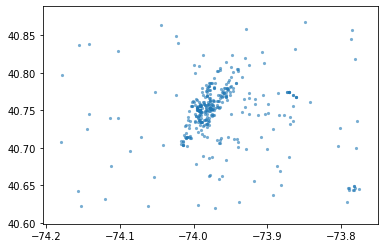

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

with open('./Data/pclus1.pkl', 'rb') as f:
    pclus = pkl.load(f)
with open('./Data/dclus1.pkl', 'rb') as f:
    dclus = pkl.load(f)
with open('./Data/pp.pkl', 'rb') as f:
    pp = pkl.load(f)
with open('./Data/dd.pkl', 'rb') as f:
    dd = pkl.load(f)
    
episode = 9

""" d2 """
d2 = pp[episode][:, 4].reshape(-1, 1)

"""공차 샘플링"""
x1 = int(dd[episode].shape[0] * 0.85)
x2 = dd[episode].shape[0] - x1

# 완전 랜덤 샘플링
def randomSampling(dc, size = 100):
    max_lon, min_lon = max(dc['dropoff_longitude']), min(dc['dropoff_longitude'])
    max_lat, min_lat = max(dc['dropoff_latitude']), min(dc['dropoff_latitude'])
    sample_lon = np.random.uniform(low=min_lon, high=max_lon, size=(size,1))
    sample_lat = np.random.uniform(low=min_lat, high=max_lat, size=(size,1))
    return np.concatenate([sample_lon, sample_lat], axis=1)
    
rS = randomSampling(dclus[episode], x2)

rSS = np.concatenate([rS, dclus[episode]['date'][0:rS.shape[0]].to_numpy().reshape(-1, 1), \
                dclus[episode]['time'][0:rS.shape[0]].to_numpy().reshape(-1, 1)], axis= 1)

# 공차 Sampling
x3 = np.random.choice(dd[episode].shape[0], x1, replace=False)
x3 = np.concatenate([dd[episode][x3], rSS], axis = 0)
x4 = x3[:, 0:2]
print(x3, x4, x4.shape)
plt.scatter(*x4.T, s=10, linewidth=0, alpha=0.6)



In [19]:
"""승객 위치 hdbscan"""
import hdbscan
from sklearn.preprocessing import RobustScaler

def myHdbscan(train_data_robustScaled, cluster_size):
    """auto HBSCAN"""
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, np.unique(clusterer.labels_).shape[0] # label갯수 리턴

def ScaledHdbscan(idx, pp, cluster_size = 7):
    from sklearn.preprocessing import RobustScaler
    # parameter
    idx = 2
    cluster_size = 10

    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
    train_data = pp[idx][:, :2]
    print(robustScaler.fit(train_data))
    train_data_robustScaled = robustScaler.transform(train_data)

    # Hdbscan 적용
    return clusterer, labelNum  = myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8

"""autoScaling"""
while labelNum < 3 or labelNum > 8:
        # cluster_size 높여가며
        if cluster_size1 < 20:
            cluster_size1 += 1
            clusterer1, labelNum1 = autoHdbscan(train_data_robustScaled, cluster_size1)
            
        # cluster_size 줄여가며
        if cluster_size2 > 2:
            cluster_size2 -= 1
            clusterer2, labelNum2 = autoHdbscan(train_data_robustScaled, cluster_size2)
            
        if labelNum1 >= 3 and labelNum1 <= 8:
            clusterer, labelNum, c luster_size = clusterer1, labelNum1, cluster_size1
            break
            
        if labelNum2 >= 3 and labelNum2 <= 8:
            clusterer, labelNum, cluster_size = clusterer2, labelNum2, cluster_size2
            break
        
        if cluster_size1 >= 20 and cluster_size2 <= 2:
            print("Can't run autoHdbscan\n")
            break

# label 수
print(idx, labelNum, cluster_size, clusterer.labels_.shape)

for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)
    
""" y2 """
from knn import KNN

X_train = pp[idx][:, 0:2]
# 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
t_train = clusterer.labels_ + 1
X_test = pp[idx][:, 2:4]
print("label : ", np.unique(t_train))
K=3 # K = 3

knn_train = KNN(K, X_train, t_train, np.unique(t_train))
knn_train.show_dim()

y2 = np.zeros(X_test.shape[0], dtype = int)

for i in range(X_test.shape[0]):
    knn_train.get_nearest_k(X_test[i])
    y2[i] = knn_train.weighted_majority_vote()
    knn_train.reset()
    

bincount = np.bincount(y2)
maxLabel = np.argmax(bincount)
maxLabelcount = np.max(bincount)
print("y2 : ", y2, "\ny2.bincount : ", bincount)
print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
# 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
y2 = np.where(y2 == maxLabel, 1.2, (np.where(y2 == 0, 0.8, 1)))

# 수 확인
values, counts = np.unique(y2, return_counts=True)
print("values: ",values,"counts: ", counts)

y2 = y2.reshape(-1, 1)
y2, y2.shape

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
2 8 10 (1510,)
-1 Label count :  123
0 Label count :  36
1 Label count :  10
2 Label count :  77
3 Label count :  16
4 Label count :  31
5 Label count :  32
6 Label count :  1185
label :  [0 1 2 3 4 5 6 7]
Input Dimension:  (1510, 2)
Output Dimension:  (1510,)
y2 :  [7 0 0 ... 7 7 0] 
y2.bincount :  [ 246   72   11   49   17   31   45 1039]
maxLabel:  7 maxLabelcount :  1039
values:  [0.8 1.  1.2] counts:  [ 246  225 1039]


(array([[1.2],
        [0.8],
        [0.8],
        ...,
        [1.2],
        [1.2],
        [0.8]]), (1510, 1))

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
-1 Label count :  21
0 Label count :  13
1 Label count :  295
2 Label count :  9
(338, 7) (338, 1)


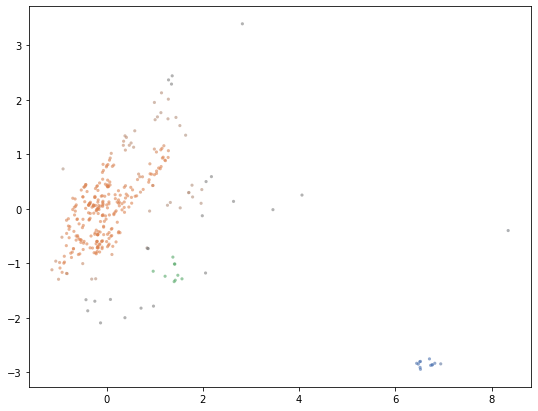

In [97]:
"""승객 위치 hdbscan"""
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
plt.rcParams["figure.figsize"] = [9,7]

episode = 7
cluster_size=9

#outlier 잡기
robustScaler = RobustScaler()
train_data = pp[episode][:, :2]
print(robustScaler.fit(train_data))
train_data_robustScaled = robustScaler.transform(train_data)
# print(train_data_robustScaled)
#HBSCAN
test_data = train_data_robustScaled
clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
clusterer.fit(test_data)
# clusterer.labels_ += 1 # Label 0부터 시작하도록
# print("Max label : ", clusterer.labels_.max())
# print(np.unique(clusterer.labels_))
for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)

color_palette = sns.color_palette('deep', 12)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)

cc = clusterer.labels_.reshape(-1, 1)
print(pp[idx].shape, cc.shape)
pp1 = np.concatenate((pp[idx][:,0:5], cc), axis = 1)  # pickup (lat,lon), dropoff(lat,lon), d2 , y2
pp1 = np.concatenate((pp1, pp[idx][:,5:7]), axis = 1) # day, time
pp1

with open('./Data/P0100.pkl', 'wb')as f:
    pkl.dump(pp1, f) # pickup (lat,lon), dropoff(lat,lon), d2 , y2, day, time -> 7가지

In [14]:
""" y2 """
from knn import KNN

X_train = pp[episode][:, 0:2]
# 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
t_train = clusterer.labels_ + 1
X_test = pp[episode][:, 2:4]
print("label : ", np.unique(t_train))
K=3 # K = 3

knn_iris = KNN(K, X_train, t_train, np.unique(t_train))
knn_iris.show_dim()

y2 = np.zeros(X_test.shape[0], dtype = int)

for i in range(X_test.shape[0]):
    knn_iris.get_nearest_k(X_test[i])
    y2[i] = knn_iris.weighted_majority_vote()
    knn_iris.reset()
    

bincount = np.bincount(y2)
maxLabel = np.argmax(bincount)
maxLabelcount = np.max(bincount)
print("y2 : ", y2, "\ny2.bincount : ", bincount)
print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
# 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
y2 = np.where(y2 == maxLabel, 1.2, (np.where(y2 == 0, 0.8, 1)))

# 수 확인
values, counts = np.unique(y2, return_counts=True)
print("values: ",values,"counts: ", counts)

y2 = y2.reshape(-1, 1)

2
label :  [0 1 2 3 4 5 6 7]
Input Dimension:  (1510, 2)
Output Dimension:  (1510,)
y2 :  [7 0 0 ... 7 7 0] 
y2.bincount :  [ 246   72   11   49   17   31   45 1039]
maxLabel:  7 maxLabelcount :  1039
values:  [0.8 1.  1.2] counts:  [ 246  225 1039]


In [23]:
""" d1 """
idx = 2
x1 = pp[idx][:, 0:2] # 승객 위치
y1 = x4              # 공차 위치


def Calculate_distance(X1, X2):
    """ euclidean 거리계산 -> harvasion으로 변경 고려 """
    return ((X1 - X2)**2).sum(1)**0.5

mat = np.zeros([x1.shape[0],y1.shape[0]]) #초기화

# d2 계산
for idx, i in enumerate(x1):
    mat[idx] = Calculate_distance(i, y1)

emin = np.min(np.where(mat==0.0, 1, mat))
d1 = 1 / (mat + emin) * emin
d1, d1.shape

NameError: name 'x4' is not defined

In [20]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import math

a1 = np.array([[1,2,3,4],
              [5,6,7,8]])
b1 = np.array([[1],[2]])
xx = d1 * d2 * y2

yyy = xx.size
xxx = xx.reshape(-1,)
print(yyy, np.min(xxx))
# ax = np.random.choice(100, 100)
plt.figure(figsize = [10,10])
xx.unique()
# plt.hist(xxx, bins=yyy)

NameError: name 'd1' is not defined